In [14]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [11]:
OUTPUT_DIR = '../../cache'
CACHE_DIR = pathlib.Path('/home/ec2-user/repos/dashboard/cache').absolute()
CACHE_DIR

PosixPath('/home/ec2-user/repos/dashboard/cache')

In [2]:
import sys
sys.path.append('/home/ec2-user/repos/conservation/conservation')
sys.path.append('/home/ec2-user/repos/seqmap')

In [ ]:
    import os
    import pandas as pd
    transcripts = ['ENST00000519868', 'ENST00000520450']
    
    
    cache_filez = os.listdir(CACHE_DIR)
    temp_dict = {}
    for f in cache_filez:
        if f.endswith('_de.parq') and not (f=='expression_de.parq'):
            df = pd.read_parquet(os.path.join(CACHE_DIR, f))
            df['transcript'] = df.apply(lambda x: x.name.split('.')[0], axis=1)
            df = df[df['transcript'].isin(transcripts)].copy()
            temp_dict[f.split('_')[0]] = df
            
    de_tables_dict = defaultdict(dict)
    for c, df in tqdm(temp_dict.items()):
        for row in df.itertuples():
            de_tables_dict[row[0]][c] = {'Cancer Average': row._7/TPM_DESEQ2_FACTOR, 'GTEx Average': row._8/TPM_DESEQ2_FACTOR, 
                                         'log2FC': row.log2FoldChange, 'padj': row.padj}
    for t, d in de_tables_dict.items():
        de_tables_dict[t] = pd.DataFrame(d).T
    tcga_gtex_tissue_metadata = pd.read_parquet(os.path.join(CACHE_DIR, 'gtex_tcga_pairs.parq'))
    tcga_gtex_tissue_metadata = tcga_gtex_tissue_metadata.drop_duplicates(['TCGA Cancer Type', 'GTEx Tissue Type']).copy()
    tcga_gtex_tissue_metadata.index = tcga_gtex_tissue_metadata['TCGA Cancer Type']

NameError: name 'transcripts' is not defined

In [ ]:
def query_transcript_tpms(transcript_ids, session):
    tpm_filter = session.query(TranscriptDE).filter(
                                                    TranscriptDE.transcript_id.in_(transcripts)
                                                ).statement
    qreturn = pd.read_sql(tpm_filter, session.bind)
    return qreturn
query_transcript_tpms(['ENST00000488147.1', 'ENST00000361789.2'])

In [2]:
from dashboard.etl.transcript_features import *
from dashboard.etl.sorf_query import *
# from phylocsf import *


from sqlalchemy import and_, or_

from veliadb import base, settings, annotation_loading
from veliadb.base import (Assembly, Gene, Transcript, Protein, Orf, OrfXref, Protein,
                          TranscriptOrf, Cds, Dataset, SequenceRegionXref, Exon, ProteinXref)
import veliadb.util as vdb_util

In [3]:
EXISTING_CACHE_DIR = '../../cache'
CACHE_DIR_TO_MERGE = ''

MERGE_OUTPUT_FOLDER = ''

In [4]:
    import pandas as pd
    import os
    import json
    # Protein Features
    protein_scores_existing = pd.read_csv(os.path.join(CACHE_DIR, 'protein_data', 'sequence_features_scores.csv'), index_col=0)
    protein_strings_existing = pd.read_csv(os.path.join(CACHE_DIR, 'protein_data', 'sequence_features_strings.csv'), index_col=0)

    protein_scores_merging = pd.read_csv(os.path.join(CACHE_DIR_TO_MERGE, 'protein_data', 'sequence_features_scores.csv'), index_col=0)
    protein_strings_merging = pd.read_csv(os.path.join(CACHE_DIR_TO_MERGE, 'protein_data', 'sequence_features_strings.csv'), index_col=0)

    pd.concat((protein_scores_existing, protein_scores_merging), join='outer').to_csv(MERGE_OUTPUT_FOLDER.joinpath('protein_data', 'sequence_features_scores.csv'))
    pd.concat((protein_strings_existing, protein_strings_merging), join='outer').to_csv(MERGE_OUTPUT_FOLDER.joinpath('protein_data', 'sequence_features_strings.csv'))

    # ESMFold
    esmfold_existing = load_esmfold(EXISTING_CACHE_DIR.joinpath('protein_data', 'esmfold.jsonlines'))
    esmfold_merging = load_esmfold(CACHE_DIR_TO_MERGE.joinpath('protein_data', 'esmfold.jsonlines'))
    for k, v in esmfold_merging.items():
        if k not in esmfold_existing:
            esmfold_existing[k] = v
    with open(MERGE_OUTPUT_FOLDER.joinpath('protein_data', 'esmfold.jsonlines'), 'w') as fwrite:
        for v in esmfold_existing.values():
            fwrite.write(json.dumps(v))
            fwrite.write('\n')

    # TCGA
    xena_exact_heatmap_data_existing = pickle.load(open(EXISTING_CACHE_DIR.joinpath('xena_exact_heatmap.pkl'), 'rb'))
    xena_exact_heatmap_data_merging = pickle.load(open(CACHE_DIR_TO_MERGE.joinpath('xena_exact_heatmap.pkl'), 'rb'))
    xena_exact_heatmap_data_merged = []
    xena_exact_heatmap_data_merged[0] = pd.concat((xena_exact_heatmap_data_existing[0], xena_exact_heatmap_data_merging[0]), axis=0, how='outer')
    xena_exact_heatmap_data_merged[1] = pd.concat((xena_exact_heatmap_data_existing[1], xena_exact_heatmap_data_merging[1]), axis=1, how='outer')
    xena_exact_heatmap_data_merged[2] = pd.concat((xena_exact_heatmap_data_existing[2], xena_exact_heatmap_data_merging[2]), axis=1, how='outer')
    pickle.dump(open(MERGE_OUTPUT_FOLDER.joinpath('xena_exact_heatmap.pkl'), 'wb'), xena_exact_heatmap_data_merged)

    xena_parq_merged = pd.concat((pd.read_parquet(EXISTING_CACHE_DIR.joinpath('xena_app.parq')), pd.read_parquet(CACHE_DIR_TO_MERGE.joinpath('xena_app.parq'))), axis=1, how='outer')
    xena_parq_merged.to_parquet(MERGE_OUTPUT_FOLDER.joinpath('xena_app.parq'))

    # TODO Xena.db, (xena_de_tables_dict.pkl, CODE_de.parq) -> these actually shouldn't be needed since they're merged into xena.db
    # should be no merging autoimmune

    
    

In [8]:
import pickle

In [19]:
import pyarrow.parquet as pq


In [20]:
    xena_metadata = pd.read_parquet(CACHE_DIR.joinpath('xena_metadata.parq'))
    xena_metadata['dashboard_group'] = list(map(lambda x: '-'.join(map(str, x)), xena_metadata[['_primary_site', '_study']].values))
    parq_metadata = pq.read_metadata(CACHE_DIR.joinpath('xena_app.parq'))
    xena_transcripts = set(parq_metadata.schema.names)


In [23]:
x = pd.read_parquet(CACHE_DIR.joinpath('xena_app.parq'))
x

,ENST00000505215,ENST00000401811,ENST00000578232,ENST00000431268,ENST00000481232,ENST00000541144,ENST00000329099,ENST00000506754,ENST00000599988,ENST00000296666,ENST00000544052,ENST00000550379,ENST00000222399,ENST00000512345,ENST00000339037,ENST00000437302,ENST00000219069,ENST00000445336,ENST00000490659,ENST00000348581,ENST00000513420,ENST00000535381,ENST00000467726,ENST00000403435,ENST00000528988,ENST00000412799,ENST00000506354,ENST00000594723,ENST00000407724,ENST00000481221,ENST00000521747,ENST00000597434,ENST00000398043,ENST00000484934,ENST00000629441,ENST00000570844,ENST00000493483,ENST00000423799,ENST00000310581,ENST00000534591,ENST00000231526,ENST00000543542,ENST00000444670,ENST00000428388,ENST00000488758,ENST00000544069,ENST00000587459,ENST00000526278,ENST00000493625,ENST00000616469,...,ENST00000541901,ENST00000465308,ENST00000414637,ENST00000452938,ENST00000403376,ENST00000544578,ENST00000326094,ENST00000587056,ENST00000300181,ENST00000467901,ENST00000395379,ENST00000464710,ENST00000581441,ENST00000324196,ENST00000421182,ENST00000399054,ENST00000347770,ENST00000620197,ENST00000431144,ENST00000389153,ENST00000575332,ENST00000577716,ENST00000402042,ENST00000466567,ENST00000578896,ENST00000599934,ENST00000550671,ENST00000338167,ENST00000506078,ENST00000520318,ENST00000368748,ENST00000468865,ENST00000381692,ENST00000520447,ENST00000472200,ENST00000451225,ENST00000429578,ENST00000435716,ENST00000510062,ENST00000561586,ENST00000619363,ENST00000462788,ENST00000608382,ENST00000485503,ENST00000595837,ENST00000539599,ENST00000533506,ENST00000495856,ENST00000451384,ENST00000378215
GTEX-S4Q7-0003-SM-3NM8M,0.001,1.531027,0.001000,16.601020,3.640912,1.151010,11.790884,0.011,0.001000,13.171064,17.331204,0.001,1.471003,0.001000,0.001000,0.001,7.710904,0.011000,3.811080,3.621030,13.441293,0.980983,0.001000,0.100998,0.300993,0.001000,0.001,0.390989,1.121011,0.001000,0.001,0.240999,2.761017,0.110998,0.801014,1.691027,0.001000,0.311003,0.130996,3.570930,0.280992,0.320990,1.890935,0.271007,0.001000,0.401007,0.090999,0.001,0.841013,0.001000,...,2.420995,0.001000,0.001000,1.311029,0.001000,0.001,1.430977,0.231006,28.211276,0.121002,0.001000,0.001000,0.001000,0.991030,0.001000,4.761117,54.670854,2.851063,0.550991,4.011106,1.390978,0.081002,0.201005,7.081230,3.980915,0.001,3.140948,0.021,0.001000,6.721112,0.381010,0.491002,11.150991,2.690921,0.260996,0.001000,0.001000,0.001,0.190994,1.781015,0.121002,2.500991,13.291205,0.001000,0.001,0.251007,12.871426,0.650987,0.021000,0.071002
TCGA-19-1787-01,0.001,2.251053,0.001000,3.070982,0.850982,0.121002,1.941000,0.001,4.851060,11.731373,16.190773,0.001,69.190401,0.001000,0.740977,0.001,7.070930,0.050999,0.171004,4.141060,13.591191,0.110998,0.471000,0.031000,0.291002,0.001000,0.001,0.071002,1.481029,0.001000,0.001,0.181005,4.071047,0.371002,3.051038,3.591036,0.071002,0.001000,0.001000,1.221031,4.180861,0.280992,2.220986,0.001000,0.001000,0.100998,0.001000,0.001,0.381010,0.001000,...,1.740980,0.001000,0.001000,1.180993,0.001000,0.001,0.381010,0.460988,48.779396,0.061002,0.001000,0.071002,0.001000,0.001000,0.001000,20.730744,11.640652,1.390978,0.001000,4.520869,5.590975,0.001000,0.001000,0.471000,0.600985,0.001,1.491020,0.001,0.001000,6.940791,0.001000,0.511002,20.231060,0.001000,0.291002,0.001000,0.001000,0.001,0.001000,0.311003,0.751008,6.831015,1.491020,0.721014,0.001,0.031000,0.050999,4.371111,0.001000,0.001000
TCGA-S9-A7J2-01,0.001,1.710953,0.260996,6.471051,7.061135,0.110998,40.090819,0.001,0.001000,12.240580,18.250954,0.001,0.880991,0.001000,0.061002,0.001,9.201060,0.021000,0.320990,0.001000,24.810863,0.160996,0.171004,0.041001,0.001000,0.130996,0.001,0.201005,1.380987,2.141023,0.001,0.171004,9.231084,1.011012,1.910963,4.001109,0.001000,0.041001,0.330999,7.470993,4.980878,0.001000,2.961032,1.131001,0.130996,0.001000,0.001000,0.001,1.211001,1.861028,...,3.290941,0.280992,0.001000,2.881061,0.001000,0.001,0.710989,0.001000,33.110112,0.100998,1.161026,0.001000,0.001000,0.001000,0.001000,25.291838,26.67

In [6]:
import json
json.dumps({'hi': 'bye'})

'{"hi": "bye"}'

In [ ]:
def process_sums_dataframe_to_heatmap(xena_vtx_sum_df, xena_metadata_df):
    xena_vtx_sum_df = np.log2(xena_vtx_sum_df + 1)

    xena_vtx_exp_df = xena_metadata_df.merge(xena_vtx_sum_df, left_index=True, right_index=True)

    xena_vtx_sum_df = xena_vtx_sum_df.merge(xena_metadata_df, left_index=True, right_index=True)
    transcript_col_names = [i for i in xena_vtx_sum_df.columns if i not in xena_metadata_df.columns]
    groups = xena_metadata_df.loc[xena_vtx_sum_df.index][['_primary_site', '_study']].apply(lambda x: '-'.join(x), axis=1)
    xena_vtx_sum_df = xena_vtx_sum_df[transcript_col_names].groupby(groups).aggregate(np.mean)

    threshold = .1
    mean_vals = xena_vtx_sum_df.max()
    cols_to_remove = mean_vals[mean_vals < threshold].index
    xena_vtx_sum_df = xena_vtx_sum_df.drop(cols_to_remove, axis=1)
    
    tau_df = xena_vtx_sum_df/xena_vtx_sum_df.max()
    tau = ((1-tau_df).sum())/(tau_df.shape[0]-1)
    tau.name = 'tau'
    xena_tau_df = xena_vtx_sum_df.T.merge(tau, left_index=True, right_index=True)

    return xena_tau_df, xena_vtx_sum_df, xena_vtx_exp_df


In [24]:
sorf_df = load_jsonlines_table(os.path.join(CACHE_DIR, 'sorf_table.jsonlines'), index_col='vtx_id')

# removes any sORFs with multiple VTX IDs (e.g. multi-mappers to the genome)
#    sorf_df = sorf_df[sorf_df['vtx_id'].isin(secreted_vtx_ids)]
#    sorf_df = sorf_df[~sorf_df['vtx_id'].str.contains('\|')]
session = base.Session()
sorf_df['index_copy'] = sorf_df.index

sorf_df['show_details'] = False
sorf_df['orf_xrefs'] = sorf_df.apply(lambda x: tuple(x.orf_xrefs.split(';')), axis=1)
sorf_df['source'] = sorf_df.apply(lambda x: tuple(x.source.split(';')), axis=1)

cols = list(sorf_df.columns)
cols.insert(0, cols.pop(cols.index('show_details')))

phase_ids = []
phase_entries = []
protein_xrefs = []
for row in tqdm(sorf_df.itertuples()):
    protein_xrefs.append(tuple([str(px.xref) for px in \
                            session.query(ProteinXref)\
                                    .join(Protein, Protein.id == ProteinXref.protein_id)\
                                    .filter(Protein.aa_seq == row.aa).all()]))


phase_ids, phase_entries = parse_sorf_phase(sorf_df)
sorf_df['screening_phase_id'] = phase_ids
sorf_df['screening_phase'] = phase_entries
sorf_df['protein_xrefs'] = protein_xrefs
sorf_df['aa_length'] = sorf_df.apply(lambda x: len(x.aa), axis=1)

sorf_df = sorf_df[sorf_df['screening_phase'] != '-1']

cols = ['show_details', 'vtx_id', 'aa_length', 'screening_phase_id', 'screening_phase', 'ucsc_track', 
        'source', 'orf_xrefs', 'protein_xrefs', 'gene_xrefs', 'transcript_xrefs',  
        'transcripts_exact', 'transcripts_overlapping', 'aa', 'nucl', 
        'index_copy', 'genscript_id', 'chr', 'strand', 'start', 'end', 
        'chrom_starts', 'block_sizes', 'phases',]

sorf_df = sorf_df[cols]
session.close()
_, blastp_table = load_mouse_blastp_results(CACHE_DIR = CACHE_DIR)
sorf_df = sorf_df.merge(pd.DataFrame(blastp_table).T, left_index=True, right_index=True, how='left')
protein_scores = pd.read_csv(os.path.join(CACHE_DIR, 'protein_data', 'sequence_features_scores.csv'), index_col=0)

sorf_df = sorf_df.merge(protein_scores[['Deepsig', 'SignalP 6slow', 'SignalP 5b', 'SignalP 4.1']],
                left_index=True, right_index=True, how='left')
protein_strings = pd.read_csv(os.path.join(CACHE_DIR, 'protein_data', 'sequence_features_strings.csv'), index_col=0)
protein_cutsite = protein_strings.apply(lambda x: x.str.find('SO')+1).replace(0, -1).drop('Sequence', axis=1)
sorf_df = sorf_df.merge(protein_cutsite,
                left_index=True, right_index=True, how='left', suffixes=('_score', '_cut'))

id_data = pd.read_csv('s3://velia-data-dev/VDC_001_screening_collections/all_phases/interim_phase1to7_non-sigp_20230723.csv')

id_data.index = id_data['vtx_id']
sorf_df = sorf_df.merge(id_data[['trans1',
        'trans2', 'trans3', 'sec1', 'sec2', 'sec3', 'translated_mean',
        'secreted_mean', 'translated', 'swissprot_isoform', 'ensembl_isoform',
        'refseq_isoform', 'phylocsf_58m_avg', 'phylocsf_58m_max', 'phylocsf_58m_min',
        'phylocsf_vals']], left_index=True, right_index=True, how='left')

with open('../../data/all_secreted_phase1to7.txt', 'r') as f:
    secreted_ids = [i.strip() for i in f.readlines()]

sorf_df.insert(int(np.where(sorf_df.columns=='translated')[0][0]), 'secreted', [True if i in secreted_ids else False for i in sorf_df.index])
sorf_df['transcripts_exact'] = [tuple(i) for i in sorf_df['transcripts_exact']]
sorf_df['transcripts_overlapping'] = [tuple(i) for i in sorf_df['transcripts_overlapping']]
sorf_df.to_parquet(os.path.join(CACHE_DIR, 'sorf_df.parqa'))
# sorf_df.to_csv(os.path.join(OUTPUT_DIR, 'sorf_df_conformed.csv'))

In [21]:
from dashboard.app import load_mouse_blastp_results

def parse_sorf_phase(sorf_df):
    phase_ids = []
    phase_entries = []
    for row in sorf_df.itertuples():
        if row.velia_id.startswith('Phase'):
            phase_ids.append(row.velia_id)
            phase_entries.append(f'Phase {row.velia_id[6]}')
        elif row.secondary_id.startswith('Phase'):
            phase_ids.append(row.secondary_id)
            phase_entries.append(f'Phase {row.secondary_id[6]}')
        elif any(['Phase' in xref for xref in row.orf_xrefs]):
            phase_id = [x for x in row.orf_xrefs if x.startswith('Phase')][0]
            phase_ids.append(phase_id)
            phase_entries.append(f'Phase {phase_id[6]}')
        elif row.velia_id.startswith('smORF'):
            phase_ids.append(row.velia_id)
            phase_entries.append('Phase 1')
        else:
            orf = session.query(Orf).filter(Orf.id == int(row.vtx_id.split('-')[1])).one()
            phase_ids.append(orf.velia_id)
            if orf.velia_id.startswith('Phase'):
                phase_entries.append(f'Phase {orf.velia_id[6]}')
            else:
                phase_entries.append('-1')
    return phase_ids, phase_entries



2023-10-10 21:56:21.850 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2023-10-10 21:56:21.852 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2023-10-10 21:56:21.853 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2023-10-10 21:56:21.854 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2023-10-10 21:56:21.856 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2023-10-10 21:56:21.857 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2023-10-10 21:56:21.859 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2023-10-10 21:56:21.860 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2023-10-

In [ ]:
from dashboard.app import load_mouse_blastp_results

In [ ]:
# import os
# os.chdir('..')

In [ ]:
og_index = sorf_df.index

In [ ]:
    sorf_df = sorf_df[sorf_df['screening_phase'] != '-1']

    cols = ['show_details', 'vtx_id', 'screening_phase_id', 'screening_phase', 'ucsc_track', 
            'source', 'orf_xrefs', 'protein_xrefs', 'gene_xrefs', 'transcript_xrefs',  
            'transcripts_exact', 'transcripts_overlapping', 'aa', 'nucl', 
            'index_copy', 'genscript_id', 'chr', 'strand', 'start', 'end', 
            'chrom_starts', 'block_sizes', 'phases',]

    sorf_df = sorf_df[cols]
    session.close()
    _, blastp_table = load_mouse_blastp_results()
    sorf_df = sorf_df.merge(pd.DataFrame(blastp_table).T, left_index=True, right_index=True, how='left')
    
    id_data = pd.read_csv('s3://velia-data-dev/VDC_001_screening_collections/all_phases/interim_phase1to7_non-sigp_20230718.csv')
    id_data.index = id_data['vtx_id']
    sorf_df = sorf_df.merge(id_data[['trans1',
           'trans2', 'trans3', 'sec1', 'sec2', 'sec3', 'translated_mean',
           'secreted_mean', 'translated', 'swissprot_isoform', 'ensembl_isoform',
           'refseq_isoform', 'phylocsf_58m_avg', 'phylocsf_58m_max', 'phylocsf_58m_min',
           'phylocsf_vals']], left_index=True, right_index=True, how='left')

In [ ]:
sorf_df.loc[['VTX-0806247', 'VTX-0849972', 'VTX-0849974', 'VTX-0849976',
       'VTX-0849977', 'VTX-0849983', 'VTX-0849984', 'VTX-0849999']]

,vtx_id,genscript_id,velia_id,secondary_id,ucsc_track,chr,strand,start,end,chrom_starts,block_sizes,phases,aa,nucl,orf_xrefs,gene_xrefs,transcript_xrefs,protein_xrefs,source,transcripts_exact,transcripts_overlapping,index_copy,show_details,screening_phase_id,screening_phase
vtx_id,,,,,,,,,,,,,,,,,,,,,,,,,
VTX-0806247,VTX-0806247,U4958HF130-38,RHPN1-AS1,,chr8:143368166-143368411,chr8,-,143368166,143368411,143368166,246,0,MFTMGFLKTVLLGTSACVSPPTMPAFFSLPAERRLQAWPQSEAPLSVSSCFQNRPPEPASFQNLRPEPASLQNLRTEPTSF,ATGTTCACAATGGGGTTTTTAAAAACGGTTTTGTTAGGGACAAGTGCTTGTGTGAGTCCTCCGACAATGCCTGCTTTCTTCTCTCTGCCCGCGGAGCGGAGGCTCCAGGCCTGGCCCCAGTCCGAGGCGCCTCTGTCGGTGTCGTCCTGCTTCCAAAACCGGCCTCCAGAACCCGCCTCCTTCCAGAACCTCCGTC...,"[16-139, 6xhis-HSA-HRV3C-RHPN1-AS1_01, II_169742, RHPN1-AS1, RHPN1-AS1, U4958HF130-38, VTXRP203]",ENSG00000254389.3;HGNC:28457;RHPN1-AS1;28457;78998;gene-RHPN1-AS1;RHPN1-AS1,ENSE00002313299.2;exon-CHS.59161.3;exon:ENST00000381317.9_PAR_Y:1;exon-NM_001173474.2-2-1;exon-NM_004192.4-2-1;exon-XM_047442774.1-1;ENSE00001459678.1;exon:ENST00000373159.1:4,"[16-139, 6xhis-HSA-HRV3C-RHPN1-AS1_01, RHPN1-AS1, RHPN1-AS1, VTXRP203]","[openprot, velia_phase1_Prensner]",[ENST00000518049],"[ENST00000518049, rna-NR_026785]",VTX-0806247,False,RHPN1-AS1,-1
VTX-0849972,VTX-0849972,U4958HF130-5,CCNI_77997099_81aa,CCNI_77997099_81aa,chr4:77075702-77075947,chr4,-,77075702,77075947,77075702,246,0,LSRFFLFFPPFPFLFFFFFSFLPSPPFTISPRRRFPRAGAEPVSPPASPRPPPPYGEREPPPNPGSSGGGLRPGVIMELIR,CTGTCTCGCTTTTTCTTATTTTTCCCCCCTTTCCCCTTTCTTTTTTTTTTTTTCTTTTCTTTTCTCCCCTCCCCCCCTTTCACCATTTCCCCTCGGAGGCGCTTTCCCCGGGCAGGGGCAGAGCCGGTCTCACCCCCCGCCTCTCCCCGGCCCCCGCCGCCCTATGGCGAGAGGGAGCCCCCTCCCAACCCGGGCT...,"[CCNI_77997099_81aa, U4958HF130-5]",CCNI;ENSG00000118816.11;HGNC:1595;10983;1595;CCNI;gene-CCNI,23598;387266;ENSG00000275920.1;gene-KRTAP5-3-3;HGNC:23598;KRTAP5-3;KRTAP5-3;ENSE00003823927.1;exon:ENST00000643145.1:4;ENSE00003865918.1;exon:ENST00000653649.1:2;exon:ENST00000658409.1:2;exon:ENST...,[CCNI_77997099_81aa],[velia_phase1_Chen],"[ENST00000237654, ENST00000507788]","[ENST00000237654, rna-NM_001348132, rna-NM_001348136, rna-NM_001348138, rna-NM_001348134, rna-NM_001348139, rna-NM_001348135, rna-NM_001348140, rna-NM_001348137, ENST00000507788]",VTX-0849972,False,CCNI_77997099_81aa,-1
VTX-0849974,VTX-0849974,U4958HF130-7,COL27A1_116917929_68aa,COL27A1_116917929_68aa,chr9:114155650-114155856,chr9,+,114155650,114155856,114155650,207,0,LIISLSLFLASSSFLVEAEKDRGRGERGARTPGTMGLARAPAGPQPRCLPARAPLGAGLRWGRGGRAL,TTGATCATCTCTCTCTCTCTTTTTCTTGCTTCTTCTTCCTTTTTGGTGGAAGCAGAAAAGGACCGAGGCAGGGGCGAGCGCGGCGCCCGGACTCCTGGGACCATGGGCCTGGCGCGGGCGCCCGCGGGGCCCCAGCCGCGCTGCCTGCCTGCTCGGGCGCCCCTGGGCGCGGGGCTGCGCTGGGGGCGCGGGGGCC...,"[16-132, 6xhis-HSA-HRV3C-COL27A1_01, COL27A1_116917929_68aa, COL27A1_116917929_68aa, U4958HF130-7, VTXRP196]",COL27A1;ENSG00000196739.15;HGNC:22986;22986;85301;COL27A1;gene-COL27A1,DGCR6;ENSG00000183628.14;HGNC:2846;ENSE00003530664.1;ENSE00003530664.1;ENSE00003630879.1;exon-CHS.22075.1;exon-CHS.22075.1;exon:ENST00000269571.10:10;exon:ENST00000406381.6:10;exon:ENST00000445658...,"[16-132, 6xhis-HSA-HRV3C-COL27A1_01, COL27A1_116917929_68aa, COL27A1_116917929_68aa, VTXRP196]",[velia_phase1_Chen],[ENST00000356083],"[rna-XM_017015239, rna-XM_006717308, rna-XM_011519138, rna-XM_011519140, rna-XM_011519142, rna-XM_011519143, rna-XM_011519144, rna-XR_929860, rna-XM_047423992, rna-XM_047423993, rna-XM_047423994, ...",VTX-0849974,False,COL27A1_116917929_68aa,-1
VTX-0849976,VTX-0849976,U4958HF130-9,CXCL2_74964836_75aa,CXCL2_74964836_75aa,chr4:74098795-74099120,chr4,-,74098795,74099120,74098795;74099021,128;100,2;0,MARATLSAAPSNPRLLRVALLLLLLVAASRRAAGAPLATELRCQCLQTLQGIHLKNIQSVKVKSPGPHCAQTEVM,ATGGCCCGCGCCACGCTCTCCGCCGCCCCCAGCAATCCCCGGCTCCTGCGGGTGGCGCTGCTGCTCCTGCTCCTGGTGGCCGCCAGCCGGCGCGCAGCAGGAGCGCCCCTGGCCACTGAACTGCGCTGCCAGTGCTTGCAGACCCTGCAGGGAATTCACCTCAAGAACATCCAAAGTGTGAAGGTGAAGTCCCCCG...,"[20-007, 6xhis-HSA-HRV3C-CXCL2_74964836_75aa_01, CXCL2_74964836_75aa, CXCL2_74964836_75aa, CXCL2_74964836_75aa-his-HSA_

In [ ]:
og_index.difference(sorf_df.index)

Index(['VTX-0806247', 'VTX-0849972', 'VTX-0849974', 'VTX-0849976',
       'VTX-0849977', 'VTX-0849983', 'VTX-0849984', 'VTX-0849999'],
      dtype='object', name='vtx_id')

In [ ]:
from Bio import SeqIO
transcripts = SeqIO.parse(os.path.join(current_folder, './gencode.v42.transcripts.fa'), 'fasta')
transcripts = {r.id: str(r.seq) for r in transcripts}


In [ ]:
from copy import deepcopy
def parallel_sorf_query(vtx_id):
# Query DB
    session = base.Session() # connect to db
    orfs = session.query(Orf).filter(Orf.id == vtx_id).all()
    if len(orfs) == 0:
        print(f"{vtx_id} not found in veliadb")
        session.close()
        # return {}
    elif len(orfs) > 1:
        print(f"{vtx_id} had multiple entries found in veliadb")
        session.close()
        # return {}
    else:
        current_orf = orfs[0]
    # Loop over orfs, and populate sorf_table file with attributes of interest
    # nt, aa = extract_nucleotide_sequence_veliadb(current_orf, reference)
    nt = current_orf.nt_seq
    aa = current_orf.aa_seq
    r_internal = find_seq_substring(nt, deepcopy(transcripts))
    transcripts_exact = [i.split('|')[0].split('.')[0] for i in r_internal if i.startswith('ENST')]
    overlapping_tids = query_overlapping_transcripts(current_orf, session)
    overlapping_tids = [[i.split('.')[0] for i in [t.ensembl_id, t.refseq_id, t.chess_id] if i][0] for t in overlapping_tids]
    attributes = parse_orf(current_orf, session)
    attributes['transcripts_exact'] = transcripts_exact
    attributes['transcripts_overlapping'] = overlapping_tids
    # if attributes['aa'] == '':
    attributes['aa'] = aa
    # if attributes['nucl'] == '':
    attributes['nucl'] = nt
    session.close()
    return attributes


In [ ]:
def find_seq_substring(query, target_dict):
    if query == '':
        return []
    else:
        return [k for k, s in target_dict.items() if query.lower() in s.lower()]

In [ ]:
NCPU = 16

In [ ]:
    with open(input_file) as fhandle:
        ids = [int(i.replace('VTX-', '')) for i in fhandle.readlines()]
    # Query DB
    session = base.Session() # connect to db
    orfs = session.query(Orf).filter(Orf.id.in_(ids)).all()
    # orfs = [OrfData(i) for i in orfs]
    missing_orfs = set(ids) - set([i.id for i in orfs])
    if len(missing_orfs) > 0:
        print('WARNING: some of the provided IDs were not found in veliadb.', *missing_orfs)
    # """
    with open(os.path.join(OUTPUT_DIR, 'sorf_table.jsonlines'), 'w') as fopen:
        with mp.Pool(NCPU) as ppool:
            results = {}
            for r in tqdm(ppool.imap(parallel_sorf_query, ids), total=len(ids)):
                results[r['vtx']] = r
                fopen.write(json.dumps(r))

100%|██████████| 865/865 [02:23<00:00,  6.04it/s]


In [ ]:
pd.DataFrame(results).T['nucl'].apply(len).sort_values()

VTX-0850805     45
VTX-0851523     57
VTX-0850813     60
VTX-0851668     60
VTX-0850457     69
              ... 
VTX-0085170    594
VTX-0735177    597
VTX-0852783    597
VTX-0518494    672
VTX-0604477    684
Name: nucl, Length: 865, dtype: int64

In [ ]:
sorf_table = load_jsonlines_table('../../cache/sorf_table.jsonlines', index_col='vtx')

100%|██████████| 865/865 [00:00<00:00, 65917.02it/s]


In [ ]:
sorf_table.loc['VTX-0849972']

vtx                                                                                                                                                                                                                    VTX-0849972
genscript_id                                                                                                                                                                                                          U4958HF130-5
velia_id                                                                                                                                                                                                        CCNI_77997099_81aa
secondary_id                                                                                                                                                                                                    CCNI_77997099_81aa
ucsc_track                                                                                  

In [ ]:
vtx_id = 849972

In [ ]:
    session = base.Session() # connect to db
    orfs = session.query(Orf).filter(Orf.id == vtx_id).all()
    if len(orfs) == 0:
        print(f"{vtx_id} not found in veliadb")
        session.close()
        # return {}
    elif len(orfs) > 1:
        print(f"{vtx_id} had multiple entries found in veliadb")
        session.close()
        # return {}
    else:
        current_orf = orfs[0]
    # Loop over orfs, and populate sorf_table file with attributes of interest
    nt, aa = extract_nucleotide_sequence_veliadb(current_orf, reference)
    r_internal = find_seq_substring(nt, transcripts)
    transcripts_exact = [i.split('|')[0].split('.')[0] for i in r_internal if i.startswith('ENST')]
    overlapping_tids = query_overlapping_transcripts(current_orf, session)
    overlapping_tids = [[i.split('.')[0] for i in [t.ensembl_id, t.refseq_id, t.chess_id] if i][0] for t in overlapping_tids]
    attributes = parse_orf(current_orf, session)
    attributes['transcripts_exact'] = transcripts_exact
    attributes['transcripts_overlapping'] = overlapping_tids
    if attributes['aa'] == '':
        attributes['aa'] = aa
    if attributes['nucl'] == '':
        attributes['nucl'] = nt
    session.close()

NameError: name 'base' is not defined

In [ ]:
transcripts_exact

['ENST00000237654', 'ENST00000507788']

In [ ]:
r_internal

['ENST00000237654.9|ENSG00000118816.11|OTTHUMG00000130106.4|OTTHUMT00000252412.3|CCNI-201|CCNI|2759|protein_coding|',
 'ENST00000507788.2|ENSG00000118816.11|OTTHUMG00000130106.4|OTTHUMT00000362765.2|CCNI-205|CCNI|915|protein_coding|']

In [ ]:
meta = pd.read_parquet('../cache/gtex_tcga_pairs.parq')

In [ ]:
updated_data = pd.read_csv('../data/interim_phase1to7_all_20230717.csv', index_col=0)

In [ ]:
updated_data.shape

(4943, 51)

In [ ]:
import pyfaidx

In [ ]:
transcripts = pyfaidx.Fasta(os.path.join('.', 'gencode.v42.transcripts.fa'))


In [ ]:
find_seq_substring('ATGCCCCTAGGTCTCCTGTGGCTGGGCCTAGCCCTGTTGGGGGCTCTGCATGCCCAGGCCCAGGACTCCACCTCAGACCTGATCCCAGCCCCACCTCTGAGCAAGGTCCCTCTGCAGCAGAACTTCCAGGACAACCAAGTGAGGGCCGACATCTCCTGGGGGTGTGAGAGTCAGACTGACGTCACAGGCAAGGGATGGCCAAAGCTGAGGGATCCTGTCGTTCACCTCGCTGTTCTGCCCGGAATTCATCTGTGTTCATCCTTCCTCTGTTCCTTAGAGCAACGTTTATAG',
                   transcripts)

['ENST00000470902.5|ENSG00000148346.12|OTTHUMG00000020734.1|OTTHUMT00000054376.1|LCN2-204|LCN2|877|protein_coding_CDS_not_defined|',
 'ENST00000487719.1|ENSG00000148346.12|OTTHUMG00000020734.1|OTTHUMT00000054379.1|LCN2-205|LCN2|427|retained_intron|']

In [ ]:
    esmfold = {}
    with jsonlines.open('../../data/phase7_part2_esmfold.jsonlines') as fopen:
        for l in fopen.iter():
            esmfold[l['sequence']] = l
esmfold.keys()

dict_keys(['MAWTKYQLFLAGLMLVTGSINTLSAKQWACSWENSPAWLPSTSSDAELQGNQTPA', 'MKRMVSWSFHKLKTMKHLLLLLLCVFLVKSQGVNDNEEMRKLGHR', 'MRVLLAALGLLFLGALRAFPQGCSRHSSAHRGLLTAGSSVSLTTTWMRPTAVQPA', 'MVPAAGRRPPRVMRLLGWWQVLLWVLGLPVRGVEGPYGFSEPKR', 'MLQGLLPVSLLLSVAVSAIKELPGVKKYEVVYPIRLHPLHKREAKEPEQQFLSSMKIS', 'MAEPGHSHHLSARVRGRTERRIPRLWRLLLWAGTAFQVTQGTGPELHACKEPSPATPGSFWI', 'MASRLTLLTLLLLLLAGGLGRTPKQTWRASSLTPRTSPVSTRP', 'MKDSCITVMAMALLSGFFFFAPASSYNLDVRGARSFSPPRAGRHFGYRVLQLDGHRTRRRGLFPGGRHELRRNIAVTTSMSCTDFSFHFPIQSPASNCFCQPLCGAEPE', 'MARGSLRRLLRLLVLGLWLALLRSVAGEQAPASDPRPPPQAPPPAPAAAPGARTWTSAWTARLAGRDRTATSAWAALQHLLPPSGCFGPSLGAL', 'MTVLAPAWSPTTYLLLLLLLSSGLSGTQDCSFQHSPISSDFAVKIRELPGLILFSPAV', 'MARRHCFSYWLLVCWLVVTVAEGQEEVFTPPGDSQNNADATDCQIFTLTPPPAPRSPVTRAQPITKTPRYFPRRRLQRGSSSEES', 'MATEGAAQLGNRVAGMVCSLWVLLLVSSVLALEVGRGECSGRPATPDSDL', 'MKLGCVLMAWALYLSLGVLWVAQMLLAASFETLQCEGPVCTEESSCHTEDDLTDAREAGFQVKAYTFSEPFHLIVSYGASSSAAPPTLNPAPQKSAAPGTAPEEAPGPLPPPPTPSSEDPGFSSPLGMPDPHLYHQMGLLLKHMQDVRVLLGHLLMELRELSGHRKPGTTKATAE', 'MAP

In [ ]:
def load_bigwig_tracks(annotation_dir):
    """
    Load PhyloCSF bigwig tracks into memory
    
    Parameters
    ----------
    annotation_dir : pathlib.Path
        Directory with PhyloCSF bigwig tracks
        
    Returns
    -------
    bw_map : dict
        Dictionary with reading frame as keys and pyBigWig tracks as values
    """
    
    bw_p1 = pyBigWig.open(str(annotation_dir.joinpath('phylocsf', 'PhyloCSF+1.bw')))
    bw_p2 = pyBigWig.open(str(annotation_dir.joinpath('phylocsf', 'PhyloCSF+2.bw')))
    bw_p3 = pyBigWig.open(str(annotation_dir.joinpath('phylocsf', 'PhyloCSF+3.bw')))

    bw_n1 = pyBigWig.open(str(annotation_dir.joinpath('phylocsf', 'PhyloCSF-1.bw')))
    bw_n2 = pyBigWig.open(str(annotation_dir.joinpath('phylocsf', 'PhyloCSF-2.bw')))
    bw_n3 = pyBigWig.open(str(annotation_dir.joinpath('phylocsf', 'PhyloCSF-3.bw')))
    
    bw_map = {'+1': bw_p1, '+2': bw_p2, '+3': bw_p3, 
              '-1': bw_n1, '-2': bw_n2, '-3': bw_n3}
    
    return bw_map
bw_map = load_bigwig_tracks('/home/ec2-user/phylocsf')

databases  models  protein_function_modeling  riboseq_callers  tmp


In [ ]:
import os
os.chdir('..')

In [ ]:
from dashboard.etl.sorf_query import *
from dashboard.app import load_mouse_blastp_results

2023-07-18 18:37:46.058 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2023-07-18 18:37:46.060 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2023-07-18 18:37:46.062 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2023-07-18 18:37:46.064 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2023-07-18 18:37:46.065 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2023-07-18 18:37:46.066 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2023-07-18 18:37:46.068 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2023-07-18 18:37:46.069 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2023-07-

In [ ]:
def load_sorf_df():
    """
    """
    session = base.Session()

    sorf_df = pd.read_excel('../data/interim_phase1to6_secreted_hits_20230330.xlsx')
    secreted_ph7_hit_ids = pd.read_csv('../data/phase_7_secreted_hits.csv', index_col=0)

    secreted_vtx_ids = set(sorf_df['vtx_id']).union(set(secreted_ph7_hit_ids.index))

    sorf_df = load_jsonlines_table(os.path.join(CACHE_DIR, 'sorf_table.jsonlines'), index_col='vtx')

    sorf_df.rename(columns={'vtx': 'vtx_id'}, inplace=True)

    # removes any sORFs with multiple VTX IDs (e.g. multi-mappers to the genome)
    sorf_df = sorf_df[sorf_df['vtx_id'].isin(secreted_vtx_ids)]
    sorf_df = sorf_df[~sorf_df['vtx_id'].str.contains('\|')]

    sorf_df['index_copy'] = sorf_df.index

    sorf_df['show_details'] = False
    sorf_df['orf_xrefs'] = sorf_df.apply(lambda x: x.orf_xrefs.split(';'), axis=1)
    sorf_df['source'] = sorf_df.apply(lambda x: x.source.split(';'), axis=1)

    cols = list(sorf_df.columns)
    cols.insert(0, cols.pop(cols.index('show_details')))

    phase_ids = []
    phase_entries = []
    protein_xrefs = []
    for i, row in sorf_df.iterrows():
        protein_xrefs.append([str(px.xref) for px in \
                                session.query(ProteinXref)\
                                        .join(Protein, Protein.id == ProteinXref.protein_id)\
                                        .filter(Protein.aa_seq == row.aa).all()])
        if row.velia_id.startswith('Phase'):
            phase_ids.append(row.velia_id)
            phase_entries.append(f'Phase {row.velia_id[6]}')
        elif row.secondary_id.startswith('Phase'):
            phase_ids.append(row.secondary_id)
            phase_entries.append(f'Phase {row.secondary_id[6]}')
        elif any(['Phase' in xref for xref in row.orf_xrefs]):
            phase_id = [x for x in row.orf_xrefs if x.startswith('Phase')][0]
            phase_ids.append(phase_id)
            phase_entries.append(f'Phase {phase_id[6]}')
        elif row.velia_id.startswith('smORF'):
            phase_ids.append(row.velia_id)
            phase_entries.append('Phase 1')
        else:
            orf = session.query(Orf).filter(Orf.id == int(row.vtx_id.split('-')[1])).one()
            phase_ids.append(orf.velia_id)
            if orf.velia_id.startswith('Phase'):
                phase_entries.append(f'Phase {orf.velia_id[6]}')
            else:
                phase_entries.append('-1')

    sorf_df['screening_phase_id'] = phase_ids
    sorf_df['screening_phase'] = phase_entries
    sorf_df['protein_xrefs'] = protein_xrefs

    sorf_df = sorf_df[sorf_df['screening_phase'] != '-1']

    cols = ['show_details', 'vtx_id', 'screening_phase_id', 'screening_phase', 'ucsc_track', 
            'source', 'orf_xrefs', 'protein_xrefs', 'gene_xrefs', 'transcript_xrefs',  
            'transcripts_exact', 'transcripts_overlapping', 'aa', 'nucl', 
            'index_copy', 'genscript_id', 'chr', 'strand', 'start', 'end', 
            'chrom_starts', 'block_sizes', 'phases',]

    sorf_df = sorf_df[cols]
    session.close()
    sorf_df = load_jsonlines_table(os.path.join(CACHE_DIR, 'sorf_table.jsonlines'), index_col='vtx')
    _, blastp_table = load_mouse_blastp_results()
    sorf_df = sorf_df.merge(pd.DataFrame(blastp_table).T, left_index=True, right_index=True)
    
    phylocsf = pd.read_csv('../data/interim_phase1to7_all_phylocsf-vals_20230628.csv', index_col=0)
    sorf_df = sorf_df.merge(phylocsf[['phylocsf_58m_avg', 'phylocsf_58m_max', 'phylocsf_58m_min', 'phylocsf_58m_std']], left_index=True, right_index=True)

    return sorf_df
CACHE_DIR = '../cache/'
load_sorf_df()

100%|██████████| 865/865 [00:00<00:00, 66478.66it/s]


,vtx,genscript_id,velia_id,secondary_id,ucsc_track,chr,strand,start,end,chrom_starts,block_sizes,phases,aa,nucl,orf_xrefs,gene_xrefs,transcript_xrefs,protein_xrefs,source,transcripts_exact,transcripts_overlapping,blastp_score,blastp_query_coverage,blastp_align_length,blastp_gaps,blastp_align_identity,phylocsf_58m_avg,phylocsf_58m_max,phylocsf_58m_min,phylocsf_58m_std
VTX-0006906,VTX-0006906,U482HJGUG0-658,Phase_7_343,Phase_7_343,chr8:7848047-7863535,chr8,+,7848047,7863535,7848047;7848691;7863501,60;152;34,0;2;2,MRQRLLPSVTSLLLVALLFPGSSQARHVNHSATEALGELRERAPGQGTNGFQLLRHAVKRDLLPPRTPPYQGTGQQHRQRCG*,ATGAGGCAACGATTGCTCCCGTCCGTCACCAGCCTTCTCCTTGTGGCCCTGCTGTTTCCAGGATCGTCTCAAGCCAGACATGTGAACCACTCAGCCACTGAGGCTCTCGGAGAACTCAGGGAAAGAGCCCCTGGGCAAGGCACAAACGGGTTTCAGCTGCTACGCCACGCAGTGAAACGGGACCTCTTACCACCGC...,ENSP00000297496.5;Phase_7_343;Phase_7_343_pcDNA3.1(+);U482HJGUG0-658,ENSG00000178287.18;HGNC:33342;SPAG11A;33342;653423;gene-SPAG11A;SPAG11A,ENSG00000290015;ENSG00000290015.1;ENSG00000229124.8;HGNC:44879;VIM-AS1;ENSE00003744294.2;exon-CHS.45754.1;exon:ENST00000621112.2:1;exon-NM_003521.3-1;ENSE00001152005.5;exon:ENST00000583932.1:1,Phase_7_343;Phase7_343;Phase_7_343_pcDNA3.1(+),velia_phase7_tcga-DE_conserved_signalp+;ENSEMBL,[],"[ENST00000326558, ENST00000351436, C, rna-NM_001081552]",167.0,1.0,80.0,3.0,0.512500,-5.915020,7.782,-14.749,3.960518
VTX-0007082,VTX-0007082,U7849HL230-684,Phase_5_981,,chr11:93479010-93479189,chr11,-,93479010,93479189,93479010,180,0,MRQLKGKPKKETSKDKKERKQAMQEARQQITTVVLPTLAVVVLLIVVFVYVATRPTITE,ATGCGGCAGCTCAAAGGGAAGCCCAAGAAGGAGACCTCCAAGGACAAGAAGGAGCGGAAGCAAGCCATGCAGGAGGCCCGGCAGCAGATCACTACAGTGGTGCTGCCCACGCTGGCCGTGGTCGTGCTCTTGATCGTGGTGTTTGTGTACGTGGCCACGCGCCCCACCATCACCGAG,cds-NP_064564.1;ENSP00000298966.2;ENSP00000431781.1;ENSP00000433555.1;ENSP00000479594.1;NP_064564.1;Phase_5_981;SMCO4_HUMAN;SMCO4;Q9NRQ5;U7849HL230-684,ENSG00000166002.7;HGNC:24810;SMCO4;24810;56935;gene-SMCO4;SMCO4,ENSG00000228954;ENSG00000228954.1;ENSE00001853743.1;exon:ENST00000488517.1:1;ENSE00003514511.1;ENSE00003590096.1;exon-CHS.18808.40;exon-CHS.18808.40;exon-CHS.18808.40;exon-CHS.18808.40;exon:ENST00...,1263;196936;A0A024R3A3;ENSP00000431781.1;ENSP00000431781.1;FN5;Phase_5_981;Q9NRQ5;SMCO4;SMCO4_HUMAN;SMCO4;Q9NRQ5;sORF5981,velia_phase5_uniprot-tremble;RefSeq;ENSEMBL,"[ENST00000525141, ENST00000298966, ENST00000527149, ENST00000596676]","[ENST00000525141, ENST00000596676, rna-XM_011542909, rna-XM_011542911, rna-XM_011542907, C, rna-XM_017018020, rna-XM_047427266, ENST00000298966, ENST00000527149, C]",284.0,1.0,59.0,0.0,0.966102,6.731186,10.222,1.624,1.890352
VTX-0007146,VTX-0007146,U686WHL230-248,Phase_5_321,,chr17:57744811-57745272,chr17,-,57744811,57745272,57744811,462,0,MEPLYQAGSILMTVNTLQGKKMIESGLQSGDFSLSQSWPSCLPPPADLEILQQKVAGVQRELEDFKKEALKSIHYLEDAFCEMNGALVQQEEQAARVRQRLREEEDRGIVRNKVLTFLLPREKQLREHCKRLEDLLLDRGRDALRATKKSQAD,ATGGAACCCCTCTACCAGGCTGGGTCCATTCTCATGACGGTGAATACCCTACAGGGGAAAAAAATGATAGAGAGTGGCCTCCAGTCTGGAGACTTTTCCCTGTCCCAGTCATGGCCCTCCTGCCTCCCACCACCCGCTGACTTGGAGATCCTGCAGCAGAAGGTGGCCGGGGTGCAACGGGAACTGGAGGACTTTA...,CC182_HUMAN;CCDC182;A6NF36;cds-NP_001269473.1;ENSP00000299415.2;NP_001269473.1;Phase_5_321;U686WHL230-248,101927581;49392;CCDC182;CCDC182;ENSG00000166329.3;gene-CCDC182;HGNC:49392,ENSG00000263701.1;U6,81141;A6NF36;CC182_HUMAN;CCDC182;A6NF36;CCDC182;ENSP00000299415.2;Phase_5_321;sORF5321,RefSeq;velia_phase5_uniprot-tremble;ENSEMBL,[ENST00000299415],[ENST00000299415],63.0,1.0,89.0,8.0,0.280899,4.683229,15.000,-9.984,4.221163
VTX-0007396,VTX-0007396,U686WHL230-558,Phase_5_877,,chr19:54465101-54465547,chr19,-,54465101,54465547,54465101,447,0,MPVLKQLGPAQPKKRPDRGALSISAPLGDFRHTLHVGRGGDAFGDTSFLSRHGGGPPPEPRAPPAGAPRSPPPPAVPQSAAPSPADPLLSFHLDLGPSMLDAVLGVMDAARPEAAAAKPDAEPRPGTQPPQARCRPNADLELNDVIGL,ATGCCCGTGCTGAAGCAGCTGGGCCCCGCGCAGCCCAAGAAGCGGCCTGATCGCGGCGCCCTGTCCATCTCCGCGCCGCTCGGCGACTTCCGGCACACGCTGCACGTGGGGCGCGGCGGCGACGCCTTCGGGGACACCTCGTTCCTGAGCCGCCACGGCGGCGGGCCGCCCCCCGAGCCCCGGGCGCCCCCCGCGG...,BORG3_HUMAN;CDC42EP5;Q6NZY7;ENSP00000301200.2;Phas

In [ ]:
load_

In [ ]:
    esmfold = {}
    with jsonlines.open('../../data/phase1to6_secreted_esmfold.json') as fopen:
        for l in fopen.iter():
            esmfold[l['sequence']] = l
    with jsonlines.open('../../data/phase7_candidates.esmfold.json') as fopen:
        for l in fopen.iter():
            esmfold[l['sequence']] = l

In [ ]:
for ix, row in sorf_table.iterrows():
    if row['aa'].replace('*', '') not in esmfold.keys():
        print(f">{ix}\n{row['aa'].replace('*', '')}")
    else:
        esmfold[row['aa'].replace('*', '')].keys()
        break
esmfold[row['aa'].replace('*', '')].keys()

dict_keys(['id', 'sequence', 'pdb', 'mean_plddt', 'ptm', 'plddt'])

In [ ]:
esmfold['MVPAAGRRPPRVMRLLGWWQVLLWVLGLPVRGVEGPYGFSEPKR']

KeyError: 'MVPAAGRRPPRVMRLLGWWQVLLWVLGLPVRGVEGPYGFSEPKR'

In [ ]:
from dashboard.etl.sorf_query import *

In [ ]:
OUTPUT_DIR = '../../cache'
sorf_table = load_jsonlines_table(os.path.join(OUTPUT_DIR, 'sorf_table.jsonlines'), index_col='vtx')
# _, blastp_table = load_mouse_blastp_results()
# sorf_table = sorf_table.merge(pd.DataFrame(blastp_table).T, left_index=True, right_index=True)

# phylocsf = pd.read_csv('../data/interim_phase1to7_all_phylocsf-vals_20230628.csv', index_col=0)
# sorf_table = sorf_table.merge(phylocsf[['phylocsf_58m_avg', 'phylocsf_58m_max', 'phylocsf_58m_min', 'phylocsf_58m_std']], left_index=True, right_index=True)



100%|██████████| 865/865 [00:00<00:00, 82706.20it/s]


In [ ]:
for ix, row in sorf_table.iterrows():
    if row['aa'] not in esmfold.keys():
        print(ix)

NameError: name 'esmfold' is not defined

In [ ]:
from dashboard.app import *

2023-07-17 16:31:37.161 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2023-07-17 16:31:37.164 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2023-07-17 16:31:37.167 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2023-07-17 16:31:37.168 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2023-07-17 16:31:37.170 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2023-07-17 16:31:37.171 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2023-07-17 16:31:37.174 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2023-07-17 16:31:37.176 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2023-07-

In [ ]:
# @st.cache_data()
def load_de_results(transcripts):
    cache_filez = os.listdir(CACHE_DIR)
    temp_dict = {}
    for f in cache_filez:
        if f.endswith('_de.parq') and not (f=='expression_de.parq'):
            df = pd.read_parquet(os.path.join(CACHE_DIR, f))
            df['transcript'] = df.apply(lambda x: x.name.split('.')[0], axis=1)
            df = df[df['transcript'].isin(transcripts)].copy()
            temp_dict[f.split('_')[0]] = df
            
            print(f, df.shape)
    de_tables_dict = defaultdict(dict)
    for c, df in tqdm(temp_dict.items()):
        for row in df.itertuples():
            de_tables_dict[row[0]][c] = {'Cancer Average': row._7/TPM_DESEQ2_FACTOR, 'GTEx Average': row._8/TPM_DESEQ2_FACTOR, 
                                         'log2FC': row.log2FoldChange, 'padj': row.padj}
    for t, d in de_tables_dict.items():
        de_tables_dict[t] = pd.DataFrame(d).T
    tcga_gtex_tissue_metadata = pd.read_parquet(os.path.join(CACHE_DIR, 'gtex_tcga_pairs.parq'))
    tcga_gtex_tissue_metadata = tcga_gtex_tissue_metadata.drop_duplicates(['TCGA Cancer Type', 'GTEx Tissue Type']).copy()
    tcga_gtex_tissue_metadata.index = tcga_gtex_tissue_metadata['TCGA Cancer Type']
    return de_tables_dict, tcga_gtex_tissue_metadata
def load_xena_tcga_gtex_target():
    # Expression is saved as TPM + 0.001 (NOT LOGGED)
    xena_expression = pd.read_parquet(os.path.join(CACHE_DIR, 'xena.parq'))
    xena_metadata = xena_expression[xena_expression.columns[:6]]
    xena_expression = xena_expression[xena_expression.columns[6:]]

    vtx_id_to_transcripts = load_jsonlines_table(os.path.join(CACHE_DIR, 'sorf_table.jsonlines'), index_col='vtx')
    all_transcripts = [i for i in np.concatenate((*vtx_id_to_transcripts['transcripts_exact'],
                                                  *vtx_id_to_transcripts['transcripts_overlapping']))
                       if i.startswith('ENST')]
    de_tables_dict, de_metadata = load_de_results(all_transcripts)
    de_tables_dict = {k.split('.')[0]:v for k, v in de_tables_dict.items()}
    # Sum expression over each VTX            
    xena_vtx_sums = xena_expression.T.copy()
    xena_vtx_sums = xena_vtx_sums.loc[xena_vtx_sums.index.intersection(all_transcripts)]
    xena_exact_vtx_sums = {}
    xena_overlapping_vtx_sums = {}
    transcripts_in_xena = xena_expression.columns
    for vtx_id, row in vtx_id_to_transcripts.iterrows():
        if len(transcripts_in_xena.intersection(row['transcripts_exact'])) > 0:
            xena_exact_vtx_sums[vtx_id] = xena_expression[transcripts_in_xena.intersection(row['transcripts_exact'])].sum(axis=1)
        if len(transcripts_in_xena.intersection(row['transcripts_overlapping'])) > 0:
            xena_overlapping_vtx_sums[vtx_id] = xena_expression[transcripts_in_xena.intersection(row['transcripts_overlapping'])].sum(axis=1)
    xena_exact_vtx_sums = pd.DataFrame(xena_exact_vtx_sums)
    xena_overlapping_vtx_sums = pd.DataFrame(xena_overlapping_vtx_sums)
    xena_exact_heatmap_data = process_sums_dataframe_to_heatmap(xena_exact_vtx_sums, xena_metadata)
    xena_overlapping_heatmap_data = process_sums_dataframe_to_heatmap(xena_overlapping_vtx_sums, xena_metadata)
    return xena_metadata, xena_expression, vtx_id_to_transcripts, xena_exact_heatmap_data, xena_overlapping_heatmap_data, de_tables_dict, de_metadata

In [ ]:
de_metadata[['Description', 'GTEx Tissue Type']].apply(lambda x: f"{x[0]}<br>GTEx Normal {x[1]}", axis=1).to_dict()

{'ACC': 'Adrenocortical Cancer<br>GTEx Normal adrenal gland',
 'BLCA': 'bladder urothelial carcinoma<br>GTEx Normal bladder',
 'BRCA': 'breast invasive carcinoma<br>GTEx Normal breast',
 'CESC': 'Cervical & Endocervical Cancer<br>GTEx Normal cervix uteri',
 'CHOL': 'cholangiocarcinoma<br>GTEx Normal liver',
 'COAD': 'colon adenocarcinoma<br>GTEx Normal colon',
 'DLBC': 'Diffuse Large B-Cell Lymphoma<br>GTEx Normal blood',
 'ESCA': 'esophageal carcinoma<br>GTEx Normal esophagus',
 'GBM': 'glioblastoma multiforme<br>GTEx Normal brain',
 'HNSC': 'Head & Neck Squamous Cell Carcinoma<br>GTEx Normal esophagus',
 'KICH': 'kidney chromophobe<br>GTEx Normal kidney',
 'KIRC': 'Kidney Clear Cell Carcinoma<br>GTEx Normal kidney',
 'KIRP': 'Kidney Papillary Cell Carcinoma<br>GTEx Normal kidney',
 'LGG': 'brain lower grade glioma<br>GTEx Normal brain',
 'LIHC': 'liver hepatocellular carcinoma<br>GTEx Normal liver',
 'LUAD': 'lung adenocarcinoma<br>GTEx Normal lung',
 'LUSC': 'lung squamous cell carc

In [ ]:
import os
os.chdir('..')

In [ ]:
xena_metadata, xena_expression, vtx_id_to_transcripts, xena_exact_heatmap_data, xena_overlapping_heatmap_data, de_tables_dict, de_metadata = load_xena_tcga_gtex_target()

100%|██████████| 794/794 [00:00<00:00, 69027.02it/s]


ACC_de.parq (1988, 9)
BLCA_de.parq (1988, 9)
BRCA_de.parq (1988, 9)
CESC_de.parq (1988, 9)
CHOL_de.parq (1988, 9)
COAD_de.parq (1988, 9)
DLBC_de.parq (1988, 9)
ESCA_de.parq (1988, 9)
GBM_de.parq (1988, 9)
HNSC_de.parq (1988, 9)
KICH_de.parq (1988, 9)
KIRC_de.parq (1988, 9)
KIRP_de.parq (1988, 9)
LGG_de.parq (1988, 9)
LIHC_de.parq (1988, 9)
LUAD_de.parq (1988, 9)
LUSC_de.parq (1988, 9)
MESO_de.parq (1988, 9)
OV_de.parq (1988, 9)
PAAD_de.parq (1988, 9)
PCPG_de.parq (1988, 9)
PRAD_de.parq (1988, 9)
READ_de.parq (1988, 9)
SARC_de.parq (1988, 9)
SKCM_de.parq (1988, 9)
STAD_de.parq (1988, 9)
TGCT_de.parq (1988, 9)
THCA_de.parq (1988, 9)
UCEC_de.parq (1988, 9)
UCS_de.parq (1988, 9)
UVM_de.parq (1988, 9)


100%|██████████| 31/31 [00:00<00:00, 189.40it/s]


In [ ]:
sorf_table = load_jsonlines_table('../cache/sorf_table.jsonlines')

100%|██████████| 794/794 [00:00<00:00, 60976.22it/s]


In [ ]:
transcript_ids = sorf_table.iloc[0]['transcripts_overlapping']
transcript_ids = ['ENST00000596676', 'ENST00000525141']

In [ ]:
sum_expression_cancer

,Sum,condition


In [ ]:
de_tables_dict['ENST00000527149']

{}

In [ ]:
    sum_expression_cancer = pd.DataFrame(pd.DataFrame([de_tables_dict[tid]['Cancer Average'] for tid in transcript_ids if len(de_tables_dict[tid])>0]).sum(axis=0), columns = ['Sum'])
    sum_expression_cancer['condition'] = 'Cancer'
    sum_expression_normal = pd.DataFrame(pd.DataFrame([de_tables_dict[tid]['GTEx Average'] for tid in  transcript_ids if len(de_tables_dict[tid])>0]).sum(axis=0), columns = ['Sum'])
    sum_expression_normal['condition'] = 'GTEx'
    
    de = pd.DataFrame([(de_tables_dict[tid]['padj']<0.00001) & (np.abs(de_tables_dict[tid]['log2FC'])>1) & ((de_tables_dict[tid]['Cancer Average'] > 1) | (de_tables_dict[tid]['GTEx Average'] > 1)) for tid in transcript_ids if len(de_tables_dict[tid])>0]).sum(axis=0)

    result = pd.concat([sum_expression_cancer, sum_expression_normal])#, '# DE Transcripts':de})
    result['TCGA'] = result.index
    result['# DE Transcripts'] = [de.loc[i] for i in result.index]
    result['GTEx Normal Tissue'] = de_metadata['GTEx Tissue Type']

In [ ]:
protein_features_df = load_protein_feature_string_representations()


2023-07-17 18:37:56.266 No runtime found, using MemoryCacheStorageManager


In [ ]:
blastp_mouse_hits, blastp_data_for_sorf_table = load_mouse_blastp_results()

2023-07-17 18:44:11.767 No runtime found, using MemoryCacheStorageManager


In [ ]:
vtx_id = 'VTX-0007082'

In [ ]:
long_text

'Match IDs: 80504  \nAlign Stats: Score - 280, Length - 59  \nMRQLKGKPKKETSKDKKERKQAMQEARQQITTVVLPTLAVVVLLIVVFVYVATRPTITE  \nMRQLKGKPKKETSKDKKERKQAMQEARQQITTVVLPTLAVVVLLIVVFVYVATRP +TE  \nMRQLKGKPKKETSKDKKERKQAMQEARQQITTVVLPTLAVVVLLIVVFVYVATRPAVTE  \n  \nMatch IDs: 76816  \nAlign Stats: Score - 280, Length - 59  \nMRQLKGKPKKETSKDKKERKQAMQEARQQITTVVLPTLAVVVLLIVVFVYVATRPTITE  \nMRQLKGKPKKETSKDKKERKQAMQEARQQITTVVLPTLAVVVLLIVVFVYVATRP +TE  \nMRQLKGKPKKETSKDKKERKQAMQEARQQITTVVLPTLAVVVLLIVVFVYVATRPAVTE  \n  \nMatch IDs: 11941  \nAlign Stats: Score - 280, Length - 59  \nMRQLKGKPKKETSKDKKERKQAMQEARQQITTVVLPTLAVVVLLIVVFVYVATRPTITE  \nMRQLKGKPKKETSKDKKERKQAMQEARQQITTVVLPTLAVVVLLIVVFVYVATRP +TE  \nMRQLKGKPKKETSKDKKERKQAMQEARQQITTVVLPTLAVVVLLIVVFVYVATRPAVTE  \n  \nMatch IDs: 51807  \nAlign Stats: Score - 284, Length - 59  \nMRQLKGKPKKETSKDKKERKQAMQEARQQITTVVLPTLAVVVLLIVVFVYVATRPTITE  \nMRQLKGKPKKETSKDKKERKQAMQEARQQITTVVLPTLAVVVLLIVVFVYVATRP +TE  \nMRQLKGKPKKETSKDKKERKQAMQEARQQITTVVLPTLAVVVLLIVVFVY

In [ ]:
            blastp_results_selected_sorf = blastp_mouse_hits[vtx_id]
            if len(blastp_results_selected_sorf) == 0:
                long_text = "No alignments with mouse found." #st.write('No alignments with mouse found.')
            else:
                long_text = ""
                for h in blastp_results_selected_sorf:
                    hit_text = f"Match IDs: {h['hit_ids']}  \nAlign Stats: Score - {h['score']}, Length - {h['align_len']}  \n"
                    long_text+=hit_text
                    long_text+= h['alignment'] + '  \n  \n'
    

In [ ]:
df = pd.read_csv(os.path.join(CACHE_DIR, 'protein_data', 'sequence_features_strings.csv'), index_col=0).T
df

,VTX-0316265,VTX-0294738,VTX-0599840,VTX-0391857,VTX-0402630,VTX-0400365,VTX-0405924,VTX-0409109,VTX-0455179,VTX-0451609,VTX-0466567,VTX-0501919,VTX-0492569,VTX-0516788,VTX-0537366,VTX-0568691,VTX-0595645,VTX-0597223,VTX-0727225,VTX-0311114,VTX-0472582,VTX-0519100,VTX-0595878,VTX-0683197,VTX-0718950,VTX-0727653,VTX-0748823,VTX-0747982,VTX-0753069,VTX-0363882,VTX-0351626,VTX-0490314,VTX-0776902,VTX-0762907,VTX-0341323,VTX-0821146,VTX-0773931,VTX-0298416,VTX-0363860,VTX-0342116,VTX-0406642,VTX-0468524,VTX-0545369,VTX-0606734,VTX-0602770,VTX-0608644,VTX-0721473,VTX-0723125,VTX-0730303,VTX-0447851,...,VTX-0850537,VTX-0850061,VTX-0850536,VTX-0850458,VTX-0850462,VTX-0850534,VTX-0851620,VTX-0850554,VTX-0850308,VTX-0850247,VTX-0850141,VTX-0850597,VTX-0850073,VTX-0850074,VTX-0850628,VTX-0850179,VTX-0850130,VTX-0850318,VTX-0850023,VTX-0850460,VTX-0850331,VTX-0850575,VTX-0850115,VTX-0850020,VTX-0850075,VTX-0850376,VTX-0850576,VTX-0850121,VTX-0850624,VTX-0850068,VTX-0850065,VTX-0849999,VTX-0850032,VTX-0850414,VTX-0850138,VTX-0850218,VTX-0850418,VTX-0850028,VTX-0850234,VTX-0850351,VTX-0850535,VTX-0850570,VTX-0850206,VTX-0850546,VTX-0850047,VTX-0850362,VTX-0850363,VTX-0851583,VTX-0850411,VTX-0851642
Deepsig,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC,CCCCCCCCCCCCCCCCCCCCCCCCCCCCC,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCC,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCC,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCC,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC,SSSSSSSSSSSSSSSSSSSSSOOOOOOOOOOOOO,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC,SSSSSSSSSSSSSSSSSSSSSSSSOOOOOOO,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC,CCCCCCCCCCCCCCCCCCCCCCCCCCCCC,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC,SSSSSSSSSSSSSSSSSSSSSSOOOOOOOOOOO,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC,SSSSSSSSSSSSSSSSSSSSSOOOOOOOOOOOOOOOOOOO,...,SSSSSSSSSSSSSSSSSSSSSSSSSSSSSOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO,SSSSSSSSSSSSSSSSSSSSSOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO,SSSSSSSSSSSSSSSSSSSSSSSSSSSOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO,CCCC

In [ ]:
    sorf_table = load_jsonlines_table(os.path.join(OUTPUT_DIR, 'sorf_table.jsonlines'), index_col='vtx')
    transcripts_to_map = np.concatenate((*sorf_table['transcripts_exact'], *sorf_table['transcripts_overlapping']))
    transcripts_to_map = [i for i in transcripts_to_map if i.startswith('ENST')]
    xena, metadata, tissue_pairs = load_xena_transcripts_with_metadata_from_s3(transcripts_to_map)

100%|██████████| 794/794 [00:00<00:00, 66006.21it/s]


OSError: Failed to read message body, error IOError: . Detail: Python exception: KeyboardInterrupt

In [ ]:
de_tables_dict

defaultdict(dict,
            {'ENST00000233092.10':       Cancer Average  GTEx Average    log2FC           padj
             ACC         0.349719      0.123547 -1.500591   6.560385e-10
             BLCA        0.419142      0.236128 -0.831398   2.506184e-01
             BRCA        0.535332      0.336601 -0.664903   1.506706e-09
             CESC        0.293601      0.350883  0.260106   7.423780e-01
             CHOL        0.162995      0.168122  0.052845   8.723768e-01
             COAD        0.185393      0.142728 -0.377544   5.723476e-03
             DLBC        0.127504      0.005477 -4.429405   3.653203e-24
             ESCA        0.203502      0.096270 -1.081206   3.002401e-10
             GBM         0.116436      0.059647 -0.950108   6.523971e-08
             HNSC        0.191734      0.108525 -0.819693   3.719716e-11
             KICH        0.191658      0.148817 -0.346307   4.802829e-01
             KIRC        0.336309      0.219764 -0.608473   3.988127e-02
           

In [ ]:
# from Bio import SeqIO

# seq_dict = {record.id: str(record.seq) for record in SeqIO.parse('../../cache/protein_data/protein_tools_input.fasta', 'fasta')}
# with open('../../cache/protein_data/protein_tools_input.fasta', 'w') as f:
#     for k, v in seq_dict.items():
#         f.write(f""

In [ ]:
!wc -l ../../cache/protein_data/protein_tools_input.fasta

1588 ../../cache/protein_data/protein_tools_input.fasta


In [ ]:
f"/home/ec2-user/anaconda/envs/protein_tools/bin/python /home/ec2-user/repos/protein_tools/dashboard_etl.py -i {os.path.abspath(os.path.join(OUTPUT_DIR, 'protein_data', 'protein_tools_input.fasta'))} -o {os.path.abspath(os.path.join(OUTPUT_DIR, 'protein_data'))}"



'/home/ec2-user/anaconda/envs/protein_tools/bin/python /home/ec2-user/repos/protein_tools/dashboard_etl.py -i /home/ec2-user/repos/dashboard/cache/protein_data/protein_tools_input.fasta -o /home/ec2-user/repos/dashboard/cache/protein_data'

In [ ]:
    # with open(os.path.join(OUTPUT_DIR, 'protein_data', 'protein_tools_input.fasta'), 'w') as fopen:
    #     for ix, row in sorf_table.iterrows():
    #         fopen.write(f">{row['vtx']}\n{row['aa']}\n")
    subprocess.run(shlex.split(f"/home/ec2-user/anaconda/envs/protein_tools/bin/python /home/ec2-user/repos/protein_tools/dashboard_etl.py -i {os.path.abspath(os.path.join(OUTPUT_DIR, 'protein_data', 'protein_tools_input.fasta'))} -o {os.path.abspath(os.path.join(OUTPUT_DIR, 'protein_data'))}"))

NameError: name 'subprocess' is not defined

In [ ]:
    hits_per_query = defaultdict(list)
    sorf_table_data = {}
    with open(os.path.join('..', CACHE_DIR, 'protein_data', 'blastp.results.json'), 'r') as fopen:
        blastp = json.load(fopen)
        blastp = blastp['BlastOutput2']
    for entry in blastp:
        entry = entry['report']['results']
        q = entry['search']['query_title']
        hits = entry['search']['hits']
        if len(hits) == 0:
            # print('No alignments found with mouse')
            pass
        else:
            for h in hits:
                ids = []
                for item in h['description']:
                    ids.append(item['accession'])
                alignment = h['hsps']
                alignment = alignment[0]
                align_str = '  \n'.join([alignment['qseq'], alignment['midline'], alignment['hseq']])
                alignment['hit_ids'] = ';'.join(ids)
                alignment['alignment'] = align_str
                hits_per_query[q].append(alignment)
                if isinstance(alignment, dict):
                    best_hit = alignment
                else:
                    best_hit = pd.DataFrame(alignment).sort_values('score', ascending=False).iloc[0]
                sorf_table_data[q] = {'blastp_score': best_hit['score'],
                 'blastp_query_coverage': best_hit['align_len']/len(best_hit['qseq']),
                 'blastp_align_length': best_hit['align_len'],
                 'blastp_gaps': best_hit['gaps'],
                 'blastp_align_identity': best_hit['identity']/best_hit['align_len']
                }

In [ ]:
for ix, row in hits_per_query.iterrows():
    

defaultdict(list,
            {'VTX-0007082': [{'num': 1,
               'bit_score': 108.227,
               'score': 269,
               'evalue': 9.65628e-33,
               'identity': 55,
               'positive': 56,
               'query_from': 1,
               'query_to': 57,
               'hit_from': 3,
               'hit_to': 59,
               'align_len': 57,
               'gaps': 0,
               'qseq': 'QLKGKPKKETSKDKKERKQAMQEARQQITTVVLPTLAVVVLLIVVFVYVATRPTITE',
               'hseq': 'QLKGKPKKETSKDKKERKQAMQEARQQITTVVLPTLAVVVLLIVVFVYVATRPAVTE',
               'midline': 'QLKGKPKKETSKDKKERKQAMQEARQQITTVVLPTLAVVVLLIVVFVYVATRP +TE',
               'hit_ids': '80504',
               'alignment': 'QLKGKPKKETSKDKKERKQAMQEARQQITTVVLPTLAVVVLLIVVFVYVATRPTITE  \nQLKGKPKKETSKDKKERKQAMQEARQQITTVVLPTLAVVVLLIVVFVYVATRP +TE  \nQLKGKPKKETSKDKKERKQAMQEARQQITTVVLPTLAVVVLLIVVFVYVATRPAVTE'},
              {'num': 1,
               'bit_score': 108.227,
               'score': 269,
   

In [ ]:
def load_standardized_secretion_data(OUTPUT_DIR):
    dfs = []
    for p in [1, 2, 3, 4, 5, 6, 7]:
        df = pd.read_excel(f"{OUTPUT_DIR}/phase{p}_standardized.xlsx")
        dfs.append(df)
    return pd.concat(dfs, ignore_index=True)
df = load_standardized_secretion_data('../../data').drop_duplicates('Order ID')
df.index = df['Order ID']

sorf_table[['trans1', 'trans2', 'trans3', 'sec1', 'sec2', 'sec3', 'Secreted']] = ''
for ix, row in sorf_table.iterrows():
    if row['genscript_id'] in df.index:
        sorf_table.at[ix, 'trans1'] = df.loc[row['genscript_id'], 'trans1']
        sorf_table.at[ix, 'trans2'] = df.loc[row['genscript_id'], 'trans2']
        sorf_table.at[ix, 'trans3'] = df.loc[row['genscript_id'], 'trans3']
        sorf_table.at[ix, 'sec1'] = df.loc[row['genscript_id'], 'sec1']
        sorf_table.at[ix, 'sec2'] = df.loc[row['genscript_id'], 'sec2']
        sorf_table.at[ix, 'sec3'] = df.loc[row['genscript_id'], 'sec3']
        if 'Secreted' in df.columns:
            sorf_table.at[ix, 'Secreted'] = df.loc[row['genscript_id'], 'Secreted']
sorf_table

In [ ]:
    hits_per_query = defaultdict(list)
    with open(os.path.join(OUTPUT_DIR, 'protein_data', 'blastp.results.json'), 'r') as fopen:
        blastp = json.load(fopen)
        blastp = blastp['BlastOutput2']
    for entry in blastp:
        entry = entry['report']['results']
        q = entry['search']['query_title']
        hits = entry['search']['hits']
        if len(hits) == 0:
            # print('No alignments found with mouse')
            pass
        else:
            for h in hits:
                ids = []
                for item in h['description']:
                    ids.append(item['accession'])
                alignment = h['hsps']
                alignment = alignment[0]
                align_str = '  \n'.join([alignment['qseq'], alignment['midline'], alignment['hseq']])
                alignment['hit_ids'] = ';'.join(ids)
                alignment['alignment'] = align_str
                hits_per_query[q].append(alignment)
    

In [ ]:
    kibby = pd.read_csv(os.path.join(OUTPUT_DIR, 'protein_data', 'kibby.out'), index_col=0)
    kibby['conservation'] = kibby.conservation.apply(lambda x: list(map(float, x.strip().split(' '))))
    subdf = sorf_table.loc[sorf_table.index.intersection(kibby.index)]
    kibby = kibby.loc[subdf.index]
    kibby.index = sorf_table.loc[kibby.index, 'vtx']
    

In [ ]:
kibby

,sequence,conservation
vtx,,
VTX-0007082,QLKGKPKKETSKDKKERKQAMQEARQQITTVVLPTLAVVVLLIVVFVYVATRPTITE,"[0.6033, 0.6445, 0.6328, 0.5307, 0.5034, 0.7295, 0.6599, 0.6218, 0.7271, 0.6143, 0.6466, 0.6262, 0.6277, 0.709, 0.6083, 0.4808, 0.8171, 0.7608, 0.4901, 0.4499, 0.7182, 0.4764, 0.4412, 0.5202, 0.55..."
VTX-0007146,PLYQAGSILMTVNTLQGKKMIESGLQSGDFSLSQSWPSCLPPPADLEILQQKVAGVQRELEDFKKEALKSIHYLEDAFCEMNGALVQQEEQAARVRQRLREEEDRGIVRNKVLTFLLPREKQLREHCKRLEDLLLDRGRDALRATKKSQAD,"[0.5821, 0.4188, 0.5066, 0.539, 0.4397, 0.5038, 0.4094, 0.4671, 0.4958, 0.441, 0.4409, 0.4445, 0.4783, 0.3871, 0.4312, 0.4995, 0.4962, 0.4577, 0.3735, 0.3878, 0.3512, 0.4044, 0.3226, 0.4054, 0.293..."
VTX-0007396,VLKQLGPAQPKKRPDRGALSISAPLGDFRHTLHVGRGGDAFGDTSFLSRHGGGPPPEPRAPPAGAPRSPPPPAVPQSAAPSPADPLLSFHLDLGPSMLDAVLGVMDAARPEAAAAKPDAEPRPGTQPPQARCRPNADLELNDVIGL,"[0.4733, 0.4957, 0.4389, 0.4578, 0.436, 0.4597, 0.436, 0.3513, 0.4063, 0.4933, 0.3791, 0.4251, 0.4624, 0.4876, 0.3952, 0.4295, 0.4558, 0.3603, 0.4165, 0.4395, 0.4707, 0.5231, 0.4359, 0.5431, 0.458..."
VTX-0007541,MMLNSDTMELDLPPTHSETESGFSDCGGGAGPDGAGPGGPGGGQARGPEPGEPGRKDLQHLSREERRRRRRATAKYRTAHATRERIRVEAFNLAFAELRKLLPTLPPDKKLSKIEILRLAICYISYLNHVLDV,"[0.4834, 0.3611, 0.3041, 0.3582, 0.3444, 0.3439, 0.3131, 0.4002, 0.3629, 0.3504, 0.4319, 0.3431, 0.4773, 0.4215, 0.3018, 0.3681, 0.5101, 0.4244, 0.3577, 0.3705, 0.4949, 0.3717, 0.3769, 0.4738, 0.3..."
VTX-0009335,MTSSLKIWGILLALLCILCRLCVYSNNIYWREFIKLHYLSPSREFKEYKCDVLMREKEALKGKSFHMFIYSLWFKIQRACINEKGSDRYRNAYVWAPGALKVLECHWEKYNNRYTESRSFSYIEFHCGVDGYVDNIEDLRIIEPISN,"[0.6077, 0.3388, 0.3404, 0.3945, 0.4361, 0.485, 0.4368, 0.5665, 0.4818, 0.481, 0.4951, 0.5292, 0.4663, 0.5137, 0.4952, 0.59, 0.501, 0.4829, 0.5998, 0.515, 0.4993, 0.6242, 0.4419, 0.5934, 0.432, 0...."


,vtx,genscript_id,velia_id,secondary_id,ucsc_track,chr,strand,start,end,chrom_starts,block_sizes,phases,orf_xrefs,gene_xrefs,transcript_xrefs,source,transcripts_exact,transcripts_overlapping,aa,nucl,trans1,trans2,trans3,sec1,sec2,sec3,Secreted
vtx,,,,,,,,,,,,,,,,,,,,,,,,,,,
VTX-0002499,VTX-0002499,U686WHL230-582,Phase_5_1177,,chr17:41238052-41238531,chr17,+,41238052,41238531,41238052,480,0,cds-NP_114169.2;ENSP00000254072.6;KRA98_HUMAN;KRTAP9-8;Q9BYQ0;NP_114169.2;Phase_5_1177;U686WHL230-582,17231;83901;ENSG00000187272.7;gene-KRTAP9-8;HGNC:17231;KRTAP9-8;KRTAP9-8,ENSG00000278622.4;HGNC:15506;TSEN34,ENSEMBL;RefSeq;velia_phase5_uniprot-tremble,[ENST00000254072],[ENST00000254072],MTHCCSPCCQPTCCRTTCWKPTTVTTCSSTPCCQPSCCVSSCCQPCCRPTCCQNTCCQPICVTSCCQPSCCSTPCCQPTCCGQTSCGSSCGQSSSCAPVYCRRTCYHPTTVCLPGCLNQSCGSNCCQPCCRPACCETTCCRTTCFQPTCVSSCCQPSCC,ATGACCCACTGTTGTTCCCCTTGCTGTCAGCCTACGTGCTGCAGGACCACCTGCTGGAAGCCCACCACTGTGACCACCTGCAGCAGCACACCCTGCTGCCAGCCCTCCTGCTGTGTGTCCAGCTGCTGCCAGCCTTGCTGCCGCCCAACTTGCTGTCAAAACACCTGCTGCCAGCCCATCTGTGTGACCAGCTGCT...,94900.0,169360.0,173690.0,320.0,220.0,280.0,NaN
VTX-0006906,VTX-0006906,U482HJGUG0-658,Phase_7_343,Phase_7_343,chr8:7848047-7863535,chr8,+,7848047,7863535,7848047;7848691;7863501,60;152;34,0;2;2,ENSP00000297496.5;Phase_7_343;Phase_7_343_pcDNA3.1(+);U482HJGUG0-658,ENSG00000178287.18;HGNC:33342;SPAG11A;33342;653423;gene-SPAG11A;SPAG11A,ENSG00000290015;ENSG00000290015.1;ENSG00000229124.8;HGNC:44879;VIM-AS1;ENSE00003744294.2;exon-CHS.45754.1;exon:ENST00000621112.2:1;exon-NM_003521.3-1;ENSE00001152005.5;exon:ENST00000583932.1:1,ENSEMBL;velia_phase7_tcga-DE_conserved_signalp+,[],"[ENST00000351436, ENST00000326558, rna-NM_001081552, C]",MRQRLLPSVTSLLLVALLFPDRLKPDM*TTQPLRLSENSGKEPLGKAQTGFSCYATQ*NGTSYHRAPHLTKDRPAAQTTLW,ATGAGGCAACGATTGCTCCCGTCCGTCACCAGCCTTCTCCTTGTGGCCCTGCTGTTTCCA GATCGTCTCAAGCCAGACATGTGAACCACTCAGCCACTGAGGCTCTCGGAGAACTCAGGGAAAGAGCCCCTGGGCAAGGCACAAACGGGTTTCAGCTGCTACGCCACGCAGTGAAACGGGACCTCTTACCACCGC...,80230.0,94850.0,86590.0,19640.0,27970,14760.0,NaN
VTX-0007082,VTX-0007082,U7849HL230-684,Phase_5_981,,chr11:93479010-93479189,chr11,-,93479010,93479189,93479013,174,0,cds-NP_064564.1;ENSP00000298966.2;ENSP00000431781.1;ENSP00000433555.1;ENSP00000479594.1;NP_064564.1;Phase_5_981;SMCO4_HUMAN;SMCO4;Q9NRQ5;U7849HL230-684,ENSG00000166002.7;HGNC:24810;SMCO4;24810;56935;gene-SMCO4;SMCO4,ENSG00000228954;ENSG00000228954.1;ENSE00001853743.1;exon:ENST00000488517.1:1;ENSE00003514511.1;ENSE00003590096.1;exon-CHS.18808.40;exon-CHS.18808.40;exon-CHS.18808.40;exon-CHS.18808.40;exon:ENST00...,ENSEMBL;RefSeq;velia_phase5_uniprot-tremble,"[ENST00000525141, ENST00000298966, ENST00000527149, ENST00000596676]","[ENST00000596676, rna-XM_011542909, rna-XM_017018020, rna-XM_047427266, ENST00000298966, ENST00000527149, C, C, ENST00000525141, rna-XM_011542911, rna-XM_011542907]",QLKGKPKKETSKDKKERKQAMQEARQQITTVVLPTLAVVVLLIVVFVYVATRPTITE,CAGCTCAAAGGGAAGCCCAAGAAGGAGACCTCCAAGGACAAGAAGGAGCGGAAGCAAGCCATGCAGGAGGCCCGGCAGCAGATCACTACAGTGGTGCTGCCCACGCTGGCCGTGGTCGTGCTCTTGATCGTGGTGTTTGTGTACGTGGCCACGCGCCCCACCATCACCGAG,628840.0,506780.0,589220.0,71750.0,107810.0,141990.0,1.0
VTX-0007146,VTX-0007146,U686WHL230-248,Phase_5_321,,chr17:57744811-57745272,chr17,-,57744811,57745272,57744814,456,0,CC182_HUMAN;CCDC182;A6NF36;cds-NP_001269473.1;ENSP00000299415.2;NP_001269473.1;Phase_5_321;U686WHL230-248,101927581;49392;CCDC182;CCDC182;ENSG00000166329.3;gene-CCDC182;HGNC:49392,ENSG00000263701.1;U6,ENSEMBL;RefSeq;velia_phase5_uniprot-tremble,[ENST00000299415],[ENST00000299415],PLYQAGSILMTVNTLQGKKMIESGLQSGDFSLSQSWPSCLPPPADLEILQQKVAGVQRELEDFKKEALKSIHYLEDAFCEMNGALVQQEEQAARVRQRLREEEDRGIVRNKVLTFLLPREKQLREHCKRLEDLLLDRGRDALRATKKSQAD,CCCCTCTACCAGGCTGGGTCCATTCTCATGACGGTGAATACCCTACAGGGGAAAAAAATGATAGAGAGTGGCCTCCAGTCTGGAGACTTTTCCCTGTCCCAGTCATGGCCCTCCTGCCTCCCACCACCCGCTGACTTGGAGATCCTGCAGCAGAAGGTGGCCGGGGTGCAACGGGAACTGGAGGACTTTAAGAAAG...,57970.0,63070.0,93260.0,3190.0,1430.0,12230.0,1.0
VTX-0007309,VTX-0007309,U3004HL230-458,Phase_5_1210,,chr17:47952923-47953234,chr17,-

In [ ]:
d = {}
d.update(df.loc['U4958HF130-1'][['trans1', 'trans2', 'trans3', 'sec1', 'sec2', 'sec3', 'Secreted']])
d

{'trans1': 389665.0,
 'trans2': 364395.0,
 'trans3': 498115.0,
 'sec1': 152990.0,
 'sec2': 107845,
 'sec3': 264095.0,
 'Secreted': nan}

In [ ]:
from dashboard.app import *
from dashboard.etl.sorf_query import *

2023-07-15 21:15:18.990 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2023-07-15 21:15:18.992 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2023-07-15 21:15:18.994 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2023-07-15 21:15:18.995 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2023-07-15 21:15:18.997 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2023-07-15 21:15:18.998 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2023-07-15 21:15:19.000 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2023-07-15 21:15:19.002 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2023-07-

In [ ]:
orfs[3].velia_id

'Phase 4_230'

In [ ]:
session = base.Session() # connect to db

In [ ]:
orfs = session.query(Orf).filter(Orf.velia_id.startswith('Phase_7')).all()

In [ ]:
for i in orfs:
    if i.aa_seq == '':
        print(i)
    # print(f">VTX-{i.id:07d}\n{i.aa_seq.replace('*', '')}\n", sep='', end='')

In [ ]:
orfs[-1]

ORF: 850848, VTX-0850848, Phase 2_518,(-)chr11:128691891-128691977

In [ ]:
    input_file = './test_vtx.txt'#sys.argv[1]
    with open(input_file) as fhandle:
        ids = [int(i.replace('VTX-', '')) for i in fhandle.readlines()]
    # Query DB
    orfs = session.query(Orf).all()
    # orfs = [OrfData(i) for i in orfs]
    missing_orfs = set(ids) - set([i.id for i in orfs])
    # if len(missing_orfs) > 0:
        # print('WARNING: some of the provided IDs were not found in veliadb.', *missing_orfs)

In [ ]:
from dashboard.etl.sorf_query import *

In [ ]:
OUTPUT_DIR = '../../cache'

In [ ]:
cmd = 'docker run -v /home/ec2-user/repos/dashboard/cache/protein_data:/data secretion_tools "signalp -f long -t euk /data/protein_tools_input.fasta > /data/signalp41.results"'

In [ ]:
cmd = "docker run -v /home/ec2-user/repos/dashboard/cache/protein_data:/data secretion_tools signalp -f long -t euk /data/protein_tools_input.fasta"


In [ ]:
import subprocess
import shlex
import os
import pathlib
import re
from Bio import SeqIO
# output = subprocess.check_output(shlex.split(cmd)).decode()

In [ ]:
    INPUT_FASTA_FILE = os.path.abspath(os.path.join(OUTPUT_DIR, 'protein_data', 'protein_tools_input.fasta'))
    OUTPUT_PREFIX = os.path.abspath(os.path.join(OUTPUT_DIR, 'protein_data'))
    input_filename = pathlib.Path(INPUT_FASTA_FILE).parts[-1]

In [ ]:
    cmd = f"docker run -v {OUTPUT_PREFIX}:/data secretion_tools signalp -f long -t euk /data/{input_filename}"
    signalp41_data = subprocess.check_output(shlex.split(cmd)).decode()

In [ ]:
seqs = {k: str(v.seq) for k, v in SeqIO.to_dict(SeqIO.parse(INPUT_FASTA_FILE, 'fasta')).items()}

In [ ]:
def parse_signalp41(input_file, id_to_sequence):
    pattern_cut = r"Cleavage site between pos. (\d+)"
    pattern_dscore = r"D=([\d.]+)"
    pattern_name = r"Name=(\S+)"
    results = {}
    # with open(input_file, 'r') as fh:
    for line in input_file.split('\n'):
        if not line.startswith('Name='):
            continue
        id = re.search(pattern_name, line).group(1)
        seq_length = len(id_to_sequence[id])
        cut_match = re.search(pattern_cut, line)
        if cut_match:
            cut_site = int(cut_match.group(1))
            string_representation = ['O'] * seq_length
            for i in range(0, cut_site):
                if i<seq_length:
                    string_representation[i] = 'S'
            string_representation = ''.join(string_representation)
        else:
            cut_site = -1
            string_representation = 'C' * seq_length
        dmatch = float(re.search(pattern_dscore, line).group(1))
        
        results[id_to_sequence[id]] =  {'score': dmatch, 'cut_site': cut_site, 'string_rep': string_representation}
    return results

In [ ]:
    os.makedirs(os.path.abspath(os.path.join(OUTPUT_DIR, 'protein_data')), exist_ok=True)
    sorf_table = load_jsonlines_table(os.path.join(OUTPUT_DIR, 'sorf_table.jsonlines'))
    with open(os.path.join(OUTPUT_DIR, 'protein_data', 'protein_tools_input.fasta'), 'w') as fopen:
        for ix, row in sorf_table[sorf_table.aa != ''].iloc[:10].iterrows():
            fopen.write(f">{row['vtx']}\n{row['aa']}\n")
    
    subprocess.run(shlex.split(f"/home/ec2-user/anaconda/envs/protein_tools/bin/python /home/ec2-user/repos/protein_tools/dashboard_etl.py -i {os.path.abspath(os.path.join(OUTPUT_DIR, 'protein_data', 'protein_tools_input.fasta'))} -o {os.path.abspath(os.path.join(OUTPUT_DIR, 'protein_data'))}"))

100%|██████████| 794/794 [00:00<00:00, 129688.75it/s]
Phobius ver 1.01
(c) 2004 Lukas Kall, Anders Krogh, Erik Sonnhammer

Use of uninitialized value $predstr in concatenation (.) or string at /usr/local/bin/phobius line 227, <SOUT> line 10.
Use of uninitialized value $predstr in concatenation (.) or string at /usr/local/bin/phobius line 216, <SOUT> line 25.
Use of uninitialized value $predstr in concatenation (.) or string at /usr/local/bin/phobius line 216, <SOUT> line 40.
Use of uninitialized value $predstr in concatenation (.) or string at /usr/local/bin/phobius line 216, <SOUT> line 55.
Use of uninitialized value $predstr in concatenation (.) or string at /usr/local/bin/phobius line 196, <SOUT> line 70.
Use of uninitialized value $predstr in concatenation (.) or string at /usr/local/bin/phobius line 216, <SOUT> line 85.
Use of uninitialized value $predstr in concatenation (.) or string at /usr/local/bin/phobius line 216, <SOUT> line 97.
Use of uninitialized value $predstr in conca

SignalP-5.0. Starting fasta file reading...
Total proteins read: 10.
Organism: euk.
Starting protein prediction...
Temporary directory: /tmp/signalp5.650707639
Protein prediction done!
Generating output files...
Completed.


/opt/conda/lib/python3.8/site-packages/tensorflow/python/ops/random_ops.py:285: SyntaxWarning: "is" with a literal. Did you mean "=="?
  minval_is_zero = minval is 0  # pylint: disable=literal-comparison
/opt/conda/lib/python3.8/site-packages/tensorflow/python/ops/random_ops.py:286: SyntaxWarning: "is" with a literal. Did you mean "=="?
  maxval_is_one = maxval is 1  # pylint: disable=literal-comparison
/opt/conda/lib/python3.8/site-packages/tensorflow/python/ops/ragged/ragged_batch_gather_with_default_op.py:84: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if (default_value.shape.ndims is not 0
/opt/conda/lib/python3.8/site-packages/tensorflow/python/ops/ragged/ragged_batch_gather_with_default_op.py:85: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  and default_value.shape.ndims is not 1):


[Fri, 14 Jul 2023 16:29:46] Reading input data
[Fri, 14 Jul 2023 16:29:46] Read 10 protein sequences
[Fri, 14 Jul 2023 16:29:46] Detecting signal peptides
[Fri, 14 Jul 2023 16:29:54] Detected 0 signal peptides
[Fri, 14 Jul 2023 16:29:54] Predicting cleavage sites
[Fri, 14 Jul 2023 16:29:54] Writing results to output file


Traceback (most recent call last):
  File "/home/ec2-user/repos/protein_tools/dashboard_etl.py", line 215, in <module>
    deep_tmhmm_results = parse_deeptmhmm(deeptmhmm_job.get_output_file('predicted_topologies.3line'))
NameError: name 'deeptmhmm_job' is not defined


CompletedProcess(args=['/home/ec2-user/anaconda/envs/protein_tools/bin/python', '/home/ec2-user/repos/protein_tools/dashboard_etl.py', '-i', '/home/ec2-user/repos/dashboard/cache/protein_data/protein_tools_input.fasta', '-o', '/home/ec2-user/repos/dashboard/cache/protein_data'], returncode=1)

In [ ]:
    # subprocess.run(shlex.split(f'docker run  --rm -v {OUTPUT_PREFIX}:/data -v /efs/databases/blast:/db ncbi/blast blastp -task blastp-fast -outfmt 15 -db /db/mouse.protein.faa -query /data/{input_filename} -max_target_seqs 20 -num_threads 4 -out /data/blastp.results.json'))

    subprocess.run(shlex.split(f'docker run -v {OUTPUT_PREFIX}:/data 328315166908.dkr.ecr.us-west-2.amazonaws.com/esmfold:latest python /opt/openfold/kibby/conservation_from_fasta.py /data/{input_filename} /data/kibby.out'))

docker: Error response from daemon: could not select device driver "" with capabilities: [[gpu]].
time="2023-07-14T16:35:21Z" level=error msg="error waiting for container: context canceled"


CompletedProcess(args=['docker', 'run', '--gpus', 'all', '-v', '/home/ec2-user/repos/dashboard/cache/protein_data:/data', '328315166908.dkr.ecr.us-west-2.amazonaws.com/esmfold:latest', 'python', '/opt/openfold/kibby/conservation_from_fasta.py', '/data/protein_tools_input.fasta', '/data/kibby.out'], returncode=125)

In [ ]:
def parse_phobius(data, id_to_sequence):
    groups = {}
    current_group = []

    lines = data.split('\n')[1:]

    for line in lines:
        line = line.strip()
        if line.startswith('# Name'):
            if current_group:
                # groups.append(current_group)
                id = current_group[0].split('\t')[0].replace('# Name=', '')
                groups[id_to_sequence[id]] = current_group[1:-1]
                current_group = []
        elif line == '\\':
            continue
        else:
            current_group.append(line)

    if current_group:
        id = current_group[0].split('\t')[0].replace('# Name=', '')
        groups[id_to_sequence[id]] = current_group[1:-1]
    
    return {k: {'string_rep': phobius_format_conversion(v, k)} for k, v in groups.items()}

In [ ]:
phobius_data.split('\n')[:10]

['# SignalP-4.1 euk predictions',
 '# Name=VTX-0007082\tLength=57\tNetworks=SignalP-TM',
 '# pos  aa    C       S       Y',
 '    1   Q   0.102   0.075   0.088',
 '    2   L   0.102   0.078   0.088',
 '    3   K   0.101   0.088   0.088',
 '    4   G   0.101   0.081   0.088',
 '    5   K   0.100   0.081   0.088',
 '    6   P   0.102   0.082   0.089',
 '    7   K   0.103   0.086   0.090']

In [ ]:
parse_phobius(phobius_data, seqs)

KeyError: '# pos  aa    C       S       Y'

> /tmp/ipykernel_4605/2464206966.py(13)parse_phobius()
     11                 # groups.append(current_group)
     12                 id = current_group[0].split('\t')[0].replace('# Name=', '')
---> 13                 groups[id_to_sequence[id]] = current_group[1:-1]
     14                 current_group = []
     15         elif line == '\\':



ipdb>  current_group


['# pos  aa    C       S       Y', '1   Q   0.102   0.075   0.088', '2   L   0.102   0.078   0.088', '3   K   0.101   0.088   0.088', '4   G   0.101   0.081   0.088', '5   K   0.100   0.081   0.088', '6   P   0.102   0.082   0.089', '7   K   0.103   0.086   0.090', '8   K   0.102   0.090   0.090', '9   E   0.099   0.089   0.089', '10   T   0.101   0.091   0.090', '11   S   0.101   0.065   0.091', '12   K   0.099   0.068   0.089', '13   D   0.099   0.120   0.089', '14   K   0.100   0.127   0.091', '15   K   0.102   0.120   0.094', '16   E   0.104   0.115   0.097', '17   R   0.102   0.118   0.098', '18   K   0.104   0.117   0.099', '19   Q   0.101   0.112   0.100', '20   A   0.104   0.108   0.102', '21   M   0.099   0.108   0.100', '22   Q   0.103   0.105   0.103', '23   E   0.103   0.095   0.104', '24   A   0.100   0.097   0.103', '25   R   0.099   0.113   0.102', '26   Q   0.104   0.093   0.106', '27   Q   0.100   0.076   0.105', '28   I   0.104   0.039   0.105', '29   T   0.101   0.03

ipdb>  len(current_group)


65


ipdb>  current_group[0]


'# pos  aa    C       S       Y'


ipdb>  q


In [ ]:
    cmd = f"docker run --rm -it -v /efs/models/signalp6:/usr/local/lib/python3.8/dist-packages/signalp/model_weights -v {OUTPUT_PREFIX}:/home/work streptomyces/signalp signalp6 --fastafile /home/work/{input_filename} --output_dir /home/work --mode slow --bsize 200 --format txt --organism eukarya"
    os.system(cmd)

the input device is not a TTY


256

In [ ]:
import os
import pathlib
from Bio import SeqIO
from IPython import get_ipython

# OUTPUT_DIR = '../../cache'
# INPUT_FASTA_FILE = '../../cache/protein_data/processed_entries.fasta'

In [ ]:
    cmd = f"docker run -v {OUTPUT_PREFIX}:/data secretion_tools signalp -f long -t euk /data/{input_filename} > {OUTPUT_PREFIX}/signalp41.results"
    # get_ipython().system(cmd)
    # os.system(f'mv signalp41.results {OUTPUT_PREFIX}/signalp41.results')

In [ ]:
cmd

'docker run -v /home/ec2-user/repos/dashboard/cache/protein_data:/data secretion_tools signalp -f long -t euk /data/protein_tools_input.fasta > /home/ec2-user/repos/dashboard/cache/protein_data/signalp41.results'

In [ ]:
OUTPUT_PREFIX

'/home/ec2-user/repos/dashboard/cache/protein_data'

In [ ]:
input_filename

'protein_tools_input.fasta'

In [ ]:
print(phobius_exec)

docker run -v /home/ec2-user/repos/dashboard/cache/protein_data:/data secretion_tools phobius -long /data/protein_tools_input.fasta > /home/ec2-user/repos/dashboard/cache/protein_data/phobius.txt


In [ ]:
    phobius_exec = f"docker run -v {OUTPUT_PREFIX}:/data secretion_tools phobius -long /data/{input_filename}"
    phobius_data = subprocess.check_output(shlex.split(phobius_exec)).decode()

Phobius ver 1.01
(c) 2004 Lukas Kall, Anders Krogh, Erik Sonnhammer

Use of uninitialized value $predstr in concatenation (.) or string at /usr/local/bin/phobius line 227, <SOUT> line 10.
Use of uninitialized value $predstr in concatenation (.) or string at /usr/local/bin/phobius line 216, <SOUT> line 25.
Use of uninitialized value $predstr in concatenation (.) or string at /usr/local/bin/phobius line 216, <SOUT> line 40.
Use of uninitialized value $predstr in concatenation (.) or string at /usr/local/bin/phobius line 216, <SOUT> line 55.
Use of uninitialized value $predstr in concatenation (.) or string at /usr/local/bin/phobius line 196, <SOUT> line 70.
Use of uninitialized value $predstr in concatenation (.) or string at /usr/local/bin/phobius line 216, <SOUT> line 79.
Use of uninitialized value $predstr in concatenation (.) or string at /usr/local/bin/phobius line 196, <SOUT> line 88.
Use of uninitialized value $predstr in concatenation (.) or string at /usr/local/bin/phobius line 

In [ ]:
def phobius_format_conversion(lines, aa_seq):
    results = ['' for i in range(len(aa_seq))]
    for l in lines:
        elements = [i for i in l.split(' ') if not i == '']
        if elements[1] == 'SIGNAL':
            for ix in range(int(elements[2])-1, int(elements[3])):
                if results[ix] != '':
                    print('WARNING')
                results[ix] = 'S'
        if elements[1] == 'DOMAIN':
            for ix in range(int(elements[2])-1, int(elements[3])):
                if elements[-1] == 'CYTOPLASMIC.' and elements[-2] != 'NON':
                    if results[ix] != '':
                        print('WARNING')
                    results[ix] = 'I'
                if elements[-1] == 'CYTOPLASMIC.' and elements[-2] == 'NON':
                    if results[ix] != '':
                        print('WARNING')
                    results[ix] = 'O'
        if elements[1] == 'TRANSMEM':
            for ix in range(int(elements[2])-1, int(elements[3])):
                if results[ix] != '':
                    print('WARNING')
                results[ix] = 'M'
    return ''.join(results)

def parse_phobius(data, id_to_sequence):
    groups = {}
    current_group = []

    lines = data.split('\n')
    lines = [i for i in lines if len(i)>0]

    for line in lines:
        line = line.strip()
        if line.startswith('ID') and len(current_group)>0:
            if current_group:
                # groups.append(current_group)
                groups[id_to_sequence[current_group[0].replace('ID   ', '')]] = current_group[1:-1]
                current_group = [line]
        elif line == '\\':
            continue
        else:
            current_group.append(line)

    if current_group:
        groups[id_to_sequence[current_group[0].replace('ID   ', '')]] = current_group[1:-1]
    # return groups
    return {k: {'string_rep': phobius_format_conversion(v, k)} for k, v in groups.items()}

In [ ]:
parse_phobius(phobius_data, seqs)

{'QLKGKPKKETSKDKKERKQAMQEARQQITTVVLPTLAVVVLLIVVFVYVATRPTITE': {'string_rep': 'IIIIIIIIIIIIIIIIIIIIIIIIIIIMMMMMMMMMMMMMMMMMMMMMMMOOOOOOO'},
 'PLYQAGSILMTVNTLQGKKMIESGLQSGDFSLSQSWPSCLPPPADLEILQQKVAGVQRELEDFKKEALKSIHYLEDAFCEMNGALVQQEEQAARVRQRLREEEDRGIVRNKVLTFLLPREKQLREHCKRLEDLLLDRGRDALRATKKSQAD': {'string_rep': 'OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO'},
 'VLKQLGPAQPKKRPDRGALSISAPLGDFRHTLHVGRGGDAFGDTSFLSRHGGGPPPEPRAPPAGAPRSPPPPAVPQSAAPSPADPLLSFHLDLGPSMLDAVLGVMDAARPEAAAAKPDAEPRPGTQPPQARCRPNADLELNDVIGL': {'string_rep': 'OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO'},
 'MMLNSDTMELDLPPTHSETESGFSDCGGGAGPDGAGPGGPGGGQARGPEPGEPGRKDLQHLSREERRRRRRATAKYRTAHATRERIRVEAFNLAFAELRKLLPTLPPDKKLSKIEILRLAICYISYLNHVLDV': {'string_rep': 'OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO

In [ ]:
    seqs = {k: str(v.seq) for k, v in SeqIO.to_dict(SeqIO.parse(INPUT_FASTA_FILE, 'fasta')).items()}


In [ ]:
    INPUT_FASTA_FILE = os.path.abspath(os.path.join(OUTPUT_DIR, 'protein_data', 'protein_tools_input.fasta'))
    OUTPUT_PREFIX = os.path.abspath(os.path.join(OUTPUT_DIR, 'protein_data'))
    # os.makedirs(OUTPUT_PREFIX, exist_ok=True)
    input_filename = pathlib.Path(INPUT_FASTA_FILE).parts[-1]
    seqs = {k: str(v.seq) for k, v in SeqIO.to_dict(SeqIO.parse(INPUT_FASTA_FILE, 'fasta')).items()}


    phobius_exec = f"docker run -v {OUTPUT_PREFIX}:/data secretion_tools phobius -long /data/{input_filename} > {OUTPUT_PREFIX}/phobius.txt"
    get_ipython().system(cmd)
    # deeptmhmm = biolib.load('DTU/DeepTMHMM')
    # biolib.utils.STREAM_STDOUT = True # Stream progress from app in real time
    # deeptmhmm_job = deeptmhmm.cli(args=f'--fasta {INPUT_FASTA_FILE}', machine='local') # Blocks until done
    # deeptmhmm_job.save_files(OUTPUT_PREFIX) # Saves all results to `result` dir
    
    source_weight_dir = "/efs/models/signalp6"
    dest_weight_dir = "/home/jupyter-rob:/usr/local/lib/python3.8/dist-packages/signalp/model_weights"
    cmd = f"docker run --rm -it -v /efs/models/signalp6:/usr/local/lib/python3.8/dist-packages/signalp/model_weights -v {OUTPUT_PREFIX}:/home/work streptomyces/signalp signalp6 --fastafile /home/work/{input_filename} --output_dir /home/work --mode slow --bsize 200 --format txt --organism eukarya"
    get_ipython().system(cmd)
    
    os.system(f'rm -f {OUTPUT_PREFIX}/output_*plot.txt')

    cmd = f"docker run --rm -it -v {OUTPUT_PREFIX}:/home/work streptomyces/signalp signalp -fasta /home/work/{input_filename} -format short -org euk -plot png -prefix /home/work/results"
    get_ipython().system(cmd)
    
    cmd = f"docker run -v {OUTPUT_PREFIX}:/data secretion_tools signalp -f long -t euk /data/{input_filename} > /data/signalp41.results"
    get_ipython().system(cmd)
    os.system(f'mv signalp41.results {OUTPUT_PREFIX}/signalp41.results')
    
    cmd = f"docker run --rm -it -v {OUTPUT_PREFIX}:/data bolognabiocomp/deepsig -f /data/{input_filename} -o /data/deepsig.results -k euk -m json"
    get_ipython().system(cmd)

Writing files: 100%|██████████████████████████| 10/10 [00:00<00:00, 6055.01it/s]
SignalP-5.0. Starting fasta file reading...
Total proteins read: 10.
Organism: euk.
Starting protein prediction...
Temporary directory: /tmp/signalp5.008981435
Protein prediction done!
Generating output files...
Completed.
zsh:1: no such file or directory: /data/signalp41.results


mv: cannot stat 'signalp41.results': No such file or directory


/opt/conda/lib/python3.8/site-packages/tensorflow/python/ops/random_ops.py:285: SyntaxWarning: "is" with a literal. Did you mean "=="?
  minval_is_zero = minval is 0  # pylint: disable=literal-comparison
/opt/conda/lib/python3.8/site-packages/tensorflow/python/ops/random_ops.py:286: SyntaxWarning: "is" with a literal. Did you mean "=="?
  maxval_is_one = maxval is 1  # pylint: disable=literal-comparison
/opt/conda/lib/python3.8/site-packages/tensorflow/python/ops/ragged/ragged_batch_gather_with_default_op.py:84: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if (default_value.shape.ndims is not 0
/opt/conda/lib/python3.8/site-packages/tensorflow/python/ops/ragged/ragged_batch_gather_with_default_op.py:85: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  and default_value.shape.ndims is not 1):
[Fri, 14 Jul 2023 05:10:39] Reading input data
[Fri, 14 Jul 2023 05:10:40] Read 10 protein sequences
[Fri, 14 Jul 2023 05:10:40] Detecting signal peptides
[Fri, 14 Jul 2

In [ ]:
def populate_veliadb_fields(orf):
    vtx_id = f'VTX-{orf.id:07d}'
    chrom = orf.assembly.ucsc_style_name
    strand = orf.strand
    start = str(orf.start)
    end = str(orf.end)
    chrom_starts = orf.chrom_starts
    block_sizes = orf.block_sizes
    phases = orf.phases
    seqs = orf.aa_seq
    source = ';'.join(set([x.orf_data_source.name for x in orf.xref]))
    
    orf_xrefs = ';'.join([ox.xref for ox in session.query(OrfXref).filter(OrfXref.orf_id == orf.id).all() if ox.xref])
        
    ucsc_track = f'{orf.assembly.ucsc_style_name}:{orf.start}-{orf.end}'

    gene_ids = [g.id for g in session.query(Gene).filter(and_(Gene.assembly_id == orf.assembly_id,
                                                              Gene.strand == orf.strand,
                                                              Gene.start < orf.start,
                                                              Gene.end > orf.end)).all()]
    
    gene_xrefs = ';'.join([sx.xref for sx in session.query(SequenceRegionXref).filter(SequenceRegionXref.sequence_region_id.in_(gene_ids)).all()])
    
    
    transcript_ids = [t.id for t in session.query(Transcript).filter(and_(Transcript.assembly_id == orf.assembly_id,
                                                                          Transcript.strand == orf.strand,
                                                                          Transcript.start < orf.start,
                                                                          Transcript.end > orf.end)).all()]
    
    transcript_xrefs = ';'.join([sx.xref for sx in session.query(SequenceRegionXref).filter(SequenceRegionXref.sequence_region_id.in_(transcript_ids)).all()])
    return {
        'vtx': vtx_id,
        'ucsc_track': ucsc_track,
        'chr': chrom,
        'strand': strand,
        'start': start,
        'end': end,
        'chrom_starts': chrom_starts,
        'block_sizes': block_sizes,
        'phases': phases,
        'seqs': seqs,
        'nucl': orf.nt_seq,
        # 'aa', 
        'orf_xrefs': orf_xrefs,
        'gene_xrefs': gene_xrefs,
        'transcript_xrefs': transcript_xrefs,
        'source': source
    }

In [ ]:
';'.join([ox.xref for ox in session.query(OrfXref).filter(OrfXref.orf_id == current_orf.id).all() if ox.xref])

'cds-NP_001019993.1;ENSP00000450580.1;ENSP00000512867.1;NP_001019993.1;Phase_5_533;RNS12_HUMAN;RNASE12;Q5GAN4;U686WHL230-190'

In [ ]:
orfs = session.query(Orf)\
              .join(OrfXref, Orf.id == OrfXref.orf_id)\
              .join(Dataset, Dataset.id == OrfXref.orf_dataset_id)\
              .filter(Dataset.name.ilike('velia%')).all()
orfs = set(orfs)

genomic_cols = []

for orf in orfs:
    
    vtx_id = f'VTX-{orf.id:07d}'
    chrom = orf.assembly.ucsc_style_name
    strand = orf.strand
    start = str(orf.start)
    end = str(orf.end)
    chrom_starts = orf.chrom_starts
    block_sizes = orf.block_sizes
    phases = orf.phases
    seqs = orf.aa_seq
    source = ';'.join(set([x.orf_data_source.name for x in orf.xref]))
    
    orf_xrefs = ';'.join([ox.xref for ox in session.query(OrfXref).filter(OrfXref.orf_id == orf.id).all() if ox.xref])
        
    ucsc_track = f'{orf.assembly.ucsc_style_name}:{orf.start}-{orf.end}'

    gene_ids = [g.id for g in session.query(Gene).filter(and_(Gene.assembly_id == orf.assembly_id,
                                                              Gene.strand == orf.strand,
                                                              Gene.start < orf.start,
                                                              Gene.end > orf.end)).all()]
    
    gene_xrefs = ';'.join([sx.xref for sx in session.query(SequenceRegionXref).filter(SequenceRegionXref.sequence_region_id.in_(gene_ids)).all()])
    
    
    transcript_ids = [t.id for t in session.query(Transcript).filter(and_(Transcript.assembly_id == orf.assembly_id,
                                                                          Transcript.strand == orf.strand,
                                                                          Transcript.start < orf.start,
                                                                          Transcript.end > orf.end)).all()]
    
    transcript_xrefs = ';'.join([sx.xref for sx in session.query(SequenceRegionXref).filter(SequenceRegionXref.sequence_region_id.in_(transcript_ids)).all()])
    
    genomic_cols.append([vtx_id, ucsc_track, chrom, strand, start, end, chrom_starts, block_sizes, phases, seqs, orf.nt_seq,
                         orf_xrefs, gene_xrefs, transcript_xrefs, source])
                         
                         protein_xrefs = []

for i, row in genomic_df.iterrows():
    protein_xrefs.append(';'.join([str(px.xref) for px in \
                         session.query(ProteinXref)\
                                .join(Protein, Protein.id == ProteinXref.protein_id)\
                                .filter(Protein.aa_seq == row.aa).all()]))

()

In [ ]:
current_orf = orfs[1]

In [ ]:
current_orf.secondary_orf_id

''

In [ ]:
def parse_orfs(orf):
    orf_xrefs = ';'.join([ox.xref for ox in session.query(OrfXref).filter(OrfXref.orf_id == orf.id).all() if ox.xref])
    pattern = r'U\w{9}-[0-9]*'
    match = re.search(pattern, orf_xrefs)
    genscript_id = match.group()
    vtx_id = f'VTX-{orf.id:07d}'
    chrom = orf.assembly.ucsc_style_name
    strand = orf.strand
    start = str(orf.start)
    end = str(orf.end)
    chrom_starts = orf.chrom_starts
    block_sizes = orf.block_sizes
    phases = orf.phases
    seqs = orf.aa_seq
    source = ';'.join(set([x.orf_data_source.name for x in orf.xref]))
    
    
        
    ucsc_track = f'{orf.assembly.ucsc_style_name}:{orf.start}-{orf.end}'

    gene_ids = [g.id for g in session.query(Gene).filter(and_(Gene.assembly_id == orf.assembly_id,
                                                              Gene.strand == orf.strand,
                                                              Gene.start < orf.start,
                                                              Gene.end > orf.end)).all()]
    
    gene_xrefs = ';'.join([sx.xref for sx in session.query(SequenceRegionXref).filter(SequenceRegionXref.sequence_region_id.in_(gene_ids)).all()])
    
    
    transcript_ids = [t.id for t in session.query(Transcript).filter(and_(Transcript.assembly_id == orf.assembly_id,
                                                                          Transcript.strand == orf.strand,
                                                                          Transcript.start < orf.start,
                                                                          Transcript.end > orf.end)).all()]
    
    transcript_xrefs = ';'.join([sx.xref for sx in session.query(SequenceRegionXref).filter(SequenceRegionXref.sequence_region_id.in_(transcript_ids)).all()])
    return {
        'vtx': vtx_id,
        'genscript_id': genscript_id,
        'velia_id': orf.velia_id,
        'secondary_id': orf.secondary_orf_id,
        'ucsc_track': ucsc_track,
        'chr': chrom,
        'strand': strand,
        'start': start,
        'end': end,
        'chrom_starts': chrom_starts,
        'block_sizes': block_sizes,
        'phases': phases,
        # 'aa': seqs,
        # 'nucl': 
        'orf_xrefs': orf_xrefs,
        'gene_xrefs': gene_xrefs,
        'transcript_xrefs': transcript_xrefs,
        'source': source
    }
parse_orfs(orfs[1])

{'vtx': 'VTX-0551633',
 'genscript_id': 'U768PHG260-160',
 'velia_id': 'U768PHG260-160',
 'secondary_id': '',
 'ucsc_track': 'chr19:14517724-14517858',
 'chr': 'chr19',
 'strand': '-',
 'start': '14517724',
 'end': '14517858',
 'chrom_starts': '14517727',
 'block_sizes': '129',
 'phases': '0',
 'orf_xrefs': "DNAJB1/NM_001300914.1/mRNA/5'UTR;IP_271313;U768PHG260-160",
 'gene_xrefs': '3337;5270;DNAJB1;DNAJB1;ENSG00000132002.9;gene-DNAJB1;HGNC:5270',
 'transcript_xrefs': 'ENSG00000287648;ENSG00000287648.1;ENSG00000254637.1;HGNC:15155;OR4A18P;ENSE00001601575.1;exon:ENST00000428660.1:2;ENSE00003804934.1;exon:ENST00000638883.1:3;ENSE00002267426.1;exon-CHS.10875.2;exon-CHS.10875.2;exon:ENST00000541558.5:6;exon:ENST00000544214.5:4;exon-NR_026788.1-6;ENSE00003530455.1;ENSE00003784670.1;exon-CHS.21266.3;exon-CHS.21266.3;exon:ENST00000316199.10:7;exon:ENST00000534871.5:6;exon:ENST00000577833.5:6;exon:ENST00000578549.5:6;exon:ENST00000580998.5:5;exon:ENST00000581511.5:7;exon:ENST00000584972.5:3;ex

In [ ]:
import re

pattern = r'U\w{9}-[0-9]*'
match = re.search(pattern, ';'.join([ox.xref for ox in session.query(OrfXref).filter(OrfXref.orf_id == current_orf.id).all() if ox.xref]))
match.group()
if match:
    print("Match found!")
    print(match.group())
else:
    print("No match found.")

Match found!
U686WHL230-190


In [ ]:
current_orf = orfs[0]

';'.join([ox.xref for ox in session.query(OrfXref).filter(OrfXref.orf_id == current_orf.id).all() if ox.xref])

'cds-NP_001019993.1;ENSP00000450580.1;ENSP00000512867.1;NP_001019993.1;Phase_5_533;RNS12_HUMAN;RNASE12;Q5GAN4;U686WHL230-190'

In [ ]:
                'chr': current_orf.assembly.ucsc_style_name,
                'vtx': f"VTX-{str(current_orf.id).zfill(7)}",
                'strand': current_orf.strand,
                'start': current_orf.start,
                'end': current_orf.end,
                'nucl': nt,
                'aa': aa,
                'transcripts_exact': exact_tids,
                'transcripts_overlapping': overlapping_tids,
                'primary_id', self.secondary_orf_id,
                'genscript_id', 
                'phase',
                'orf_xref',
                'protein_xrefs',
                'gene_xref',
                'transcript_xref',
                'source'

In [ ]:

orfs = session.query(Orf)\
              .join(OrfXref, Orf.id == OrfXref.orf_id)\
              .join(Dataset, Dataset.id == OrfXref.orf_dataset_id)\
              .filter(Dataset.name.ilike('velia%')).all()
orfs = set(orfs)

genomic_cols = []

for orf in orfs:
    
    vtx_id = f'VTX-{orf.id:07d}'
    chrom = orf.assembly.ucsc_style_name
    strand = orf.strand
    start = str(orf.start)
    end = str(orf.end)
    chrom_starts = orf.chrom_starts
    block_sizes = orf.block_sizes
    phases = orf.phases
    seqs = orf.aa_seq
    source = ';'.join(set([x.orf_data_source.name for x in orf.xref]))
    
    orf_xrefs = ';'.join([ox.xref for ox in session.query(OrfXref).filter(OrfXref.orf_id == orf.id).all() if ox.xref])
        
    ucsc_track = f'{orf.assembly.ucsc_style_name}:{orf.start}-{orf.end}'

    gene_ids = [g.id for g in session.query(Gene).filter(and_(Gene.assembly_id == orf.assembly_id,
                                                              Gene.strand == orf.strand,
                                                              Gene.start < orf.start,
                                                              Gene.end > orf.end)).all()]
    
    gene_xrefs = ';'.join([sx.xref for sx in session.query(SequenceRegionXref).filter(SequenceRegionXref.sequence_region_id.in_(gene_ids)).all()])
    
    
    transcript_ids = [t.id for t in session.query(Transcript).filter(and_(Transcript.assembly_id == orf.assembly_id,
                                                                          Transcript.strand == orf.strand,
                                                                          Transcript.start < orf.start,
                                                                          Transcript.end > orf.end)).all()]
    
    transcript_xrefs = ';'.join([sx.xref for sx in session.query(SequenceRegionXref).filter(SequenceRegionXref.sequence_region_id.in_(transcript_ids)).all()])
    
    genomic_cols.append([vtx_id, ucsc_track, chrom, strand, start, end, chrom_starts, block_sizes, phases, seqs, orf.nt_seq,
                         orf_xrefs, gene_xrefs, transcript_xrefs, source])
                         
                         protein_xrefs = []

for i, row in genomic_df.iterrows():
    protein_xrefs.append(';'.join([str(px.xref) for px in \
                         session.query(ProteinXref)\
                                .join(Protein, Protein.id == ProteinXref.protein_id)\
                                .filter(Protein.aa_seq == row.aa).all()]))

'smORF440767'

In [ ]:
xena_vtx_exp_df = xena_metadata.merge(xena_expression, left_index=True, right_index=True)

In [ ]:
xena_vtx_exp_df
xena_vtx_exp_df[['_primary_site', '_study']].apply(lambda x: '-'.join(x), axis = 1)

GTEX-S4Q7-0003-SM-3NM8M            Blood-GTEX
TCGA-19-1787-01                    Brain-TCGA
TCGA-S9-A7J2-01                    Brain-TCGA
GTEX-QV31-1626-SM-2S1QC     Blood Vessel-GTEX
TCGA-G3-A3CH-11                    Liver-TCGA
                                  ...        
GTEX-11ZTS-3326-SM-5LU9Y       Pituitary-GTEX
TCGA-DD-A115-01                    Liver-TCGA
GTEX-ZA64-2126-SM-5Q5A8            Nerve-GTEX
TCGA-FV-A3I0-11                    Liver-TCGA
GTEX-XV7Q-0426-SM-4BRVN             Lung-GTEX
Length: 19126, dtype: object

In [ ]:
import copy
class OrfData(object):
    def __init__(self, orf_query_object):
        ucsc_name = copy.deepcopy(orf_query_object.assembly.ucsc_style_name)
        internal_object = copy.deepcopy(orf_query_object)
        self.id = internal_object.id
        self.start = internal_object.start
        self.end = internal_object.end
        self.strand = internal_object.strand
        self.assembly = SimpleNamespace(ucsc_style_name=ucsc_name)
        self.chrom_starts = internal_object.chrom_starts
        self.block_sizes = internal_object.block_sizes
        self.phases = internal_object.phases
        self.assembly_id = internal_object.assembly_id

In [ ]:
from plotly.offline import init_notebook_mode
init_notebook_mode(connected = True)

In [ ]:
tcga_gtex_tissue_metadata = pd.read_parquet('../cache/gtex_tcga_pairs.parq')

In [ ]:
tcga_gtex_metadata = tcga_gtex_tissue_metadata

In [ ]:
    transcript_ids = ['ENST00000356005']
    sum_expression_cancer = pd.DataFrame(pd.DataFrame([de_tables_dict[tid]['Cancer Average'] for tid in transcript_ids if len(de_tables_dict[tid])>0]).sum(axis=0), columns = ['Sum'])
    sum_expression_cancer['condition'] = 'Cancer'
    sum_expression_normal = pd.DataFrame(pd.DataFrame([de_tables_dict[tid]['GTEx Average'] for tid in  transcript_ids if len(de_tables_dict[tid])>0]).sum(axis=0), columns = ['Sum'])
    sum_expression_normal['condition'] = 'GTEx'
    de = pd.DataFrame([de_tables_dict[tid]['padj']<0.00001 for tid in transcript_ids if len(de_tables_dict[tid])>0]).sum(axis=0)
    result = pd.concat([sum_expression_cancer, sum_expression_normal])#, '# DE Transcripts':de})
    result['TCGA'] = result.index
    result['# DE Transcripts'] = [de.loc[i] for i in result.index]
    result['GTEx Normal Tissue'] = tcga_gtex_metadata['GTEx']

{'ACC': 'Adrenocortical Cancer  \nGTEx Normal adrenal gland',
 'BLCA': 'bladder urothelial carcinoma  \nGTEx Normal bladder',
 'BRCA': 'breast invasive carcinoma  \nGTEx Normal breast',
 'CESC': 'Cervical & Endocervical Cancer  \nGTEx Normal cervix uteri',
 'CHOL': 'cholangiocarcinoma  \nGTEx Normal liver',
 'COAD': 'colon adenocarcinoma  \nGTEx Normal colon',
 'DLBC': 'Diffuse Large B-Cell Lymphoma  \nGTEx Normal blood',
 'ESCA': 'esophageal carcinoma  \nGTEx Normal esophagus',
 'GBM': 'glioblastoma multiforme  \nGTEx Normal brain',
 'HNSC': 'Head & Neck Squamous Cell Carcinoma  \nGTEx Normal esophagus',
 'KICH': 'kidney chromophobe  \nGTEx Normal kidney',
 'KIRC': 'Kidney Clear Cell Carcinoma  \nGTEx Normal kidney',
 'KIRP': 'Kidney Papillary Cell Carcinoma  \nGTEx Normal kidney',
 'LGG': 'brain lower grade glioma  \nGTEx Normal brain',
 'LIHC': 'liver hepatocellular carcinoma  \nGTEx Normal liver',
 'LUAD': 'lung adenocarcinoma  \nGTEx Normal lung',
 'LUSC': 'lung squamous cell carc

In [ ]:
de_tables_dict['ENST00000531220']

,Cancer Average,GTEx Average,log2FC,padj
ACC,243.894730,259.975200,0.090438,6.992718e-01
BLCA,71.622110,95.013200,0.407685,6.908685e-01
BRCA,43.662280,252.555980,2.532452,7.219044e-43
CESC,64.263440,282.320620,2.135218,2.303772e-03
CHOL,176.947220,373.883300,1.079162,2.055737e-04
COAD,200.791950,176.444140,-0.186744,5.074653e-02
DLBC,12.145397,13.701982,0.169693,5.600498e-01
ESCA,133.851170,96.877340,-0.467181,1.282085e-06
GBM,35.580048,50.562107,0.510549,6.223405e-03
HNSC,83.499435,108.619210,0.377890,5.941920e-07


In [ ]:
    input_file = './all_secreted_sorfs.txt'#sys.argv[1]
    with open(input_file) as fhandle:
        ids = [int(i.replace('VTX-', '')) for i in fhandle.readlines()]
    # Query DB
    session = base.Session() # connect to db
    orfs = session.query(Orf).filter(Orf.id.in_([826553])).all()
    # orfs = [OrfData(i) for i in orfs]
    # missing_orfs = set(ids) - set([i.id for i in orfs])

In [ ]:
reference = pyfaidx.Fasta('reference.fa')


In [ ]:
extract_nucleotide_sequence_veliadb(orfs[0], reference)

/home/ec2-user/anaconda/envs/veliadash/lib/python3.11/site-packages/Bio/Seq.py:2804: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(


('ATGCCCCTAGGTCTCCTGTGGCTGGGCCTAGCCCTGTTGGGGGCTCTGCATGCCCAGGCCCAGGACTCCACCTCAGACCTGATCCCAGCCCCACCTCTGAGCAAGGTCCCTCTGCAGCAGAACTTCCAGGACAACCA GTGAGGGCCGACATCTCCTGGGGGTGTGAGAGTCAGACTGACGTCACAGGCAAGGGATGGCCAAAGCTGAGGGATCCTGTCGTTCACCTCGCTGTTCTGCCCGGAATTCATCTGTGTTCATCCTTCCTCTGTTCCTTAGAGCAACGTTT',
 'MPLGLLWLGLALLGALHAQAQDSTSDLIPAPPLSKVPLQQNFQDNQ*GPTSPGGVRVRLTSQARDGQS*GILSFTSLFCPEFICVHPSSVP*SNV')

In [ ]:
Seq('ATGCCCCTAGGTCTCCTGTGGCTGGGCCTAGCCCTGTTGGGGGCTCTGCATGCCCAGGCCCAGGACTCCACCTCAGACCTGATCCCAGCCCCACCTCTGAGCAAGGTCCCTCTGCAGCAGAACTTCCAGGACAACCA').translate()

/home/ec2-user/anaconda/envs/veliadash/lib/python3.11/site-packages/Bio/Seq.py:2804: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(


Seq('MPLGLLWLGLALLGALHAQAQDSTSDLIPAPPLSKVPLQQNFQDN')

In [ ]:
print('MPLGLLWLGLALLGALHAQAQDSTSDLIPAPPLSKVPLQQNFQDNQ*GPTSPGGVRVRLTSQARDGQS*GILSFTSLFCPEFICVHPSSVP*SNV')
print('MPLGLLWLGLALLGALHAQAQDSTSDLIPAPPLSKVPLQQNFQDNQVRADISWGCESQTDVTGKGWPKLRDPVVHLAVLPGIHLCSSFLCSLEQRL*')

MPLGLLWLGLALLGALHAQAQDSTSDLIPAPPLSKVPLQQNFQDNQ*GPTSPGGVRVRLTSQARDGQS*GILSFTSLFCPEFICVHPSSVP*SNV
MPLGLLWLGLALLGALHAQAQDSTSDLIPAPPLSKVPLQQNFQDNQVRADISWGCESQTDVTGKGWPKLRDPVVHLAVLPGIHLCSSFLCSLEQRL*


In [ ]:
orfs[0].aa_seq

'MPLGLLWLGLALLGALHAQAQDSTSDLIPAPPLSKVPLQQNFQDNQVRADISWGCESQTDVTGKGWPKLRDPVVHLAVLPGIHLCSSFLCSLEQRL*'

In [ ]:
find_seq_substring(orfs[0].nt_seq, transcripts)

['ENST00000470902.5|ENSG00000148346.12|OTTHUMG00000020734.1|OTTHUMT00000054376.1|LCN2-204|LCN2|877|protein_coding_CDS_not_defined|',
 'ENST00000487719.1|ENSG00000148346.12|OTTHUMG00000020734.1|OTTHUMT00000054379.1|LCN2-205|LCN2|427|retained_intron|']

In [ ]:
steve_table = pd.read_csv('s3://velia-data-dev/VDC_001_screening_collections/all_phases/interim_phase1to7_non-sigp_20230718.csv', index_col=0)


In [ ]:
steve_table.columns

Index(['ucsc_track', 'chromosome', 'strand', 'start', 'end', 'chrom_starts',
       'block_sizes', 'phases', 'aa', 'nucl', 'orf_xref', 'gene_xref',
       'transcript_xref', 'source', 'protein_xref', 'trans1', 'trans2',
       'trans3', 'sec1', 'sec2', 'sec3', 'translated_mean', 'secreted_mean',
       'translated', 'swissprot_isoform', 'ensembl_isoform', 'refseq_isoform',
       'blastp_hit_id', 'blastp_description', 'blastp_score',
       'blastp_query_coverage', 'blastp_align_length', 'blastp_align_identity',
       'blastp_gaps', 'blastp_evalue', 'tblastn_hit_id', 'tblastn_description',
       'tblastn_score', 'tblastn_query_coverage', 'tblastn_align_length',
       'tblastn_align_identity', 'tblastn_gaps', 'tblastn_evalue',
       'phylocsf_58m_avg', 'phylocsf_58m_max', 'phylocsf_58m_min',
       'phylocsf_vals'],
      dtype='object')

In [ ]:
row['nucl']

'ATGAAGGCCTCGCAGTGCTGCTGCTGTCTCAGCCACCTCTTGGCTTCCGTCCTCCTCCTGCTGTTGCTGCCTGAACTAAGCGGGCCCCTGGCAGTCCTGCTGCAGGCAGCCGAGGCCGCGCCAGGTCTTGGGCCTCCTGACCCTAGACCACGGACATTACCGCCGCTGCCACCGGGCCCTACCCCTGCCCAGCAGCCGGGCCGTGGTCTGGCTGAAGCTGCGGGGCCGCGGGGCTCCGAGGGAGGCAATGGCAGCAACCCTGTGGCCGGGCTTGAGACGGACGATCACGGAGGGAAGGCCGGGGAAGGCTCGGTGGGTGGCGGCCTTGCTGTGAGCCCCAACCCTGGCGACAAGCCCATGACCCAGCGGGCCCTGACCGTGTTGATGGTGGTGAGCGGCGCGGTGCTGGTGTACTTCGTGGTCAGGACGGTCAGGTGA'

In [ ]:
steve_table.loc[ix, 'nucl']

'ATGAAGGCCTCGCAGTGCTGCTGCTGTCTCAGCCACCTCTTGGCTTCCGTCCTCCTCCTGCTGTTGCTGCCTGAACTAAGCGGGCCCCTGGCAGTCCTGCTGCAGGCAGCCGAGGCCGCGCCAGGTCTTGGGCCTCCTGACCCTAGACCACGGACATTACCGCCGCTGCCACCGGGCCCTACCCCTGCCCAGCAGCCGGGCCGTGGTCTGGCTGAAGCTGCGGGGCCGCGGGGCTCCGAGGGAGGCAATGGCAGCAACCCTGTGGCCGGGCTTGAGACGGACGATCACGGAGGGAAGGCCGGGGAAGGCTCGGTGGGTGGCGGCCTTGCTGTGAGCCCCAACCCTGGCGACAAGCCCATGACCCAGCGGGCCCTGACCGTGTTGATGGTGGTGAGCGGCGCGGTGCTGGTGTACTTCGTGGTCAGGACGGTCAGGTGA'

In [ ]:
row

vtx                                                                                                                                                                                                                    VTX-0006906
genscript_id                                                                                                                                                                                                        U482HJGUG0-658
velia_id                                                                                                                                                                                                               Phase_7_343
secondary_id                                                                                                                                                                                                           Phase_7_343
ucsc_track                                                                                  

In [ ]:
vtx_id = 7146

In [ ]:
session.query(Orf).filter(Orf.id == vtx_id).all()

[ORF: 6906, VTX-0006906, Phase_7_343,(+)chr8:7848047-7863535]

In [ ]:
session.close()

815

In [ ]:
overlapping_tids

['ENST00000299415']

In [ ]:
sorf_table.iloc[2]

vtx                                                                                                                                                                                                                    VTX-0007146
genscript_id                                                                                                                                                                                                        U686WHL230-248
velia_id                                                                                                                                                                                                               Phase_5_321
secondary_id                                                                                                                                                                                                                      
ucsc_track                                                                                  

In [ ]:
find_seq_substring(nt.replace(' ', ''), transcripts)

[]

In [ ]:
sorf_table[sorf_table['velia_id'].str.startswith('Phase_7')]['nucl'].iloc[3]

'ATGCAGCGCCTCCCCGCTGCCACCCGGGCCACCCTGATCCTCAGCCTGGCCTTTGCCTCCCTCCACTCGGCTTGCTCGGCAGACGTGGACTTCTGCCCACAAGCAGCCCGGTGCTGCCGCACAGGAGTGGACGAGTACGGCTGGATCGCGGCAGCTGTTGGCTGGAGCCTCTGGTTCCTCACCCTCATCCTGCTCTGTGTGGACAAACTGATGAAGCTGACTCCAGATGAGCCCAAGGACTTGCAAGCGTGA'

In [ ]:
sorf_table.index = sorf_table['vtx']

In [ ]:
for ix, row in sorf_table.iterrows():
    if row['aa'] != steve_table.loc[ix, 'aa']:
        print(ix)

In [ ]:
    sorf_table = load_jsonlines_table(os.path.join(OUTPUT_DIR, 'sorf_table.jsonlines'))
    # with open(os.path.join(OUTPUT_DIR, 'protein_tools_input.fasta'), 'w') as fopen:
        # for ix, row in sorf_table.iterrows():
            # fopen.write(f">{row['vtx']}\n{row['aa']}\n")

100%|██████████| 865/865 [00:00<00:00, 67480.20it/s]


In [ ]:
from dashboard.app import *

2023-07-06 23:21:57.122 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2023-07-06 23:21:57.124 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2023-07-06 23:21:57.125 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2023-07-06 23:21:57.126 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2023-07-06 23:21:57.127 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2023-07-06 23:21:57.128 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2023-07-06 23:21:57.129 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2023-07-06 23:21:57.132 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2023-07-

In [ ]:
import os
os.chdir('..')
s = load_esmfold()

In [ ]:
print(s['MRPSSRAPVLLLLLLLRLLLRPERLSSRQAAALLSRAQTGPSQRDLSDS']['plddt'])

[35.286216735839844, 40.2892951965332, 45.1701545715332, 45.718387603759766, 47.80643081665039, 43.87623977661133, 48.960357666015625, 51.74423599243164, 52.69962692260742, 54.58441925048828, 55.923892974853516, 57.29913330078125, 55.96635437011719, 56.3197021484375, 57.75712585449219, 58.74907302856445, 55.403465270996094, 55.6993408203125, 54.64472198486328, 52.231163024902344, 49.29054260253906, 50.27164077758789, 51.52788162231445, 45.90629577636719, 53.927268981933594, 63.50896072387695, 64.03924560546875, 56.37411117553711, 60.59806823730469, 63.8150749206543, 61.33013153076172, 61.13208770751953, 59.172542572021484, 56.912864685058594, 58.514949798583984, 53.631103515625, 53.958038330078125, 49.099727630615234, 46.37474822998047, 46.986175537109375, 44.908451080322266, 40.32732009887695, 41.79258728027344, 39.59188461303711, 40.659141540527344, 41.84125900268555, 45.08073425292969, 46.14046859741211, 39.79909896850586]


In [ ]:
len('MRPSSRAPVLLLLLLLRLLLRPERLSSRQAAALLSRAQTGPSQRDLSDS')

49

In [ ]:
from io import StringIO

In [ ]:
line

''

In [ ]:
line

'ATOM      1  N   MET A   1       1.492  14.191  15.870  1.00 37.29           N  '

In [ ]:
line.replace(f'1.00 {pieces[-2]}', '1.00 0.00')

'ATOM      1  N   MET A   1       1.492  14.191  15.870  1.00 0.00           N  '

In [ ]:
aa_seq = 'MRPSSRAPVLLLLLLLRLLLRPERLSSRQAAALLSRAQTGPSQRDLSDS'
pdb_string = s[aa_seq]['pdb']
def color_protein_terminal_ends(aa_seq, pdb_string):
    parts = pdb_string.split('\n')
    for ix, line in enumerate(parts):
        if line.startswith('ATOM'):
            pieces = line.split()
            if pieces[5] == '1':
                parts[ix] = line.replace(f'1.00 {pieces[-2]}', '1.00 0.00')
            elif pieces[5] == str(len(aa_seq)):
                parts[ix] = line.replace(f'1.00 {pieces[-2]}', '1.00 100.00')
    return '\n'.join(parts)
    
new_structure = '\n'.join(parts)

In [ ]:
print(new_structure)

PARENT N/A
ATOM      1  N   MET A   1       1.492  14.191  15.870  1.00 0.00           N  
ATOM      2  CA  MET A   1       1.036  14.444  14.506  1.00 0.00           C  
ATOM      3  C   MET A   1       0.404  13.195  13.902  1.00 0.00           C  
ATOM      4  CB  MET A   1       2.197  14.918  13.630  1.00 0.00           C  
ATOM      5  O   MET A   1       1.023  12.130  13.879  1.00 0.00           O  
ATOM      6  CG  MET A   1       2.426  16.420  13.676  1.00 0.00           C  
ATOM      7  SD  MET A   1       3.982  16.920  12.841  1.00 0.00           S  
ATOM      8  CE  MET A   1       3.347  18.191  11.714  1.00 0.00           C  
ATOM      9  N   ARG A   2      -0.833  12.899  14.222  1.00 46.84           N  
ATOM     10  CA  ARG A   2      -1.694  11.808  13.777  1.00 47.21           C  
ATOM     11  C   ARG A   2      -1.425  11.458  12.317  1.00 47.14           C  
ATOM     12  CB  ARG A   2      -3.168  12.176  13.964  1.00 43.37           C  
ATOM     13  O   ARG A   

In [ ]:
run_id_mapping_parallel(tuple(orfs[:8]), NCPU=8)

100%|██████████| 8/8 [00:06<00:00,  1.24it/s]


{7082: ('CAGCTCAAAGGGAAGCCCAAGAAGGAGACCTCCAAGGACAAGAAGGAGCGGAAGCAAGCCATGCAGGAGGCCCGGCAGCAGATCACTACAGTGGTGCTGCCCACGCTGGCCGTGGTCGTGCTCTTGATCGTGGTGTTTGTGTACGTGGCCACGCGCCCCACCATCACCGAG',
  'QLKGKPKKETSKDKKERKQAMQEARQQITTVVLPTLAVVVLLIVVFVYVATRPTITE',
  ('ENST00000532819',)),
 7146: ('CCCCTCTACCAGGCTGGGTCCATTCTCATGACGGTGAATACCCTACAGGGGAAAAAAATGATAGAGAGTGGCCTCCAGTCTGGAGACTTTTCCCTGTCCCAGTCATGGCCCTCCTGCCTCCCACCACCCGCTGACTTGGAGATCCTGCAGCAGAAGGTGGCCGGGGTGCAACGGGAACTGGAGGACTTTAAGAAAGAGGCATTGAAGTCCATTCATTACCTTGAAGACGCCTTCTGCGAGATGAATGGAGCCCTGGTGCAACAGGAGGAGCAGGCGGCTCGCGTGAGGCAGCGGCTAAGGGAGGAGGAGGACCGTGGCATCGTGCGCAACAAGGTTCTCACCTTCCTGTTGCCGCGCGAGAAACAGCTCCGGGAGCACTGCAAGCGGCTGGAGGACCTGCTGCTGGACAGGGGACGTGACGCCCTGCGTGCCACCAAGAAGAGCCAGGCTGAC',
  'PLYQAGSILMTVNTLQGKKMIESGLQSGDFSLSQSWPSCLPPPADLEILQQKVAGVQRELEDFKKEALKSIHYLEDAFCEMNGALVQQEEQAARVRQRLREEEDRGIVRNKVLTFLLPREKQLREHCKRLEDLLLDRGRDALRATKKSQAD',
  ('ENST00000655053',)),
 7396: ('GTGCTGAAGCAGCTGGGCCCCGCGCAGCCCAAGAAGCGGCCTGATCGCGGCGCCCTGTCCATCTCCGCGCCGC

In [ ]:
orfs[1].start

57744811

In [ ]:
compute_exact_transcript_matches(orfs[1])

(7146,
 'CCCCTCTACCAGGCTGGGTCCATTCTCATGACGGTGAATACCCTACAGGGGAAAAAAATGATAGAGAGTGGCCTCCAGTCTGGAGACTTTTCCCTGTCCCAGTCATGGCCCTCCTGCCTCCCACCACCCGCTGACTTGGAGATCCTGCAGCAGAAGGTGGCCGGGGTGCAACGGGAACTGGAGGACTTTAAGAAAGAGGCATTGAAGTCCATTCATTACCTTGAAGACGCCTTCTGCGAGATGAATGGAGCCCTGGTGCAACAGGAGGAGCAGGCGGCTCGCGTGAGGCAGCGGCTAAGGGAGGAGGAGGACCGTGGCATCGTGCGCAACAAGGTTCTCACCTTCCTGTTGCCGCGCGAGAAACAGCTCCGGGAGCACTGCAAGCGGCTGGAGGACCTGCTGCTGGACAGGGGACGTGACGCCCTGCGTGCCACCAAGAAGAGCCAGGCTGAC',
 'PLYQAGSILMTVNTLQGKKMIESGLQSGDFSLSQSWPSCLPPPADLEILQQKVAGVQRELEDFKKEALKSIHYLEDAFCEMNGALVQQEEQAARVRQRLREEEDRGIVRNKVLTFLLPREKQLREHCKRLEDLLLDRGRDALRATKKSQAD',
 ['ENST00000299415'])

In [ ]:
from sorf_query import *
from transcript_features import *
import jsonlines
import pandas as pd
from types import SimpleNamespace
import plotly.express as px
import seaborn as sns

In [ ]:
orfs

In [ ]:
compute_exact_transcript_matches(

In [ ]:
seqs = load_jsonlines_table('../../cache/sorf_table.jsonlines', index_col='vtx')
seqs.loc['VTX-0851985']['nucl'].replace(' ', '')

100%|██████████| 794/794 [00:00<00:00, 104006.16it/s]


chr                                                                                                                                                                                                                          chr12
vtx                                                                                                                                                                                                                    VTX-0851985
strand                                                                                                                                                                                                                           +
start                                                                                                                                                                                                                      6384359
end                                                                                         

In [ ]:
compute_exact_transcript_matches(orfs[0])

(851985,
 'ATGCTCCTGCCTTGGGCCACCTCTGCCCCCGGCCTGGCCTGGGGGCCTCTGGTGCTGGGCCTCTTCGGGCTCCTGGCAGCATCGCAGCCCCAGGCG GTGCCTCCATATGCGTCGGAGAACCAGACCTGCAGGGACCAGGAAAAGGAATACTATGAGCCCCAGCACCGCATCTGCTGCTCCCGCTGCCCGCCAG GCACCTATGTCTCAGCTAAATGTAGCCGCATCCGGGACACAGTTTGTGCCACATGTGCCGAGAATTCCTACAACGAGCACTGGAACTACCTGACCATCTGCCAGCTGTGCCGCCCCTGTGACCCAGGTGAGTGGGGATGTGCCTGCGGGGGGGCTGGATCCCCTGGAGCTTGGCCCCTCCCTGAGCCCTCCCGTCTCCCCGCCAGTGATGGGCCTCGAGGAGATTGCCCCCTGCACAAGCAAACGGAAGACCCAGTGCCGCTGCCAGCCGGGAATGTTCTGTGCTGCCTGGGCCCTCGAGTGTACACACTGCGAGCTACTTTC',
 'MLLPWATSAPGLAWGPLVLGLFGLLAASQPQAVPPYASENQTCRDQEKEYYEPQHRICCSRCPPGTYVSAKCSRIRDTVCATCAENSYNEHWNYLTICQLCRPCDPGEWGCACGGAGSPGAWPLPEPSRLPASDGPRGDCPLHKQTEDPVPLPAGNVLCCLGPRVYTLRATF',
 [])

In [ ]:
find_seq_substring(compute_exact_transcript_matches(orfs[0])[1].replace(' ', ''), transcripts)

['ENST00000535739.5|ENSG00000111321.11|OTTHUMG00000168356.4|OTTHUMT00000399424.1|LTBR-205|LTBR|928|retained_intron|']

In [ ]:
row = df.T['MRFKKIVLVILCSTLQVILHQEKAPNILTTIQHFQ']
row = row.apply(convert_to_integer_array)
row.name

'MRFKKIVLVILCSTLQVILHQEKAPNILTTIQHFQ'

In [ ]:
    row = df.loc['MRFKKIVLVILCSTLQVILHQEKAPNILTTIQHFQ']
    char_to_int = {'S': 1, 'C': 0, 'O': 2, 'M': 3}
    convert_to_integer_array = lambda x: np.array([char_to_int[i] for i in x])
    textrow = row.apply(lambda x: [i for i in x]).copy()
    row = row.apply(convert_to_integer_array)
    row

Deepsig          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
SignalP 6slow    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
SignalP 5b       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
SignalP 4.1      [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Phobius          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Name: MRFKKIVLVILCSTLQVILHQEKAPNILTTIQHFQ, dtype: object

In [ ]:
textrow

Deepsig          [S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]
SignalP 6slow    [S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]
SignalP 5b       [S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, O, O, O, O, O, O, O, O, O, O, O, O, O, O]
SignalP 4.1      [S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]
Phobius          [S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, O, O, O, O, O, O, O, O, O, O, O, O, O, O]
Name: MRFKKIVLVILCSTLQVILHQEKAPNILTTIQHFQ, dtype: object

In [ ]:
    row = df.loc['MRFKKIVLVILCSTLQVILHQEKAPNILTTIQHFQ']
    char_to_int = {'S': 1, 'C': 0, 'O': 2, 'M': 3}
    convert_to_integer_array = lambda x: np.array([char_to_int[i] for i in x])
    textrow = row.apply(lambda x: [i for i in x]).copy()
    row = row.apply(convert_to_integer_array)
    imdf = pd.DataFrame(index = [i for i in row.name])
    textdf = pd.DataFrame(index = [i for i in row.name])
    for ix, row in row.items():
        imdf[ix] = row
        textdf[ix] = textrow.loc[ix]
#     return imdf.T, textdf

In [ ]:
def features_to_int_arrays(row):
    char_to_int = {'S': 1, 'C': 0, 'O': 2, 'M': 3}
    convert_to_integer_array = lambda x: np.array([char_to_int[i] for i in x])
    textrow = row.apply(lambda x: [i for i in x]).copy()
    row = row.apply(convert_to_integer_array)
    imdf = pd.DataFrame(index = [i for i in row.name])
    textdf = pd.DataFrame(index = [i for i in row.name])
    for ix, row in row.items():
        imdf[ix] = row
        textdf[ix] = textrow.loc[ix]
    return imdf.T, textdf.T


In [ ]:
df.index

Index(['MRFKKIVLVILCSTLQVILHQEKAPNILTTIQHFQ',
       'MRGTSCVGGGAESPGGAGLSEGPRGRWLRLAPVCAYFLCVSLAAVLLAVYYGLIWVPTRSPAAPAGPQPSAPSPPCAARPGVPPVPAPAAASLSCLLGVPGGPRPQLQLPLSRRRRYSDPDRRPSRQTPRETPEAAEGRRPG',
       'MACTLSSLPLYLSTSFCSWHYLFPILFPLSY',
       'ALSLLLSWASLAADGSAAVVSWGREWVVGGGWSARTLWCVSKQGQLPVPAPNLESQNLRTKGTCVI',
       'LADLGRRCTRKVRPRAL', 'MGLYLFWGLTALPAGDRQSLVGFPPVETQYFGNICI',
       'MKERDAAPAERGKPATYTGDKKAKMAAKTNKKWVRLATVFAYVLSVSLAAIVLAVYYSLIWQPVGAGTSGGAAGPPPGGSNATGPSGTSGAAAAGPNTTGSSRREAPRDVPPLQAARPAPPEPPADSPPAGPLERPRGPDEDEEETAAAPGSR',
       'MSSITLPQWWNLSQFSGRIFMQLPRWLHW',
       'LVNASALFLLLLLNLVLIGRQDRLKRREVERRLRGIIDQIQGEVKGRHIGGKR',
       'MSTRGVDAPLAVAS',
       ...
       'LRAAEVAGSFKMRLLLLLLVAASAMVRSEASANLGGVPSKRLKMQYATGPLLKFQI',
       'MYVSISFLLGLSHLVLCCLLTFIVNFYLPPESIDFEFMAHNWSKGRSPSSTLGLSWFKAGFRFSDGWSMFYSFGLPGVALPGSPPRSHLLPGTQILIRSFQPCESAKHSARLSSLLTTTSYSVS',
       'VAGSFKMRLLLLLLVAASAMVRSEASANLGGVPSKRLKMQYATGPLLKFQI',
       'LATPCMQAGLVLCCASWVAVSSSAALEMPRPLVKTVST

In [ ]:
import plotly.figure_factory as ff
imdf, textdf = features_to_int_arrays(df.loc['LVNASALFLLLLLNLVLIGRQDRLKRREVERRLRGIIDQIQGEVKGRHIGGKR'])
imdf.loc['aa'] = imdf.columns
imdf.columns = np.arange(imdf.shape[1])


In [ ]:
import plotly.graph_objects as go
colorscale = [[0, '#454D59'], [0.25, '#FFFFFF'], [0.5, '#F1C40F'], [0.75, '#336641']]
# fig = ff.create_annotated_heatmap(z = imdf, x=imdf.columns, y=imdf.index, text=textdf.values)
fig = go.Figure(data=go.Heatmap(z=imdf.values, x=imdf.columns, y=imdf.index[:-1],
                                colorscale='Picnic', text=textdf.values, zmin=0, zmax=3,
                                showlegend=False, showscale=False))
# fig.update_coloraxes(showscale=False, showlegend=False)
fig.show()

<Axes: >

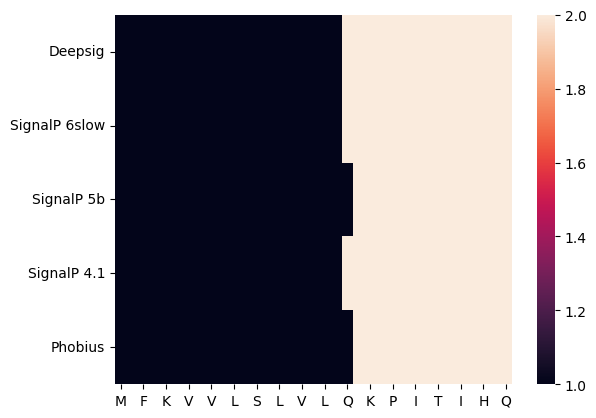

In [ ]:
char_to_int = {'S': 1, 'C': 0, 'O': 2, 'M': 3}
convert_to_integer_array = lambda x: np.array([char_to_int[i] for i in x])


row = df.T['MRFKKIVLVILCSTLQVILHQEKAPNILTTIQHFQ']
row = row.apply(convert_to_integer_array)
imdf = pd.DataFrame(index = [i for i in row.name])
for ix, row in row.items():
    imdf[ix] = row
sns.heatmap(imdf.T)

In [ ]:
px.imshow(imdf.T)

In [ ]:
row

'SSSSSSSSSSSSSSSSSSSSSOOOOOOOOOOOOOO'

In [ ]:
px.imshow(row.apply(convert_to_integer_array).values)

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [ ]:
df.loc['MRFKKIVLVILCSTLQVILHQEKAPNILTTIQHFQ']

Deepsig          SSSSSSSSSSSSSSSSSSSSOOOOOOOOOOOOOOO
SignalP 6slow    SSSSSSSSSSSSSSSSSSSSOOOOOOOOOOOOOOO
SignalP 5b       SSSSSSSSSSSSSSSSSSSSSOOOOOOOOOOOOOO
SignalP 4.1      SSSSSSSSSSSSSSSSSSSSOOOOOOOOOOOOOOO
Phobius          SSSSSSSSSSSSSSSSSSSSSOOOOOOOOOOOOOO
Name: MRFKKIVLVILCSTLQVILHQEKAPNILTTIQHFQ, dtype: object

In [ ]:
print('hi')

In [ ]:
from dashboard.app import *

In [ ]:
    input_file = './test_vtx.txt'#sys.argv[1]
    with open(input_file) as fhandle:
        ids = [int(i.replace('VTX-', '')) for i in fhandle.readlines()]
    # Query DB
    session = base.Session() # connect to db
    orfs = session.query(Orf).filter(Orf.id.in_(ids[::100]+[673319])).all()
    orfs = [OrfData(i) for i in orfs]
    missing_orfs = set(ids) - set([i.id for i in orfs])
    # if len(missing_orfs) > 0:
        # print('WARNING: some of the provided IDs were not found in veliadb.', *missing_orfs)

In [ ]:
        sum_expression_cancer = pd.DataFrame(pd.DataFrame([cancer_dataframe_per_transcript_dict[tid]['Cancer Average'] for tid in tids if len(cancer_dataframe_per_transcript_dict[tid])>0]).sum(axis=0), columns = ['Sum'])
        sum_expression_cancer['condition'] = 'Cancer'
        sum_expression_normal = pd.DataFrame(pd.DataFrame([cancer_dataframe_per_transcript_dict[tid]['GTEx Average'] for tid in  tids if len(cancer_dataframe_per_transcript_dict[tid])>0]).sum(axis=0), columns = ['Sum'])
        sum_expression_normal['condition'] = 'GTEx'
        de = pd.DataFrame([cancer_dataframe_per_transcript_dict[tid]['padj']<0.001 for tid in tids if len(cancer_dataframe_per_transcript_dict[tid])>0]).sum(axis=0)
        result = pd.concat([sum_expression_cancer, sum_expression_normal])#, '# DE Transcripts':de})
        result['TCGA'] = result.index
        result['# DE Transcripts'] = [de.loc[i] for i in result.index]

In [ ]:
list(new_df['Cancer'].values)

[0.68280286,
 313.34976,
 31.258528,
 70.325745,
 9.663325,
 611.9515,
 3.810155,
 168.0931,
 6.4587927,
 17.2023,
 1.8330371,
 2.505923,
 4.115969,
 3.508106,
 8.447077,
 28.318516,
 27.528933,
 1.5112278,
 19.575867,
 117.11811,
 14.005225,
 22.613775,
 545.16693,
 6.5105386,
 2.6331255,
 459.00186,
 10.07481,
 1.4261916,
 36.250904,
 7.697706,
 0.10556518]

In [ ]:
group_name = 'TCGA'
new_df = pd.DataFrame()
for g, subdf in result.groupby('condition'):
    new_df[g] = subdf['Sum']
new_df[group_name] = subdf[group_name]
new_df

,Cancer,GTEx,TCGA
ACC,0.682803,3.722827,ACC
BLCA,313.349760,362.208740,BLCA
BRCA,31.258528,11.201046,BRCA
CESC,70.325745,83.976920,CESC
CHOL,9.663325,16.666649,CHOL
COAD,611.951500,728.239750,COAD
DLBC,3.810155,0.195709,DLBC
ESCA,168.093100,87.624054,ESCA
GBM,6.458793,10.302282,GBM
HNSC,17.202300,93.200554,HNSC


In [ ]:
match

,Unnamed: 0,qName,qSize,matches,misMatches,tName,strand,tStart,tEnd,tStarts,blockCount,blockSizes,tSize,phase,reading_frame,phylocsf_58m_avg,phylocsf_58m_max,phylocsf_58m_min,phylocsf_58m_std,phylocsf_vals


In [ ]:
df.iloc[350]

Unnamed: 0                                                                                                                                                                                                             2846
qName                                                                                                                                                                                                           Phase_6_357
qSize                                                                                                                                                                                                                    69
matches                                                                                                                                                                                                                  69
misMatches                                                                                                              

In [ ]:
kibby = pd.read_csv('../../data/phase1to6_kibby.csv', index_col=0)
kibby['conservation'] = kibby.conservation.apply(lambda x: list(map(float, x.strip().split(' '))))
kibby = kibby.loc[sorf_excel['primary_id']]
kibby.index = sorf_excel['vtx_id']

In [ ]:
kibby

,sequence,conservation
vtx_id,,
VTX-0850284,APCCLWLLGAVLLMDASARPANHSSTRERVANREENEILPPDHLNGVKLEMDGHLNRGFHQEVFLGKDLGGFDEDAEPRRSRRKLMVIFSK,"[0.3888, 0.4164, 0.5156, 0.533, 0.4444, 0.5649, 0.449, 0.4587, 0.4183, 0.4015, 0.3755, 0.4526, 0.3839, 0.2809, 0.3314, 0.428, 0.2138, 0.6271, 0.4831, 0.5143, 0.3103, 0.2888, 0.3553, 0.3314, 0.2822..."
VTX-0850613,LARPALLLLLPLLAPLLGTGAPAELRVRVRLPDGQVTEESLQADSDADSISLELRKPDGTLVSFTADFKKVRRPHSPGWHLQA,"[0.4901, 0.2865, 0.4434, 0.3975, 0.2591, 0.3154, 0.3368, 0.349, 0.39, 0.4263, 0.3805, 0.3827, 0.3575, 0.2824, 0.4167, 0.3218, 0.3013, 0.3519, 0.3171, 0.4192, 0.3104, 0.4929, 0.3253, 0.2705, 0.3464..."
VTX-0850424,LMVLVFTIGLTLLLGVQAMPANRLSCYRKILKDHNCHNLPEGVADLTQIDVNVQDHFWDGKGCEMICYCNFSELLCCPK,"[0.4538, 0.3867, 0.264, 0.3383, 0.3185, 0.3408, 0.3118, 0.3386, 0.3361, 0.3705, 0.2495, 0.3197, 0.2553, 0.2224, 0.2017, 0.2628, 0.3301, 0.4482, 0.2333, 0.2307, 0.0644, 0.2543, 0.3895, 0.4455, 0.45..."
VTX-0850283,LEPMPKTMHFLFRFIVFFYLWGLFTAQRQKKEESTEEVKIEVLHRPENCSKTSKKGDLLNAHYDGYLAKDGSKFYCR,"[0.2693, 0.2221, 0.3023, 0.2895, 0.3111, 0.257, 0.279, 0.5378, 0.2982, 0.3982, 0.3092, 0.3238, 0.4127, 0.414, 0.3517, 0.3406, 0.4567, 0.3955, 0.2777, 0.3003, 0.388, 0.2478, 0.201, 0.3228, 0.1918, ..."
VTX-0849996,MKVWGLAAACFLLQHHGMPAQFTLPPAPRDETSPADAVCPGLGRDLCGSSRCCLRPPSQPDWKEPSGAALRARPAPRGR,"[0.6864, 0.4436, 0.4112, 0.6638, 0.3948, 0.4678, 0.422, 0.4304, 0.4256, 0.5807, 0.4933, 0.5006, 0.4672, 0.4201, 0.4146, 0.4933, 0.4045, 0.4677, 0.4186, 0.4997, 0.5587, 0.398, 0.3589, 0.3905, 0.528..."
...,...,...
VTX-0334036,MHLDKIWPLQFTVFLLHAVAASLSQVSCPSPPSI,"[0.5725, 0.4893, 0.4462, 0.4709, 0.4482, 0.4323, 0.6713, 0.514, 0.4358, 0.4792, 0.5139, 0.4114, 0.4457, 0.5356, 0.5255, 0.4632, 0.5837, 0.3804, 0.4214, 0.4164, 0.4178, 0.4617, 0.4711, 0.4735, 0.49..."
VTX-0772114,MHLLPWTFSSSWGLQMNLLLMHFMAFGGPPVDKYYT,"[0.5811, 0.5228, 0.5066, 0.4765, 0.554, 0.7124, 0.4531, 0.5668, 0.4495, 0.4055, 0.4665, 0.7235, 0.4648, 0.4291, 0.493, 0.4829, 0.5273, 0.508, 0.5198, 0.4987, 0.5002, 0.5895, 0.5898, 0.4889, 0.4396..."
VTX-0745409,MCLPTLAKALAGLWTVLIDHRIGQGGATSSC,"[0.6448, 0.6565, 0.4794, 0.6108, 0.4725, 0.531, 0.4446, 0.5429, 0.4405, 0.5564, 0.4807, 0.5096, 0.472, 0.7374, 0.5085, 0.51, 0.4983, 0.5654, 0.6595, 0.6689, 0.6568, 0.5005, 0.5197, 0.5144, 0.5175,..."


In [ ]:
sorf_table[sorf_table['aa']!='']

,chr,vtx,strand,start,end,nucl,aa,transcripts_exact,transcripts_overlapping
vtx,,,,,,,,,
VTX-0007082,chr11,VTX-0007082,-,93479010,93479189,CAGCTCAAAGGGAAGCCCAAGAAGGAGACCTCCAAGGACAAGAAGGAGCGGAAGCAAGCCATGCAGGAGGCCCGGCAGCAGATCACTACAGTGGTGCTGCCCACGCTGGCCGTGGTCGTGCTCTTGATCGTGGTGTTTGTGTACGTGGCCACGCGCCCCACCATCACCGAG,QLKGKPKKETSKDKKERKQAMQEARQQITTVVLPTLAVVVLLIVVFVYVATRPTITE,"[ENST00000525141, ENST00000298966, ENST00000527149, ENST00000596676]","[rna-XM_011542911, ENST00000525141, ENST00000596676, rna-XM_011542909, rna-XM_011542907, C, rna-XM_047427266, rna-XM_017018020, ENST00000298966, ENST00000527149, C]"
VTX-0007146,chr17,VTX-0007146,-,57744811,57745272,CCCCTCTACCAGGCTGGGTCCATTCTCATGACGGTGAATACCCTACAGGGGAAAAAAATGATAGAGAGTGGCCTCCAGTCTGGAGACTTTTCCCTGTCCCAGTCATGGCCCTCCTGCCTCCCACCACCCGCTGACTTGGAGATCCTGCAGCAGAAGGTGGCCGGGGTGCAACGGGAACTGGAGGACTTTAAGAAAG...,PLYQAGSILMTVNTLQGKKMIESGLQSGDFSLSQSWPSCLPPPADLEILQQKVAGVQRELEDFKKEALKSIHYLEDAFCEMNGALVQQEEQAARVRQRLREEEDRGIVRNKVLTFLLPREKQLREHCKRLEDLLLDRGRDALRATKKSQAD,[ENST00000299415],[ENST00000299415]
VTX-0007396,chr19,VTX-0007396,-,54465101,54465547,GTGCTGAAGCAGCTGGGCCCCGCGCAGCCCAAGAAGCGGCCTGATCGCGGCGCCCTGTCCATCTCCGCGCCGCTCGGCGACTTCCGGCACACGCTGCACGTGGGGCGCGGCGGCGACGCCTTCGGGGACACCTCGTTCCTGAGCCGCCACGGCGGCGGGCCGCCCCCCGAGCCCCGGGCGCCCCCCGCGGGGGCCC...,VLKQLGPAQPKKRPDRGALSISAPLGDFRHTLHVGRGGDAFGDTSFLSRHGGGPPPEPRAPPAGAPRSPPPPAVPQSAAPSPADPLLSFHLDLGPSMLDAVLGVMDAARPEAAAAKPDAEPRPGTQPPQARCRPNADLELNDVIGL,[ENST00000301200],"[ENST00000301200, C]"
VTX-0007541,chr1,VTX-0007541,+,160370732,160371133,ATGATGCTCAACTCAGACACCATGGAGCTGGACCTGCCGCCCACCCACTCAGAGACTGAGTCGGGCTTCAGTGACTGTGGGGGCGGGGCGGGCCCTGATGGTGCCGGGCCTGGGGGTCCGGGAGGGGGCCAGGCCCGAGGCCCAGAGCCGGGAGAGCCTGGCCGGAAAGACCTGCAGCATCTGAGCCGCGAGGAGC...,MMLNSDTMELDLPPTHSETESGFSDCGGGAGPDGAGPGGPGGGQARGPEPGEPGRKDLQHLSREERRRRRRATAKYRTAHATRERIRVEAFNLAFAELRKLLPTLPPDKKLSKIEILRLAICYISYLNHVLDV,[ENST00000302101],[ENST00000302101]
VTX-0009335,chr14,VTX-0009335,+,20747581,20748024,ATGACATCCTCTCTAAAGATTTGGGGCATACTCTTGGCCCTGCTTTGCATCCTTTGCAGGCTGTGTGTATACAGTAACAACATTTACTGGAGAGAATTCATAAAACTTCATTACTTAAGTCCAAGTCGAGAATTCAAAGAGTACAAATGTGATGTCCTCATGAGAGAAAAAGAGGCTCTGAAAGGCAAGAGCTTTC...,MTSSLKIWGILLALLCILCRLCVYSNNIYWREFIKLHYLSPSREFKEYKCDVLMREKEALKGKSFHMFIYSLWFKIQRACINEKGSDRYRNAYVWAPGALKVLECHWEKYNNRYTESRSFSYIEFHCGVDGYVDNIEDLRIIEPISN,[ENST00000326842],"[ENST00000326842, rna-XM_017020934, C]"
...,...,...,...,...,...,...,...,...,...
VTX-0852222,chr22,VTX-0852222,+,50546244,50547660,ATGATCCAGGGCACCTTGGAGCCAGATGGTCCCCTCTGGGGCTGGGACTGGGACAGTGACAATGACTGGGATAGTGCTGTGCTGGCCCTCCTGGCGCTGGCTGTGGTGGCTGCCACAGCGCTGGCCTTACACTGGTTTGGCTCCGGGCACGATCAAGAGGCGGCAGAACCGGTGTCCACAGCCCTCGGGGCTCAAC...,MIQGTLEPDGPLWGWDWDSDNDWDSAVLALLALAVVAATALALHWFGSGHDQEAAEPVSTALGAQPHQAGGAELALQPKSKTFCPWRLPRILPWAKISERRQPQVQPQPKS,[],[ENST00000648057]
VTX-0852229,chr12,VTX-0852229,-,11047148,11171599,ATGCTGGCCCCGGAGGCCGTTAGCTTAGTCATGGCTCTAAATATGTACCTGCAATCGGATGTTGAGGATCACCGAGCCCGCGACGTAGAAGTACGGGAAGTTCATGCGCAGCTGCCAGGCCAGCTCGAAGAAGGCGAGCAGGGTGCGGGAGAGCCCCTTGCAGAAGACGCCGTACGAG CAGCATTTGGCTCAAGG...,MLAPEAVSLVMALNMYLQSDVEDHRARDVEVREVHAQLPGQLEEGEQGAGEPLAEDAVRAAFGSRPQGHM,[],"[rna-NR_037918, rna-NR_133575, rna-NM_001291315, rna-NM_001291314, rna-NM_001316893, ENST00000546265, ENST00000535024, C]"
VTX-0852274,chr9,VTX-0852274,-,111626950,111627171,TCAAAAGAAGAGAAAACAGAGGCACAAGAGAAGATGACCACAGAAGACAGAGGCAGAGGCTGGGGTTATGCTACCACAAACCGGAGAATGCCAAGGATTGCTGGCAACCACCAGGAGCCTGGGGAGAGGCGTGGAACCCCTCCTCCCTCAGAGGCCCCAGAAGGATCCAACCCTGCTAATACCTTGATTTTAGACT...,SKEEKTEAQEKMTTEDRGRGWGYATTNRRMPRIAGNHQEPGERRGTPPPSEAPEGSNPANTLILDFPPPEL,[],"[ENST00000374304, rna-XR_001746897]"


In [ ]:
phase1to5 = pd.read_table('s3://velia-data-dev/VDC_001_screening_collections/primary/phase1-5_aa_seqs_harmonized_phylocsf.tsv')
phase6 = pd.read_csv('s3://velia-analyses-dev/VAP_20230327_phase1to6_secreted/data/phase_6_phylocsf.csv')
phylocsf = pd.concat((phase1to5, phase6))
set(phylocsf['qName']).difference(sorf_excel['primary_id'])

{'smORF502740',
 'c1riboseqorf145',
 'AXIN1/ENST00000481769.1/ncRNA/-',
 'c5riboseqorf129',
 'FZD3',
 'NP1L6_HUMAN;NAP1L6P;A6NFF2',
 'c2riboseqorf64',
 'LINC00960',
 'c5norep112',
 'smORF492548',
 'RibORF_SS_141',
 'IGIP_HUMAN;IGIP;A6NJ69',
 'F215A_HUMAN;FAM215A;Q9Y5M1',
 'IF5AL_HUMAN;EIF5AL1;Q6IS14',
 'smORF308450',
 'IP_148173',
 'ENSG00000146938_6228688_GENE_ID=FTMT28900029591_57_177_TYPE=protein_coding_LEN=39',
 'Phase_6_372',
 'smORF105546',
 'Phase_6_290',
 'CN070_HUMAN;LINC00523;Q86TU6',
 'IP_159930|chr7:47761480-47763510+;OpenProt_ORF146405;IP_159930',
 'HNF1A/ENST00000535955.5/ncRNA/-,',
 'SCGR8_HUMAN;SCYGR8;A0A286YFG1;SCYGR8',
 'HOXC-AS3/ENST00000567780.1/ncRNA/-',
 'SMAD4/ENST00000591126.5/ncRNA/-,',
 'IP_657533|chr22:23695136-23705476-;OpenProt_ORF473930;IP_657533',
 'SEHBP',
 'AOC4P/ENST00000585538.1/ncRNA/-,',
 'c21norep62',
 'RECK8_HUMAN;ERVK-8;P61575',
 'LOC101927760/XR_001747603.1/ncRNA/-,',
 "DNAJB1/XM_011527956.3/mRNA/3'UTR,",
 'IP_3394158|chr6:31174006-31177799-;Ope

In [ ]:
    session = boto3.Session()
    s3 = session.resource('s3')
    my_bucket = s3.Bucket('velia-analyses-dev')


In [ ]:
tcga_cancer_codes = ['ACC', 'OV']
bucket = 'velia-analyses-dev'
object_prefix = 'VAP_20230329_tcga_differential_expression/deseq_output'

session = boto3.Session()
s3 = session.resource('s3')
my_bucket = s3.Bucket(bucket)

cancer_de_results = {}
for f in my_bucket.objects.filter(Prefix=object_prefix):
    fname = f.key
    if fname.endswith('.csv'):
        cancer_de_results[fname.split('/')[-1].split('_')[0]] = fname
if tcga_cancer_codes is None:
    tcga_cancer_codes = cancer_de_results.keys()
tables = {}
for c in tqdm(tcga_cancer_codes):
    if c in cancer_de_results.keys():
        table = pd.read_csv(f"s3://{bucket}/{cancer_de_results[c]}")
        tables[c] = table    
    else:
        print(f"{c} not found in results")
tables['ACC']

,sample,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Cancer Mean,GTEx Mean
0,ENST00000548312.5,2.052087,-0.491098,0.329051,-1.492471,1.355757e-01,1.854216e-01,2.503687,1.776109
1,ENST00000483781.5,1.655928,1.713394,0.525082,3.263096,1.102021e-03,2.232559e-03,0.710358,2.233776
2,ENST00000535093.1,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
3,ENST00000338863.11,326.249240,1.612421,0.143864,11.207924,3.728342e-29,4.426477e-28,143.136870,438.151250
4,ENST00000570899.1,1.968687,0.292934,0.360288,0.813054,4.161871e-01,4.896118e-01,1.700522,2.132566
...,...,...,...,...,...,...,...,...,...
198614,ENST00000402231.1,0.003714,0.209218,3.016025,0.069369,9.446962e-01,NaN,0.009791,0.000000
198615,ENST00000463473.2,0.516627,0.167536,0.617976,0.271104,7.863111e-01,8.275736e-01,0.455059,0.554253
198616,ENST00000380293.3,2.363100,1.623544,0.294589,5.511226,3.563430e-08,1.168073e-07,1.235040,3.052471
198617,ENST00000288710.6,2.122495,-0.091203,0.349696,-0.260808,7.942407e-01,8.340809e-01,2.264438,3.200530


In [ ]:
def read_tcga_de_from_s3(bucket, object_prefix, output_dir = None,
                         tcga_cancer_codes = None):
    session = boto3.Session()
    s3 = session.resource('s3')
    my_bucket = s3.Bucket(bucket)
    
    cancer_de_results = {}
    for f in my_bucket.objects.filter(Prefix=object_prefix):
        fname = f.key
        if fname.endswith('.csv'):
            cancer_de_results[fname.split('/')[-1].split('_')[0]] = fname
    if tcga_cancer_codes is None:
        tcga_cancer_codes = cancer_de_results.keys()
    tables = {}
    for c in tqdm(tcga_cancer_codes):
        if c in cancer_de_results.keys():
            table = pd.read_csv(f"s3://{bucket}/{cancer_de_results[c]}", index_col=0)
            table.index = [i.split('.')[0] for i in table.index]
            table = table[~table.index.duplicated(keep='first')]
            if not output_dir is None:
                table.to_parquet(f"{output_dir}/{c}_de.parq")
            tables[c] = table    
        else:
            print(f"{c} not found in results")
    return tables
    
de_genes = read_tcga_de_from_s3('velia-analyses-dev',
                 'VAP_20230329_tcga_differential_expression', output_dir = OUTPUT_DIR)

100%|██████████| 32/32 [00:59<00:00,  1.85s/it]


In [ ]:
# Create table of transcript by DE in each cancer for all transcripts in sorf set.
sorf_table = load_jsonlines_table('../../cache/sorf_table.jsonlines', index_col='vtx')
transcripts = np.concatenate([*sorf_table['transcripts_exact'].values, *sorf_table['transcripts_overlapping'].values])
for cancer_type, de_table in tqdm(de_genes_dict.items()):
    overlap = de_table.index.intersection(transcripts)
    d = de_table.loc[overlap]
    break

  0%|          | 0/32 [00:00<?, ?it/s]


In [ ]:
sorf_table.head(4)

,chr,vtx,strand,start,end,nucl,aa,transcripts_exact,transcripts_overlapping
vtx,,,,,,,,,
VTX-0007082,chr11,VTX-0007082,-,93479010,93479189,CAGCTCAAAGGGAAGCCCAAGAAGGAGACCTCCAAGGACAAGAAGGAGCGGAAGCAAGCCATGCAGGAGGCCCGGCAGCAGATCACTACAGTGGTGCTGCCCACGCTGGCCGTGGTCGTGCTCTTGATCGTGGTGTTTGTGTACGTGGCCACGCGCCCCACCATCACCGAG,QLKGKPKKETSKDKKERKQAMQEARQQITTVVLPTLAVVVLLIVVFVYVATRPTITE,"[ENST00000525141, ENST00000298966, ENST00000527149, ENST00000596676]","[rna-XM_011542911, ENST00000525141, ENST00000596676, rna-XM_011542909, rna-XM_011542907, C, rna-XM_047427266, rna-XM_017018020, ENST00000298966, ENST00000527149, C]"
VTX-0007146,chr17,VTX-0007146,-,57744811,57745272,CCCCTCTACCAGGCTGGGTCCATTCTCATGACGGTGAATACCCTACAGGGGAAAAAAATGATAGAGAGTGGCCTCCAGTCTGGAGACTTTTCCCTGTCCCAGTCATGGCCCTCCTGCCTCCCACCACCCGCTGACTTGGAGATCCTGCAGCAGAAGGTGGCCGGGGTGCAACGGGAACTGGAGGACTTTAAGAAAG...,PLYQAGSILMTVNTLQGKKMIESGLQSGDFSLSQSWPSCLPPPADLEILQQKVAGVQRELEDFKKEALKSIHYLEDAFCEMNGALVQQEEQAARVRQRLREEEDRGIVRNKVLTFLLPREKQLREHCKRLEDLLLDRGRDALRATKKSQAD,[ENST00000299415],[ENST00000299415]
VTX-0007396,chr19,VTX-0007396,-,54465101,54465547,GTGCTGAAGCAGCTGGGCCCCGCGCAGCCCAAGAAGCGGCCTGATCGCGGCGCCCTGTCCATCTCCGCGCCGCTCGGCGACTTCCGGCACACGCTGCACGTGGGGCGCGGCGGCGACGCCTTCGGGGACACCTCGTTCCTGAGCCGCCACGGCGGCGGGCCGCCCCCCGAGCCCCGGGCGCCCCCCGCGGGGGCCC...,VLKQLGPAQPKKRPDRGALSISAPLGDFRHTLHVGRGGDAFGDTSFLSRHGGGPPPEPRAPPAGAPRSPPPPAVPQSAAPSPADPLLSFHLDLGPSMLDAVLGVMDAARPEAAAAKPDAEPRPGTQPPQARCRPNADLELNDVIGL,[ENST00000301200],"[ENST00000301200, C]"
VTX-0007541,chr1,VTX-0007541,+,160370732,160371133,ATGATGCTCAACTCAGACACCATGGAGCTGGACCTGCCGCCCACCCACTCAGAGACTGAGTCGGGCTTCAGTGACTGTGGGGGCGGGGCGGGCCCTGATGGTGCCGGGCCTGGGGGTCCGGGAGGGGGCCAGGCCCGAGGCCCAGAGCCGGGAGAGCCTGGCCGGAAAGACCTGCAGCATCTGAGCCGCGAGGAGC...,MMLNSDTMELDLPPTHSETESGFSDCGGGAGPDGAGPGGPGGGQARGPEPGEPGRKDLQHLSREERRRRRRATAKYRTAHATRERIRVEAFNLAFAELRKLLPTLPPDKKLSKIEILRLAICYISYLNHVLDV,[ENST00000302101],[ENST00000302101]


In [ ]:
del de_genes_dict['expression']

In [ ]:
de_table_dict = de_genes_dict.copy()

In [ ]:
    from collections import defaultdict
    cancer_dataframe_per_transcript_dict = defaultdict(dict)
    for c, df in tqdm(de_table_dict.items()):
        for row in df.itertuples():
            cancer_dataframe_per_transcript_dict[row[0]][c] = {'Cancer Average': row._7, 'GTEx Average': row._8, 
                                                               'log2FC': row.log2FoldChange, 'padj': row.padj}
    for t, d in cancer_dataframe_per_transcript_dict.items():
        cancer_dataframe_per_transcript_dict[t] = pd.DataFrame(d).T
    print('done')
            # break

100%|██████████| 31/31 [00:13<00:00,  2.28it/s]


done


In [ ]:
exp[exp.columns.intersection(transcripts)].T

,ACH-000001,ACH-000002,ACH-000003,ACH-000004,ACH-000005,ACH-000006,ACH-000007,ACH-000008,ACH-000009,ACH-000011,ACH-000012,ACH-000013,ACH-000014,ACH-000015,ACH-000016,ACH-000017,ACH-000018,ACH-000019,ACH-000020,ACH-000021,ACH-000022,ACH-000023,ACH-000024,ACH-000025,ACH-000026,ACH-000027,ACH-000028,ACH-000029,ACH-000030,ACH-000031,ACH-000032,ACH-000033,ACH-000034,ACH-000035,ACH-000036,ACH-000037,ACH-000038,ACH-000039,ACH-000040,ACH-000041,ACH-000042,ACH-000043,ACH-000044,ACH-000045,ACH-000046,ACH-000048,ACH-000049,ACH-000050,ACH-000051,ACH-000052,...,ACH-002039,ACH-002040,ACH-002041,ACH-002042,ACH-002044,ACH-002045,ACH-002046,ACH-002048,ACH-002055,ACH-002059,ACH-002061,ACH-002062,ACH-002065,ACH-002066,ACH-002067,ACH-002069,ACH-002080,ACH-002084,ACH-002446,ACH-002458,ACH-002459,ACH-002460,ACH-002461,ACH-002462,ACH-002463,ACH-002464,ACH-002465,ACH-002466,ACH-002467,ACH-002471,ACH-002475,ACH-002508,ACH-002509,ACH-002510,ACH-002511,ACH-002512,ACH-002647,ACH-002659,ACH-002664,ACH-002669,ACH-002672,ACH-002680,ACH-002687,ACH-002693,ACH-002710,ACH-002785,ACH-002800,ACH-002834,ACH-002847,ACH-002926
ENST00000341776,1.963474,0.823749,1.438293,2.503349,3.007196,4.890933,1.257011,3.119356,2.140779,1.490570,2.275007,1.843984,4.011675,1.339137,1.531069,2.353323,1.316146,3.467279,4.046142,1.327687,1.084064,2.508429,1.989139,1.304511,1.049631,1.761285,2.989139,2.384050,3.294253,3.518535,3.832890,1.327687,2.786596,1.970854,1.411426,3.232661,0.695994,4.759156,3.410070,4.322649,1.416840,1.815575,2.097611,1.851999,0.584963,1.275007,1.516015,2.485427,1.933573,3.719183,...,2.845992,3.077243,2.147307,2.939227,2.039138,2.572890,2.908813,2.636915,1.906891,4.771886,3.388190,2.235727,2.204767,4.292045,2.063503,1.948601,3.694880,2.849999,0.903038,3.593354,2.797013,4.211791,2.823749,2.541019,2.025029,2.430285,2.746313,1.687061,1.918386,1.996389,2.283922,3.160275,3.942984,2.035624,4.552746,3.025029,2.042644,1.182692,1.963474,3.047887,1.495695,2.400538,0.704872,1.700440,1.974529,3.215679,2.060047,2.283922,3.058316,1.855990
ENST00000397311,2.111031,3.135863,2.289834,3.692650,3.891419,3.572890,1.526069,2.639232,2.147307,1.903038,2.042644,1.887525,2.903038,2.669027,1.608809,3.231125,2.124328,3.663345,3.659925,2.104337,1.650765,3.060047,1.521051,2.204767,1.944858,2.104337,2.875780,1.448901,3.214125,3.112700,4.155425,2.229588,3.012569,0.941106,2.176323,2.272023,1.014355,4.032101,2.066950,3.339137,1.704872,1.570463,1.978196,3.364572,1.344828,1.989139,2.464668,2.505891,2.462052,3.030336,...,2.301588,3.678072,1.500802,1.790772,2.321928,2.653060,2.405992,2.505891,1.238787,2.786596,2.735522,1.757023,1.389567,1.996389,2.063503,1.978196,2.929791,2.639232,1.077243,2.451541,1.925999,2.292782,1.855990,1.691534,1.604071,1.157044,1.427606,1.298658,1.035624,1.090853,1.941106,2.526069,2.765535,2.589763,3.017922,2.625270,1.427606,1.863938,2.003602,1.933573,1.545968,0.704872,2.000000,1.195348,1.097611,1.007196,1.150560,1.356144,2.250962,1.490570
ENST00000357618,0.739848,0.028569,1.541019,0.056584,0.226509,0.124328,1.757023,3.051372,1.646163,2.715893,0.422233,0.070389,3.201634,1.811471,3.249445,0.028569,1.952334,0.286881,1.007196,1.863938,1.847997,1.361768,0.056584,2.253989,2.523562,3.104337,0.565597,0.056584,3.291309,1.269033,0.356144,2.541019,0.000000,2.446256,3.574102,1.636915,1.077243,0.731183,3.495695,1.786596,2.100978,2.232661,0.014355,0.014355,3.155425,2.925999,2.217231,0.028569,2.655352,1.859970,...,1.169925,0.895303,1.367371,1.427606,1.049631,1.974529,2.121015,1.201634,0.137504,0.321928,0.275007,0.378512,2.304511,1.811471,1.021480,0.879706,0.000000,2.137504,0.226509,3.462052,3.892391,3.403268,2.035624,2.464668,1.989139,2.521051,1.811471,1.778209,2.555816,0.042644,0.000000,1.967169,2.405992,2.575312,1.589763,1.411426,3.207893,0.903038,2.310340,1.799087,2.361768,2.618239,0.000000,0.014355,3.452859,0.000000,1.526069,2.189034,0.000000,0.641546
ENST00000572258,0.871844,0.000000,1.367371,1.169925,0.879706,0.505891,1.673556,1.655352,1.327687,1.883621,0.863938,0.669027,1.752749,1.

In [ ]:
transcripts_to_keep = []
# exp = pd.read_parquet('s3://velia-analyses-dev/VAP_20230510_CCLE_DepMap/output/depmap_cellLine_transcript_expression_log1p_tpm.parq')
md_columns = exp.columns[:7]
exp.head(4)

,CCLEName,CellLineName,OncotreePrimaryDisease,TreatmentStatus,Sex,PrimaryOrMetastasis,GrowthPattern,Age,ENST00000373020,ENST00000494424,ENST00000496771,ENST00000612152,ENST00000614008,ENST00000373031,ENST00000485971,ENST00000371582,ENST00000371584,ENST00000371588,ENST00000413082,ENST00000466152,ENST00000494752,ENST00000681979,ENST00000682366,ENST00000682713,ENST00000682754,ENST00000683010,ENST00000683048,ENST00000683466,ENST00000684193,ENST00000684628,ENST00000684708,ENST00000367770,ENST00000367771,ENST00000367772,ENST00000423670,ENST00000470238,ENST00000286031,ENST00000359326,ENST00000413811,ENST00000459772,ENST00000466580,ENST00000472795,ENST00000481744,ENST00000496973,ENST00000498289,ENST00000374003,ENST00000374004,ENST00000374005,ENST00000399173,ENST00000457296,...,ENST00000680700,ENST00000659063,ENST00000680407,ENST00000680408,ENST00000680692,ENST00000681845,ENST00000460895,ENST00000467013,ENST00000467708,ENST00000472904,ENST00000682319,ENST00000683452,ENST00000684049,ENST00000682501,ENST00000682525,ENST00000682662,ENST00000683161,ENST00000683353,ENST00000683519,ENST00000684112,ENST00000684596,ENST00000684694,ENST00000684736,ENST00000482026,ENST00000682415,ENST00000681994,ENST00000373414,ENST00000684747,ENST00000369505,ENST00000526209,ENST00000683988,ENST00000682732,ENST00000684114,ENST00000684541,ENST00000683807,ENST00000682976,ENST00000683950,ENST00000684511,ENST00000683405,ENST00000684015,ENST00000682224,ENST00000682011,ENST00000684202,ENST00000682596,ENST00000683313,ENST00000684631,ENST00000610495,ENST00000684005,ENST00000683399,ENST00000684388
ACH-000001,NIHOVCAR3_OVARY,NIH:OVCAR-3,Ovarian Epithelial Tumor,None,Female,Metastatic,Adherent,60.0,4.913608,0.0,2.117695,0.056584,1.933573,0.0,0.000000,4.177121,3.683696,7.024142,0.731183,2.073820,0.000000,1.695994,1.356144,1.803227,1.269033,1.292782,2.533563,0.000000,0.613532,2.053111,0.163499,0.000000,1.372952,1.416840,0.000000,0.070389,0.565597,2.121015,1.220330,2.217231,0.0,0.485427,1.150560,3.023255,0.056584,0.0,0.000000,0.000000,0.000000,0.042644,...,0.000000,0.0,0.0,0.584963,0.0,0.137504,0.0,0.000000,0.0,0.0,0.000000,0.097611,0.000000,3.121015,0.0,1.077243,4.646739,3.684819,4.056584,3.114367,3.344828,1.042644,4.830864,0.000000,0.000000,0.084064,0.000000,0.263034,0.000000,0.855990,1.713696,0.000000,0.0,0.0,0.0,0.042644,0.0,0.0,0.389567,0.263034,0.028569,0.485427,0.028569,0.214125,0.432959,0.000000,4.873813,0.000000,0.0,0.0
ACH-000002,HL60_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,HL-60,Acute Myeloid Leukemia,None,Female,Primary,Suspension,36.0,0.056584,0.0,0.000000,0.000000,0.137504,0.0,0.000000,2.467279,2.214125,5.295356,0.000000,0.622930,0.584963,0.641546,0.773996,0.799087,0.070389,0.226509,1.063503,0.000000,0.163499,0.176323,0.000000,0.263034,0.956057,0.275007,0.000000,0.028569,0.367371,0.000000,2.104337,1.565597,0.0,0.575312,0.000000,1.333424,0.176323,0.0,3.351911,2.513491,1.070389,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.111031,0.000000,0.000000,0.731183,0.0,1.207893,4.017031,0.722466,1.070389,2.077243,1.117695,0.941106,1.400538,0.000000,0.000000,0.070389,0.000000,0.000000,0.879706,0.389567,0.731183,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.014355,0.014355,0.014355,0.189034,0.042644,0.000000,3.488001,0.000000,0.0,0.0
ACH-000003,CACO2_LARGE_INTESTINE,CACO2,Colorectal Adenocarcinoma,Unknown,Male,Primary,Adherent,72.0,5.159468,0.0,1.650765,0.056584,1.454176,0.0,0.084064,3.672425,2.678072,7.593951,0.389567,1.321928,0.084064,1.495695,1.042644,1.207893,1.090853,0.704872,3.493135,0.000000,0.555816,1.137504,0.000000,0.000000,1.077243,1.111031,0.226509,0.298658,0.321928,0.933573,1.664483,1.748461,0.0,0.344828,0.985500,2.963474,0.189034,0.0,0.000000,0.000000,0.000000,0.000000,...,0.014355,0.0,0.0,0.176323,0.0,0.000000,0.0,0.137504,0.0,0.0,0.000000,0.000000,0.000000,1.356144,0.0,2.319040,3.827819,2.350497,2.700440,1.929791,1.664483,0.378512,3.294253,0.163499,0.028569,0.163499,0.070389,0.176323,0.000000,0.790772,2.298658,0.124328,0.0,

In [ ]:
sum_expression_normal

ACC           3.722827
BLCA         362.20874
BRCA         11.201046
CESC          83.97692
CHOL         16.666649
COAD         728.23975
DLBC          0.195709
ESCA         87.624054
GBM          10.302282
HNSC         93.200554
KICH          47.44859
KIRC           67.2531
KIRP         52.503246
LGG          12.820874
LIHC          23.03676
LUAD          1.858003
LUSC          1.893499
MESO          1.412708
OV            3.785946
PAAD          3.426991
PCPG          4.711389
PRAD         22.666285
READ          644.7146
SARC          0.291456
SKCM         29.556978
STAD         1842.9774
TGCT         16.861895
THCA          2.665732
UCEC          1.919775
UCS           1.636138
UVM          28.256285
condition         GTEx
dtype: object

In [ ]:
%matplotlib notebook

In [ ]:
result['# DE Transcripts'] = [de.loc[i] for i in result.index]
result

,Sum,condition,TCGA,# DE Transcripts
ACC,0.682803,Cancer,ACC,1
BLCA,313.349760,Cancer,BLCA,0
BRCA,31.258528,Cancer,BRCA,1
CESC,70.325745,Cancer,CESC,0
CHOL,9.663325,Cancer,CHOL,1
COAD,611.951500,Cancer,COAD,0
DLBC,3.810155,Cancer,DLBC,0
ESCA,168.093100,Cancer,ESCA,1
GBM,6.458793,Cancer,GBM,1
HNSC,17.202300,Cancer,HNSC,1


In [ ]:
import plotly.express as px
import plotly.graph_objects as go

fig = px.bar(result, x='TCGA', y='Sum', color='condition', barmode='group')
fig.add_trace(go.Scatter(
    x=result['TCGA'],
    y=result['Sum'],
    mode="text",
    name="# DE Transcripts",
    text=result['# DE Transcripts'],
    textposition="top center",
    showlegend=False
))
fig.show()

In [ ]:
cancer_dataframe_per_transcript_dict[tids[0]]

{}

In [ ]:
pd.DataFrame([cancer_dataframe_per_transcript_dict[tid]['Cancer Average'] for tid in tids if len(cancer_dataframe_per_transcript_dict[tid])>0])

,ACC,BLCA,BRCA,CESC,CHOL,COAD,DLBC,ESCA,GBM,HNSC,KICH,KIRC,KIRP,LGG,LIHC,LUAD,LUSC,MESO,OV,PAAD,PCPG,PRAD,READ,SARC,SKCM,STAD,TGCT,THCA,UCEC,UCS,UVM
Cancer Average,1.83895,3.12874,4.438456,3.363624,3.036772,2.225986,0.983176,5.893814,2.458831,1.205954,2.634917,8.396885,4.483231,2.968592,1.359554,4.553573,3.926327,3.07275,3.387915,2.657227,2.989669,4.996391,1.424682,2.341797,1.532364,4.340596,1.904935,5.305129,3.17766,1.977879,1.343376


In [ ]:
tids = sorf_table.loc['VTX-0539915', 'transcripts_exact']
sum_expression_cancer = pd.DataFrame(pd.DataFrame([cancer_dataframe_per_transcript_dict[tid]['Cancer Average'] for tid in tids if len(cancer_dataframe_per_transcript_dict[tid])>0]).sum(axis=0), columns = ['Sum'])
sum_expression_cancer['condition'] = 'Cancer'
sum_expression_normal = pd.DataFrame(pd.DataFrame([cancer_dataframe_per_transcript_dict[tid]['GTEx Average'] for tid in  tids if len(cancer_dataframe_per_transcript_dict[tid])>0]).sum(axis=0), columns = ['Sum'])
sum_expression_normal['condition'] = 'GTEx'
de = pd.DataFrame([cancer_dataframe_per_transcript_dict[tid]['padj']<0.001 for tid in tids if len(cancer_dataframe_per_transcript_dict[tid])>0]).sum(axis=0)
result = pd.concat([sum_expression_cancer, sum_expression_normal])#, '# DE Transcripts':de})
result['TCGA'] = result.index
result

,Sum,condition,TCGA
ACC,1.838950,Cancer,ACC
BLCA,3.128740,Cancer,BLCA
BRCA,4.438456,Cancer,BRCA
CESC,3.363624,Cancer,CESC
CHOL,3.036772,Cancer,CHOL
COAD,2.225986,Cancer,COAD
DLBC,0.983176,Cancer,DLBC
ESCA,5.893814,Cancer,ESCA
GBM,2.458831,Cancer,GBM
HNSC,1.205954,Cancer,HNSC


In [ ]:
df = result

In [ ]:
import altair as alt

In [ ]:
# Define the bar plot using Altair
chart = alt.Chart(df).mark_bar().encode(
    x='TCGA',
    y='Cancer',
    color=alt.value('orange'),  # Set the color of the "Cancer" bars
    opacity=alt.value(0.7),     # Set the opacity of the bars
)
chart.show()
# # Set the chart title and axis labels
# chart = chart.properties(
#     title='Comparison of Cancer and GTEx',
#     width=600,
#     height=400
# ).configure_axis(
#     labelFontSize

NoMatchingVersions: No matches for version='5.8.0' among ['4.0.2', '4.8.1', '4.17.0'].
Often this can be fixed by updating altair_viewer:
    pip install -U altair_viewer

In [ ]:
import streamlit as st

In [ ]:
st.bar_chart(result, x='TCGA', y= 'Cancer')

2023-06-22 20:51:54.663 
  command:

    streamlit run /home/ec2-user/anaconda/envs/veliadash/lib/python3.11/site-packages/ipykernel_launcher.py [ARGUMENTS]


DeltaGenerator()

In [ ]:
vtx_id = 'VTX-0735052'
subset = exp[list(md_columns)+sorf_table.loc[vtx_id, 'transcripts_exact']].copy()
subset['Sum Exact Match'] = exp[sorf_table.loc[vtx_id, 'transcripts_exact']].sum(axis=1)
subset['Sum Overlapping Match'] = exp[[i for i in sorf_table.loc[vtx_id, 'transcripts_overlapping'] if i in exp.columns]].sum(axis=1)

In [ ]:
vtx_id = 'VTX-0085840'
sorf_table.loc[vtx_id, 'transcripts_exact']

['ENST00000581851']

In [ ]:
OUTPUT_DIR = '../../cache'

In [ ]:
NCPU = 2

In [ ]:
from collections import Counter

In [ ]:
transcript_matching_results.keys()

NameError: name 'transcript_matching_results' is not defined

In [ ]:
NCPU = 1

In [ ]:
orfs[3].id

673319

In [ ]:
compute_exact_transcript_matches(orfs[3])

(673319,
 'ATGCAAAGCTCTTCAAAGGAGACCTATAAAGTCATCTTTGTTTTGTTCATTCTTCTCATGTTTCTGCATTCTGGGCATTCTCCTAAATTGGGGAGAAACCAAAATGCCCAGAAGTCAAATTCTGCAACTGTCATCATGCAAAATGTCAAA',
 'MQSSSKETYKVIFVLFILLMFLHSGHSPKLGRNQNAQKSNSATVIMQNVK',
 ['ENST00000472890',
  'ENST00000662289',
  'ENST00000498005',
  'ENST00000665197',
  'ENST00000664180'])

In [ ]:
def compute_exact_transcript_matches(o):
    nt, aa = extract_nucleotide_sequence_veliadb(o, reference)
    r_internal = find_seq_substring(nt, transcripts)
    return o.id, nt, aa, [i.split('|')[0].split('.')[0] for i in r_internal]

def run_id_mapping_parallel(orfs, NCPU = None):
    import multiprocessing as mp
    results = {}
    if NCPU is None:
        NCPU = mp.cpu_count()
    if NCPU > 1:
        with mp.Pool(NCPU) as ppool:            
            for r0 in tqdm(ppool.imap(compute_exact_transcript_matches, orfs), total=len(orfs)):
                results[r0[0]] = r0[1:]
    else:
        for o in tqdm(orfs):
            r = compute_exact_transcript_matches(o)
            results[r[0]] = r[1:]
    return results

('ATGCAAAGCTCTTCAAAGGAGACCTATAAAGTCATCTTTGTTTTGTTCATTCTTCTCATGTTTCTGCATTCTGGGCATTCTCCTAAATTGGGGAGAAACCAAAATGCCCAGAAGTCAAATTCTGCAACTGTCATCATGCAAAATGTCAAA',
 'MQSSSKETYKVIFVLFILLMFLHSGHSPKLGRNQNAQKSNSATVIMQNVK',
 ['ENST00000305366', 'ENST00000484019', 'ENST00000462519'])

In [ ]:
transcript_matching_results = run_id_mapping_parallel(orfs, NCPU = 1)
transcript_matching_results[673319]

100%|██████████| 9/9 [00:30<00:00,  3.41s/it]


('ATGCAAAGCTCTTCAAAGGAGACCTATAAAGTCATCTTTGTTTTGTTCATTCTTCTCATGTTTCTGCATTCTGGGCATTCTCCTAAATTGGGGAGAAACCAAAATGCCCAGAAGTCAAATTCTGCAACTGTCATCATGCAAAATGTCAAA',
 'MQSSSKETYKVIFVLFILLMFLHSGHSPKLGRNQNAQKSNSATVIMQNVK',
 ['ENST00000472890',
  'ENST00000662289',
  'ENST00000498005',
  'ENST00000665197',
  'ENST00000664180'])

In [ ]:
    transcript_matching_results = run_id_mapping_parallel(orfs, NCPU = NCPU) # implemented for multithreading but had issues with db access in multiprocessing

    # Loop over orfs, and populate sorf_table file with attributes of interest
    transcripts_to_map = []
    loop_results = {}
    with jsonlines.open(os.path.join(OUTPUT_DIR, 'sorf_table.jsonlines'), mode = 'w') as fh:
        for current_orf in tqdm(orfs):
            # nt, aa = extract_nucleotide_sequence_broken_psl_starts(current_orf, reference)
            overlapping_tids = query_overlapping_transcripts(current_orf, session)
            overlapping_tids = [[i.split('.')[0] for i in [t.ensembl_id, t.refseq_id, t.chess_id] if i][0] for t in overlapping_tids]
            # exact_tids = find_seq_substring(nt, transcripts)
            # if len(tids)>0:
            # exact_tids = [i.split('|')[0].split('.')[0] for i in exact_tids]
            exact_tids = transcript_matching_results[current_orf.id][-1]
            nt = transcript_matching_results[current_orf.id][0]
            aa = transcript_matching_results[current_orf.id][1]
            attributes = {
                'chr': current_orf.assembly.ucsc_style_name,
                'vtx': f"VTX-{str(current_orf.id).zfill(7)}",
                'strand': current_orf.strand,
                'start': current_orf.start,
                'end': current_orf.end,
                'nucl': nt,
                'aa': aa,
                'transcripts_exact': exact_tids,
                'transcripts_overlapping': overlapping_tids,
                
            }
            transcripts_to_map+=exact_tids
            transcripts_to_map+=[i.split('.')[0] for i in overlapping_tids if i.startswith('ENST')]
            loop_results[current_orf.id] = attributes
            fh.write(json.dumps(attributes))
            if current_orf.id == 673319:
                print(attributes)

100%|██████████| 9/9 [00:00<00:00, 29.93it/s]

{'chr': 'chr3', 'vtx': 'VTX-0673319', 'strand': '+', 'start': 150239904, 'end': 150240056, 'nucl': 'ATGCAAAGCTCTTCAAAGGAGACCTATAAAGTCATCTTTGTTTTGTTCATTCTTCTCATGTTTCTGCATTCTGGGCATTCTCCTAAATTGGGGAGAAACCAAAATGCCCAGAAGTCAAATTCTGCAACTGTCATCATGCAAAATGTCAAA', 'aa': 'MQSSSKETYKVIFVLFILLMFLHSGHSPKLGRNQNAQKSNSATVIMQNVK', 'transcripts_exact': ['ENST00000305366', 'ENST00000484019', 'ENST00000462519'], 'transcripts_overlapping': ['C', 'ENST00000472890', 'ENST00000498005', 'ENST00000662289', 'ENST00000664180', 'ENST00000665197', 'rna-NR_110168', 'rna-NR_110167']}


In [ ]:
transcripts_to_map = []
with open('../../cache/sorf_table.jsonlines', 'r') as fh:
    for line in fh.readlines():
        l = json.loads(line)
        transcripts_to_map += l['transcripts_exact']
        transcripts_to_map += l['transcripts_overlapping']
    

In [ ]:
    xena, metadata, tissue_pairs = load_xena_transcripts_with_metadata_from_s3(transcripts_to_map)
    groups = create_comparison_groups_xena_tcga_vs_normal(xena, tissue_pairs)
    rows = []
    for cancer, g in groups.items():
        n = xena.loc[g['normal_indices']][xena.columns[6:]].mean(axis=0)
        c = xena.loc[g['cancer_indices']][xena.columns[6:]].mean(axis=0)
        for t in n.index:
            rows.append([t, cancer, g['GTEx Tissue'], g['TCGA Cancer'], n.loc[t], c.loc[t]])
    
    normal_vs_gtex_expression = pd.DataFrame(rows, columns = ['Transcript', 'TCGA', 'GTEx', 'Description', 'Normal', 'Cancer'])
    normal_vs_gtex_expression.to_parquet(os.path.join(OUTPUT_DIR, 'gtex_tcga_pairs.parq'))
    xena.to_parquet(os.path.join(OUTPUT_DIR, 'xena.parq'))

In [ ]:
transcript_matching_results = run_id_mapping_parallel(orfs, NCPU = 1)
exact_tids = transcript_matching_results[o.id][-1]

  0%|          | 0/1 [00:00<?, ?it/s]/home/ec2-user/anaconda/envs/veliadash/lib/python3.11/site-packages/Bio/Seq.py:2804: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(
100%|██████████| 1/1 [00:03<00:00,  3.73s/it]


In [ ]:
from sorf_query import *
from transcript_features import *
from amino_acid_features import *
import numpy as np

import jsonlines
import pandas as pd
import sys
NCPU = None
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100
pd.options.display.max_colwidth = 200

if __name__ == '__main__':
    OUTPUT_DIR = '../../cache'
    os.makedirs(OUTPUT_DIR, exist_ok=True)

    input_file = './test_vtx.txt'#sys.argv[1]
    with open(input_file) as fhandle:
        ids = [int(i.replace('VTX-', '')) for i in fhandle.readlines()]
    # Query DB
    session = base.Session() # connect to db
    orfs = session.query(Orf).filter(Orf.id.in_(ids)).all()
    orfs = [OrfData(i) for i in orfs]
    missing_orfs = set(ids) - set([i.id for i in orfs])
    if len(missing_orfs) > 0:
        print('WARNING: some of the provided IDs were not found in veliadb.', *missing_orfs)

    transcript_matching_results = run_id_mapping_parallel(orfs[-8:], NCPU = NCPU) # implemented for multithreading but had issues with db access in multiprocessing



100%|██████████| 8/8 [00:00<00:00, 46410.00it/s]


{852782: ('', '', []),
 852783: ('', '', []),
 852787: ('', '', []),
 852788: ('', '', []),
 852790: ('', '', []),
 852794: ('', '', []),
 852795: ('', '', []),
 852905: ('', '', [])}

In [ ]:
CACHE_DIR = '../../cache'

In [ ]:
import numpy as np

In [ ]:
    # Expression is saved as TPM + 0.001 (NOT LOGGED)
    xena_expression = pd.read_parquet(os.path.join(CACHE_DIR, 'xena.parq'))
    xena_metadata = xena_expression[xena_expression.columns[:6]]
    xena_expression = xena_expression[xena_expression.columns[6:]]
    vtx_id_to_transcripts = load_jsonlines_table(os.path.join(CACHE_DIR, 'sorf_table.jsonlines'), index_col='vtx')
    # Map VTX to transcript ids
    transcript_to_vtx_id = {}
    for ix, row in vtx_id_to_transcripts.iterrows():
        for val in row['transcripts_exact']:
            transcript_to_vtx_id[val] = ix
    # Sum transcripts for VTX id
    xena_vtx_sums = xena_expression.T.copy()
    xena_vtx_sums = xena_vtx_sums.loc[xena_vtx_sums.index.intersection(transcript_to_vtx_id.keys())]
    xena_vtx_sums['vtx_id'] = xena_vtx_sums.apply(lambda x: transcript_to_vtx_id[x.name], axis=1)
    xena_vtx_sums = xena_vtx_sums.groupby('vtx_id').aggregate(np.sum).T
    # return xena_metadata, xena_expression, vtx_id_to_transcripts, xena_vtx_sums

100%|██████████| 794/794 [00:00<00:00, 131175.26it/s]


In [ ]:
de_stats.loc['ENST00000603548']

sample            ENST00000603548.5
baseMean                   8.904129
log2FoldChange             -2.47703
lfcSE                      0.632027
stat                      -3.919185
pvalue                     0.000089
padj                       0.000208
cancerMean                 2.280514
GTExMean                  12.951894
Name: ENST00000603548, dtype: object

In [ ]:
df.index = df['Transcript']

In [ ]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [ ]:
de_stats.loc[df[df['TCGA']=='ACC'].index]['GTExMean'].mean(), df[df['TCGA']=='ACC']['Normal'].mean()

(396.48458862618855, 5.918413454576173)

In [ ]:
np.log2(9.853575/4.581916)

1.104696237272658

In [ ]:
t = de_stats[de_stats.baseMean>10]
t

,sample,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,cancerMean,GTExMean
ENST00000338863,ENST00000338863.11,326.249258,-1.612434,0.144415,-11.165274,6.030513e-29,7.127056e-28,143.136884,438.151264
ENST00000556831,ENST00000556831.5,11.785793,-0.855687,0.147930,-5.784383,7.277914e-09,2.536505e-08,7.771455,14.238999
ENST00000625998,ENST00000625998.2,245.406191,0.125419,0.305917,0.409978,6.818220e-01,7.373928e-01,258.752078,237.250370
ENST00000583693,ENST00000583693.5,183.298925,-1.286737,0.106911,-12.035577,2.310128e-33,3.393076e-32,97.066373,235.996596
ENST00000012134,ENST00000012134.6,634.391764,-0.334052,0.143321,-2.330799,1.976398e-02,3.278043e-02,546.147008,688.319114
...,...,...,...,...,...,...,...,...,...
ENST00000470412,ENST00000470412.5,24.763365,0.363975,0.291931,1.246782,2.124773e-01,2.755609e-01,28.700808,22.357149
ENST00000507412,ENST00000507412.1,262.284684,-1.704530,0.163061,-10.453329,1.414699e-25,1.414153e-24,108.987778,355.966126
ENST00000586091,ENST00000586091.5,67.455331,1.741213,0.427604,4.072024,4.660643e-05,1.125162e-04,119.371563,35.728745
ENST00000531013,ENST00000531013.1,23.511932,1.252954,0.182739,6.856516,7.056039e-12,3.103754e-11,36.798479,15.392376


In [ ]:
t['log2FoldChange'] < 0

ENST00000338863     True
ENST00000556831     True
ENST00000625998    False
ENST00000583693     True
ENST00000012134     True
                   ...  
ENST00000470412    False
ENST00000507412     True
ENST00000586091    False
ENST00000531013    False
ENST00000380620     True
Name: log2FoldChange, Length: 61181, dtype: bool

In [ ]:
t[(np.log2(t['cancerMean']/t['GTExMean'])<-5) & (t['log2FoldChange'] < -5)]

/home/ec2-user/anaconda/envs/veliadash/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


,sample,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,cancerMean,GTExMean
ENST00000545493,ENST00000545493.1,47.099509,-5.090837,0.449284,-11.330992,9.215505e-30,1.132866e-28,2.134046,74.578403
ENST00000367030,ENST00000367030.7,16.177469,-6.801099,1.435132,-4.739007,2.147679e-06,5.968345e-06,0.000000,26.063700
ENST00000371227,ENST00000371227.8,11.525986,-5.004383,0.438482,-11.412968,3.602230e-30,4.525320e-29,0.535081,18.242650
ENST00000241808,ENST00000241808.8,14.431744,-7.119075,0.485313,-14.669044,1.017695e-48,3.065102e-47,0.007455,23.246588
ENST00000592330,ENST00000592330.5,155.110947,-5.681636,0.443542,-12.809689,1.447126e-37,2.590628e-36,4.726215,247.012728
...,...,...,...,...,...,...,...,...,...
ENST00000400345,ENST00000400345.7,65.589526,-7.569642,0.498057,-15.198348,3.626538e-52,1.298783e-50,0.469621,105.385024
ENST00000425217,ENST00000425217.5,28.472415,-5.564146,0.512146,-10.864367,1.704009e-27,1.874355e-26,0.914828,45.313163
ENST00000624362,ENST00000624362.1,64.114278,-5.018762,0.252202,-19.899750,4.089601e-88,7.179889e-86,3.092138,101.405585
ENST00000373960,ENST00000373960.3,647.970372,-5.281953,0.303876,-17.381926,1.130899e-67,8.108874e-66,26.388332,1027.826063


/home/ec2-user/anaconda/envs/veliadash/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


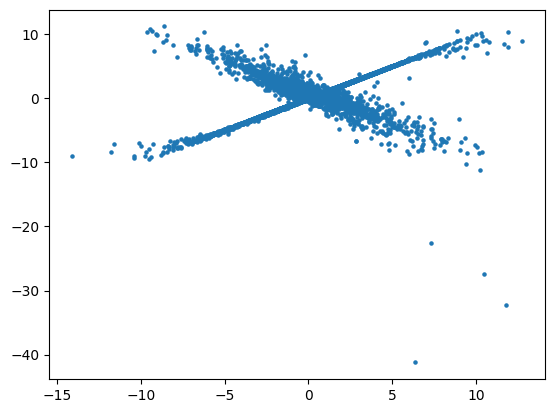

In [ ]:
plt.scatter(np.log2(t['cancerMean']/t['GTExMean']), t['log2FoldChange'], s=5)

Text(0, 0.5, 'TPM Counts Xena')

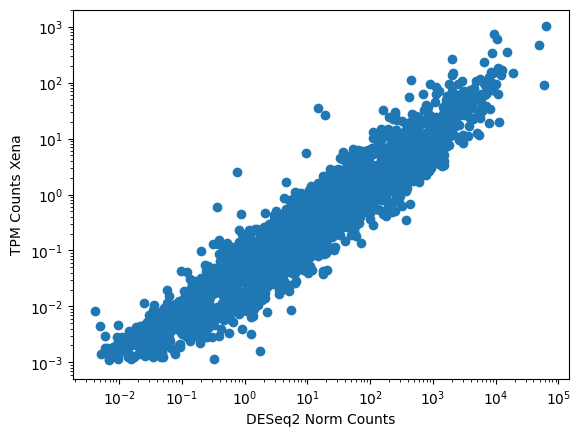

In [ ]:
plt.scatter(de_stats.loc[df[df['TCGA']=='ACC'].index]['GTExMean'], df[df['TCGA']=='ACC']['Normal'])
plt.loglog()
plt.xlabel('DESeq2 Norm Counts')
plt.ylabel('TPM Counts Xena')

,Transcript,TCGA,GTEx,Description,Normal,Cancer
Transcript,,,,,,
ENST00000603548,ENST00000603548,ACC,adrenal gland,Adrenocortical Cancer,0.196313,0.032429
ENST00000525546,ENST00000525546,ACC,adrenal gland,Adrenocortical Cancer,0.123265,0.052039
ENST00000470968,ENST00000470968,ACC,adrenal gland,Adrenocortical Cancer,0.115062,0.046974
ENST00000462950,ENST00000462950,ACC,adrenal gland,Adrenocortical Cancer,0.055922,0.026455
ENST00000334919,ENST00000334919,ACC,adrenal gland,Adrenocortical Cancer,0.152018,0.054637
...,...,...,...,...,...,...
ENST00000414678,ENST00000414678,ACC,adrenal gland,Adrenocortical Cancer,6.895063,4.761912
ENST00000256078,ENST00000256078,ACC,adrenal gland,Adrenocortical Cancer,0.103969,0.104246
ENST00000444134,ENST00000444134,ACC,adrenal gland,Adrenocortical Cancer,0.063734,0.045935


In [ ]:
de_stats.loc['ENST00000603548']

,Transcript,TCGA,GTEx,Description,Normal,Cancer
0,ENST00000603548,ACC,adrenal gland,Adrenocortical Cancer,0.196313,0.032429
1,ENST00000525546,ACC,adrenal gland,Adrenocortical Cancer,0.123265,0.052039
2,ENST00000470968,ACC,adrenal gland,Adrenocortical Cancer,0.115062,0.046974
3,ENST00000462950,ACC,adrenal gland,Adrenocortical Cancer,0.055922,0.026455
4,ENST00000334919,ACC,adrenal gland,Adrenocortical Cancer,0.152018,0.054637
...,...,...,...,...,...,...
81769,ENST00000414678,LAML,blood,Acute Myeloid Leukemia,1.333524,23.381299
81770,ENST00000256078,LAML,blood,Acute Myeloid Leukemia,0.247795,0.562349
81771,ENST00000444134,LAML,blood,Acute Myeloid Leukemia,0.082513,1.299851
81772,ENST00000507187,LAML,blood,Acute Myeloid Leukemia,0.340704,1.298097


In [ ]:
df = pd.read_parquet('../../cache/gtex_tcga_pairs.parq')
for cancer in df['TCGA'].unique():
    de_stats = pd.read_csv(f"s3://velia-analyses-dev/VAP_20230329_tcga_differential_expression/deseq_output/{cancer}_GTEx_vs_TCGA.csv")
    de_stats.index = [i.split('.')[0] for i in de_stats['sample']]
    break
de_stats

,sample,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,cancerMean,GTExMean
ENST00000548312,ENST00000548312.5,2.052087,0.491126,0.329401,1.490967,1.359703e-01,1.861969e-01,2.503687,1.776109
ENST00000483781,ENST00000483781.5,1.655928,-1.713402,0.526383,-3.255050,1.133723e-03,2.297238e-03,0.710358,2.233776
ENST00000535093,ENST00000535093.1,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
ENST00000338863,ENST00000338863.11,326.249258,-1.612434,0.144415,-11.165274,6.030513e-29,7.127056e-28,143.136884,438.151264
ENST00000570899,ENST00000570899.1,1.968687,-0.293168,0.362904,-0.807840,4.191828e-01,4.929810e-01,1.700521,2.132566
...,...,...,...,...,...,...,...,...,...
ENST00000402231,ENST00000402231.1,0.003714,-0.209228,3.016028,-0.069372,9.446934e-01,NaN,0.009791,0.000000
ENST00000463473,ENST00000463473.2,0.516628,-0.167580,0.620667,-0.270000,7.871601e-01,8.285060e-01,0.455059,0.554253
ENST00000380293,ENST00000380293.3,2.363100,-1.623524,0.294724,-5.508619,3.616606e-08,1.188136e-07,1.235040,3.052471
ENST00000288710,ENST00000288710.6,2.122495,-0.091270,0.350318,-0.260535,7.944508e-01,8.345164e-01,2.264438,3.200529


In [ ]:
    # Loop over orfs, and populate sorf_table file with attributes of interest
    transcripts_to_map = []
    with jsonlines.open(os.path.join(OUTPUT_DIR, 'sorf_table.jsonlines'), mode = 'w') as fh:
        for current_orf in tqdm(orfs[:8]):
            # nt, aa = extract_nucleotide_sequence_broken_psl_starts(current_orf, reference)
            overlapping_tids = query_overlapping_transcripts(current_orf, session)
            overlapping_tids = [[i.split('.')[0] for i in [t.ensembl_id, t.refseq_id, t.chess_id] if i][0] for t in overlapping_tids]
            # exact_tids = find_seq_substring(nt, transcripts)
            # if len(tids)>0:
            # exact_tids = [i.split('|')[0].split('.')[0] for i in exact_tids]
            exact_tids = transcript_matching_results[current_orf.id][-1]
            nt = transcript_matching_results[current_orf.id][0]
            aa = transcript_matching_results[current_orf.id][1]
            attributes = {
                'chr': current_orf.assembly.ucsc_style_name,
                'vtx': f"VTX-{str(current_orf.id).zfill(7)}",
                'strand': current_orf.strand,
                'start': current_orf.start,
                'end': current_orf.end,
                'nucl': nt,
                'aa': aa,
                'transcripts_exact': exact_tids,
                'transcripts_overlapping': overlapping_tids,
                
            }
            transcripts_to_map+=exact_tids
            transcripts_to_map+=[i.split('.')[0] for i in overlapping_tids if i.startswith('ENST')]
            
            fh.write(attributes)

100%|██████████| 8/8 [00:00<00:00, 29.87it/s]


In [ ]:
df = load_jsonlines_table('../../.cache/sorf_table.jsonlines')
df['transcripts_exact'].apply(lambda x: len(x)).iloc[:100]s


100%|██████████| 794/794 [00:02<00:00, 316.24it/s] 


0      2
1      0
2      0
3      0
4      0
5      1
6      0
7      0
8      0
9      1
10     0
11     1
12     1
13     2
14     0
15     0
16     3
17     0
18     1
19     0
20     3
21     1
22     3
23     0
24     1
25     0
26     0
27     1
28     1
29     2
30     0
31     1
32     1
33     1
34     0
35     2
36     0
37     0
38     0
39     1
40     8
41     0
42     3
43     0
44    24
45     0
46     4
47     0
48     0
49     1
50     0
51     3
52     2
53     0
54     1
55     2
56     0
57     3
58     4
59     0
60     5
61     3
62     0
63     0
64     8
65     0
66     0
67     1
68     0
69     1
70     1
71     1
72     0
73     1
74     3
75     1
76     0
77     0
78     1
79     0
80    12
81     0
82     3
83     4
84     2
85     0
86     2
87     0
88     0
89     6
90     4
91     0
92     0
93     0
94     1
95     7
96     7
97     0
98     1
99     1
Name: transcripts_exact, dtype: int64

In [ ]:
exact_tids

[]

In [ ]:
GENOME_REFERENCE_PATH = 's3://velia-annotation-dev/genomes/hg38/GRCh38.p13.genome.fa.gz'

In [ ]:
with open('test_vtx.txt') as fhandle:
    ids = [int(i.replace('VTX-', '')) for i in fhandle.readlines()]
ids[:5]

[661740, 849972, 849974, 849976, 849977]

In [ ]:
new_ids = [851390, 81996, 850636]
ids = new_ids+ids

In [ ]:
# session.rollback()

In [ ]:
find_seq_substring('ATGAGACGCTTCGACTGTCTCATCGGGGCACTTGTAATAAGCATCTTGGTGCCACTGAATGCAATGCTGTATTCAAATAATAGCTTTCATCTTCACTCTTTT',
                   transcripts)

['ENST00000665868.2|ENSG00000229989.6|OTTHUMG00000035888.5|OTTHUMT00000517878.1|MIR181A1HG-206|MIR181A1HG|3209|lncRNA|',
 'ENST00000436880.2|ENSG00000229989.6|OTTHUMG00000035888.5|OTTHUMT00000087436.2|MIR181A1HG-203|MIR181A1HG|2308|lncRNA|']

In [ ]:
[i for i in orfs if i.id == 786168][0].nt_seq

'ATGATATTGCAGCTTTTTCTTTTGGTTGCGTGCAGTGAGAATCTGGGAGCTGAACCTGTTATCTGCATGGTCTTCAGAAATCAGGCAAACTCGGAAAATGCCAACGCCAAAAATGCTGATGGG'

In [ ]:
session = base.Session()

In [ ]:
SimpleNamespace(ucsc_style_name='test').ucsc_style_name

'test'

In [ ]:
class OrfData(object):
    def __init__(self, orf_query_object):
        self.id = orf_query_object.id
        self.start = orf_query_object.start
        self.end = orf_query_object.end
        self.strand = orf_query_object.strand
        self.assembly = SimpleNamespace(ucsc_style_name=orf_query_object.assembly.ucsc_style_name)
        self.chrom_starts = orf_query_object.chrom_starts
        self.block_sizes = orf_query_object.block_sizes
        self.phases = orf_query_object.phases
        self.aa_seq = orf_query_object.aa_seq
        self.nt_seq = orf_query_object.nt_seq
        

In [ ]:
orfs = session.query(Orf).filter(Orf.id.in_(ids)).all()
orfs = [OrfData(i) for i in orfs]
current_orf = orfs[0]
missing_orfs = set(ids) - set([i.id for i in orfs])
missing_orfs

set()

In [ ]:
def load_xena_tcga_gtex_target():
    # xena_metadata = pd.read_table('../data/TcgaTargetGTEX_phenotype.txt', encoding='latin-1', index_col=0)
    # xena_expression = pd.read_feather('../data/xena_ucsc_phase1to6.feather')
    # xena_expression.index = xena_expression.pop('index')
    xena_expression = pd.read_parquet(os.path.join(CACHE_DIR, 'xena.parq'))
    xena_metadata = xena_expression[xena_expression.columns[:6]]
    xena_expression = xena_expression[xena_expression.columns[6:]]
    # xena_metadata = xena_metadata.loc[xena_expression.index]
    vtx_id_to_transcripts = load_jsonlines_table(os.path.join(CACHE_DIR, 'sorf_table.jsonlines'))
                                                 # index_col='vtx')
    # vtx_id_to_transcripts = json.load(open('../data/vtx_to_ensembl_ids.json', 'r'))
    return xena_metadata, xena_expression, vtx_id_to_transcripts
CACHE_DIR = '../../.cache'
a,b,c = load_xena_tcga_gtex_target()

100%|██████████| 794/794 [00:05<00:00, 152.54it/s] 


,chr,vtx,strand,start,end,nucl,aa,transcripts_exact,transcripts_overlapping
vtx,,,,,,,,,
VTX-0007082,chr11,VTX-0007082,-,93479010,93479189,GCGGCAGCTCAAAGGGAAGCCCAAGAAGGAGACCTCCAAGGACAAGAAGGAGCGGAAGCAAGCCATGCAGGAGGCCCGGCAGCAGATCACTACAGTGGTGCTGCCCACGCTGGCCGTGGTCGTGCTCTTGATCGTGGTGTTTGTGTACGTGGCCACGCGCCCCACCATCACC,AAAQREAQEGDLQGQEGAEASHAGGPAADHYSGAAHAGRGRALDRGVCVRGHAPHHH,"[ENST00000700399, ENST00000700400]","[rna-XM_011542909, ENST00000525141, ENST00000596676, rna-XM_011542911, rna-XM_011542907, rna-XM_017018020, rna-XM_047427266, C, ENST00000298966, ENST00000527149, C]"
VTX-0007146,chr17,VTX-0007146,-,57744811,57745272,GGAACCCCTCTACCAGGCTGGGTCCATTCTCATGACGGTGAATACCCTACAGGGGAAAAAAATGATAGAGAGTGGCCTCCAGTCTGGAGACTTTTCCCTGTCCCAGTCATGGCCCTCCTGCCTCCCACCACCCGCTGACTTGGAGATCCTGCAGCAGAAGGTGGCCGGGGTGCAACGGGAACTGGAGGACTTTAAG...,GTPLPGWVHSHDGEYPTGEKNDREWPPVWRLFPVPVMALLPPTTR*LGDPAAEGGRGATGTGGL*ERGIEVHSLP*RRLLRDEWSPGATGGAGGSREAAAKGGGGPWHRAQQGSHLPVAARETAPGALQAAGGPAAGQGT*RPACHQEEPG,[],[ENST00000299415]
VTX-0007396,chr19,VTX-0007396,-,54465101,54465547,GCCCGTGCTGAAGCAGCTGGGCCCCGCGCAGCCCAAGAAGCGGCCTGATCGCGGCGCCCTGTCCATCTCCGCGCCGCTCGGCGACTTCCGGCACACGCTGCACGTGGGGCGCGGCGGCGACGCCTTCGGGGACACCTCGTTCCTGAGCCGCCACGGCGGCGGGCCGCCCCCCGAGCCCCGGGCGCCCCCCGCGGGG...,ARAEAAGPRAAQEAA*SRRPVHLRAARRLPAHAARGARRRRLRGHLVPEPPRRRAAPRAPGAPRGGPALPAAARRPAVRSALACRPAAVLPPGSGALHAGRGAGRHGRGAPGGGCRQARRGTPPRDAAPPGPLPPQRGPRAERRHR,[],"[C, ENST00000301200]"
VTX-0007541,chr1,VTX-0007541,+,160370732,160371133,ATGATGCTCAACTCAGACACCATGGAGCTGGACCTGCCGCCCACCCACTCAGAGACTGAGTCGGGCTTCAGTGACTGTGGGGGCGGGGCGGGCCCTGATGGTGCCGGGCCTGGGGGTCCGGGAGGGGGCCAGGCCCGAGGCCCAGAGCCGGGAGAGCCTGGCCGGAAAGACCTGCAGCATCTGAGCCGCGAGGAGC...,MMLNSDTMELDLPPTHSETESGFSDCGGGAGPDGAGPGGPGGGQARGPEPGEPGRKDLQHLSREERRRRRRATAKYRTAHATRERIRVEAFNLAFAELRKLLPTLPPDKKLSKIEILRLAICYISYLNHVLDV,[],[ENST00000302101]
VTX-0009335,chr14,VTX-0009335,+,20747581,20748024,ATGACATCCTCTCTAAAGATTTGGGGCATACTCTTGGCCCTGCTTTGCATCCTTTGCAGGCTGTGTGTATACAGTAACAACATTTACTGGAGAGAATTCATAAAACTTCATTACTTAAGTCCAAGTCGAGAATTCAAAGAGTACAAATGTGATGTCCTCATGAGAGAAAAAGAGGCTCTGAAAGGCAAGAGCTTTC...,MTSSLKIWGILLALLCILCRLCVYSNNIYWREFIKLHYLSPSREFKEYKCDVLMREKEALKGKSFHMFIYSLWFKIQRACINEKGSDRYRNAYVWAPGALKVLECHWEKYNNRYTESRSFSYIEFHCGVDGYVDNIEDLRIIEPISN,[],"[ENST00000326842, rna-XM_017020934, C]"
...,...,...,...,...,...,...,...,...,...
VTX-0852788,chr1,VTX-0852788,,-1,-1,,,"[ENST00000456328, ENST00000450305, ENST00000488147, ENST00000619216, ENST00000473358, ENST00000469289, ENST00000607096, ENST00000417324, ENST00000461467, ENST00000606857, ENST00000642116, ENST0000...",[]
VTX-0852790,chr1,VTX-0852790,,-1,-1,,,"[ENST00000456328, ENST00000450305, ENST00000488147, ENST00000619216, ENST00000473358, ENST00000469289, ENST00000607096, ENST00000417324, ENST00000461467, ENST00000606857, ENST00000642116, ENST0000...",[]
VTX-0852794,chr1,VTX-0852794,,-1,-1,,,"[ENST00000456328, ENST00000450305, ENST00000488147, ENST00000619216, ENST00000473358, ENST00000469289, ENST00000607096, ENST00000417324, ENST00000461467, ENST00000606857, ENST00000642116, ENST0000...",[]


In [ ]:
import jsonlines
import json
from tqdm import tqdm
def load_jsonlines_table(path_to_file):
    with open(path_to_file) as fh:
        results = []
        for line in tqdm(fh.readlines()):
            results.append(json.loads(line))
    df = pd.DataFrame(results)
    df.index = df['vtx']
    return df
t = load_jsonlines_table('../../.cache/sorf_table.jsonlines')
t.head(3)

100%|██████████| 794/794 [00:02<00:00, 361.50it/s] 


,chr,vtx,strand,start,end,nucl,aa,transcripts_exact,transcripts_overlapping
vtx,,,,,,,,,
VTX-0007082,chr11,VTX-0007082,-,93479010,93479189,GCGGCAGCTCAAAGGGAAGCCCAAGAAGGAGACCTCCAAGGACAAGAAGGAGCGGAAGCAAGCCATGCAGGAGGCCCGGCAGCAGATCACTACAGTGGTGCTGCCCACGCTGGCCGTGGTCGTGCTCTTGATCGTGGTGTTTGTGTACGTGGCCACGCGCCCCACCATCACC,AAAQREAQEGDLQGQEGAEASHAGGPAADHYSGAAHAGRGRALDRGVCVRGHAPHHH,"[ENST00000700399, ENST00000700400]","[rna-XM_011542909, ENST00000525141, ENST00000596676, rna-XM_011542911, rna-XM_011542907, rna-XM_017018020, rna-XM_047427266, C, ENST00000298966, ENST00000527149, C]"
VTX-0007146,chr17,VTX-0007146,-,57744811,57745272,GGAACCCCTCTACCAGGCTGGGTCCATTCTCATGACGGTGAATACCCTACAGGGGAAAAAAATGATAGAGAGTGGCCTCCAGTCTGGAGACTTTTCCCTGTCCCAGTCATGGCCCTCCTGCCTCCCACCACCCGCTGACTTGGAGATCCTGCAGCAGAAGGTGGCCGGGGTGCAACGGGAACTGGAGGACTTTAAG...,GTPLPGWVHSHDGEYPTGEKNDREWPPVWRLFPVPVMALLPPTTR*LGDPAAEGGRGATGTGGL*ERGIEVHSLP*RRLLRDEWSPGATGGAGGSREAAAKGGGGPWHRAQQGSHLPVAARETAPGALQAAGGPAAGQGT*RPACHQEEPG,[],[ENST00000299415]
VTX-0007396,chr19,VTX-0007396,-,54465101,54465547,GCCCGTGCTGAAGCAGCTGGGCCCCGCGCAGCCCAAGAAGCGGCCTGATCGCGGCGCCCTGTCCATCTCCGCGCCGCTCGGCGACTTCCGGCACACGCTGCACGTGGGGCGCGGCGGCGACGCCTTCGGGGACACCTCGTTCCTGAGCCGCCACGGCGGCGGGCCGCCCCCCGAGCCCCGGGCGCCCCCCGCGGGG...,ARAEAAGPRAAQEAA*SRRPVHLRAARRLPAHAARGARRRRLRGHLVPEPPRRRAAPRAPGAPRGGPALPAAARRPAVRSALACRPAAVLPPGSGALHAGRGAGRHGRGAPGGGCRQARRGTPPRDAAPPGPLPPQRGPRAERRHR,[],"[C, ENST00000301200]"


In [ ]:
transcript_matching_results = run_id_mapping_parallel(orfs, NCPU = 8)

/home/ec2-user/anaconda/envs/veliadash/lib/python3.11/site-packages/Bio/Seq.py:2804: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(
/home/ec2-user/anaconda/envs/veliadash/lib/python3.11/site-packages/Bio/Seq.py:2804: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(
/home/ec2-user/anaconda/envs/veliadash/lib/python3.11/site-packages/Bio/Seq.py:2804: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(
  0%|          | 0/794 [00:00<?, ?it/s]/home/ec2-user/anaconda/envs/veliadash/lib/python3.11/site-packages/Bio/Seq.py:2804: BiopythonWarning: Partial codon, len(sequence

In [ ]:
import numpy as np

In [ ]:
[i for i in np.where(np.array([i.chrom_starts.count(';') for i in orfs])>0)[0] if orfs[i].strand=='-']

[264,
 267,
 270,
 276,
 293,
 303,
 304,
 313,
 314,
 315,
 316,
 320,
 331,
 332,
 343,
 344,
 345,
 353,
 354,
 355,
 356,
 357,
 385,
 386,
 387,
 388,
 389,
 390,
 401,
 402,
 404,
 408,
 409,
 410,
 411,
 434,
 435,
 439,
 440,
 448,
 456,
 457,
 458,
 459,
 460,
 465,
 468,
 469,
 479,
 480,
 496,
 498,
 501,
 506,
 511,
 513,
 517,
 522,
 523,
 525,
 526,
 527,
 528,
 529,
 530,
 538,
 539,
 541,
 545,
 546,
 547,
 548,
 550,
 552,
 557,
 558,
 560,
 561,
 563,
 566,
 570,
 571,
 572,
 574,
 577,
 578,
 580,
 581,
 583,
 584,
 587,
 588,
 591,
 593,
 594,
 602,
 603,
 605,
 615,
 618,
 622,
 624,
 625,
 626,
 627,
 629,
 632,
 635,
 639,
 644,
 646,
 647,
 648,
 649,
 650,
 651,
 652,
 653,
 657,
 660,
 661,
 662,
 667,
 671,
 672,
 676,
 678,
 680,
 681,
 683,
 684,
 685,
 687,
 689,
 691,
 693,
 694,
 697,
 719,
 721,
 723]

In [ ]:
orfs[259]

ORF: 849976, VTX-0849976, CXCL2_74964836_75aa,(-)chr4:74098795-74099120

In [ ]:
reference[chrom][0:3]

>chr4:1-3
NNN

In [ ]:
reference[chrom][chrom_starts[i]:(chrom_starts[i] + blocks[i])].complement.seq[::-1]

'GAGCGCCCCTGGCCACTGAACTGCGCTGCCAGTGCTTGCAGACCCTGCAGGGAATTCACCTCAAGAACATCCAAAGTGTGAAGGTGAAGTCCCCCGGACCCCACTGCGCCCAAACCGAAGTCATG'

<module 'pyfaidx' from '/home/ec2-user/anaconda/envs/veliadash/lib/python3.11/site-packages/pyfaidx/__init__.py'>

In [ ]:

        o = orfs[293]
        blocks = [int(x) for x in o.block_sizes.split(';')]
        chrom_starts = [int(x) - 1 for x in o.chrom_starts.split(';')]
        start = o.start - 1
        strand = o.strand
        chrom = o.assembly.ucsc_style_name
        seqs = []
        for i, block in enumerate(blocks):
            if i == len(blocks)-1 and strand == '+':
                blocks[i] = blocks[i] - 3
                
            elif i == 0 and strand == '-':
                blocks[i] = blocks[i] - 3
                chrom_starts[i] = chrom_starts[i]+3
                # blocks[i] = blocks[i] + 
                
            if strand == '-':
                seqs.append(reference[chrom][chrom_starts[i]:(chrom_starts[i] + blocks[i])].complement.seq[::-1].upper())
            else:
                seqs.append(reference[chrom][chrom_starts[i]:(chrom_starts[i] + blocks[i])].seq.upper())
        
        if strand == '-':
            seqs.reverse()
        seq = ''.join(seqs)
        strand

'-'

In [ ]:
o.nt_seq == seq

False

In [ ]:
seqs

['GTGCCTTTTCAGTTTTGGCTGTTTTGGCTGATATTGCACCTTCCACAGATGACTTGG',
 'AGTGCTGGGATGAGAAATTTACCTGCACAAGGCTCTACTCTGTGCATCGGCCGGTTAAACAATGCATTCATCAGTTATGCTTCACCAG',
 'ACGACGTATGTACATCGTCAACAAGGAGATCTGCTCTCGTCTTGTCTGTAAGGAACACGAAG']

In [ ]:
seqs

['GTGCCTTTTCAGTTTTGGCTGTTTTGGCTGATATTGCACCTTCCACAGATGACTTGG',
 'AGTGCTGGGATGAGAAATTTACCTGCACAAGGCTCTACTCTGTGCATCGGCCGGTTAAACAATGCATTCATCAGTTATGCTTCACCAG',
 'TTTACGACGTATGTACATCGTCAACAAGGAGATCTGCTCTCGTCTTGTCTGTAAGGAACACGAAGCTA']

In [ ]:
o.aa_seq

'VPFQFWLFWLILHLPQMTWSAGMRNLPAQGSTLCIGRLNNAFISYASPVYDVCTSSTRRSALVLSVRNTKL'

In [ ]:
    orf = orfs[444]
    # if orf.start == -1 or orf.end == -1:
        # return None
    chrom = orf.assembly.ucsc_style_name
    blocks = list(zip(orf.chrom_starts.split(';'), orf.block_sizes.split(';'), orf.phases.split(';')))
    strand = orf.strand
    nucl = []
    for ix, (start, size, phase) in enumerate(blocks):
        start = int(start)-1
        size = int(size)
        phase = int(phase)
        if strand == '-' and ix == 0:
            # start = start-3
            size += 3
        if strand == '-':
            s = reference[chrom][start : start+size]
            s = s.complement.seq[::-1]
        else:
            s = reference[chrom][start : start+size]
            s = s.seq
        nucl.append(s)
    # if strand == '-' and len(blocks)>1:
    #     nucl[-1] = reference[chrom][start+3 : start+size].complement.seq[::-1]
    # elif strand == '-' and len(blocks)==1:
    #     nucl[0] = nucl[0][1:]
    if strand == '-':
        nucl = nucl[::-1]
    #     nucl = ' '.join(nucl)
    # else:
    #     nucl = ' '.join(nucl)

In [ ]:
orf.aa_seq

'VVESAIHTLVPLFFLAVVVTQTEGTTTEVECPTEGTTTRTSEDEETIVATKINLRATTSGSRV'

In [ ]:
nucl

['GTGGTGGAATCGGCTATCCATACCCTCGTGCCCCTGTTTTTCCTGGCCGTGGTAGTTACTCAAACAGAGGGAACTACAACAGAGGTGGAATGCCCAACAGAGGGAACTACAACCAG',
 'AACTTCAGAGGACGAGGAAACAATCGTGGCTACAAAAATCAATCTCAGGGCTACAACCAGTGGCAGCAGGGTG']

In [ ]:
chrom, blocks, strand

('chr4', [('74098798', '122', '2'), ('74099021', '100', '0')], '-')

In [ ]:
def create_comparison_groups_xena_tcga_vs_normal(xena):
    groups = {}
    for ix, row in tqdm(tissue_pairs.iterrows()):
        # Normal sample indexes for specific tissues
        normal = xena.index[(xena['_primary_site'].str.lower() == row['GTEx Tissue Type'].lower())
                                & (xena['_sample_type'] == 'Normal Tissue')]
        # Cancer sample indexes
        cancer = xena.index[(xena['detailed_category'].str.lower() == row['Description'].lower())
                                & (xena['_sample_type'] == 'Primary Tumor')]
        groups[row['TCGA Cancer Type']] = {'normal_indices': normal, 'cancer_indices': cancer,
                                       'GTEx Tissue': row['GTEx Tissue Type'], 'TCGA Cancer': row['Description']}
    return groups

In [ ]:
import numpy as np

In [ ]:
r

NameError: name 'r' is not defined

In [ ]:
xena.loc[g['normal_indices']][xena.columns[6:]].mean(axis=0)

ENST00000302101   -3.248698
ENST00000299415   -8.989675
ENST00000596676   -7.941365
ENST00000527149    1.095069
ENST00000525141    4.498505
ENST00000326842   -9.749581
ENST00000301200    2.436686
ENST00000298966    2.714475
dtype: float64

In [ ]:
'ENST00000253122' in xena.columns

False

In [ ]:
xena = pd.read_parquet('../../.cache/xena.parq')
tissue_pairs = pd.read_parquet('../../.cache/gtex_tcga_pairs.parq')
normal_vs_gtex_expression = pd.read_parquet('../../.cache/gtex_tcga_pairs.parq')
normal_vs_gtex_expression.index = normal_vs_gtex_expression['Transcript']
normal_vs_gtex_expression.loc['ENST00000253122']

,Transcript,TCGA,GTEx,Description,Normal,Cancer
Transcript,,,,,,
ENST00000253122,ENST00000253122,ACC,adrenal gland,Adrenocortical Cancer,33.600359,49.264961
ENST00000253122,ENST00000253122,BLCA,bladder,bladder urothelial carcinoma,37.728066,40.941452
ENST00000253122,ENST00000253122,BRCA,breast,breast invasive carcinoma,16.239323,14.747659
ENST00000253122,ENST00000253122,CESC,cervix uteri,Cervical & Endocervical Cancer,15.126069,51.724043
ENST00000253122,ENST00000253122,CHOL,liver,cholangiocarcinoma,1.640086,16.829578
ENST00000253122,ENST00000253122,COAD,colon,colon adenocarcinoma,45.299947,24.193626
ENST00000253122,ENST00000253122,DLBC,blood,Diffuse Large B-Cell Lymphoma,4.209813,1.067385
ENST00000253122,ENST00000253122,ESCA,esophagus,esophageal carcinoma,31.661973,46.371972
ENST00000253122,ENST00000253122,GBM,brain,glioblastoma multiforme,38.757408,57.155692


In [ ]:
cancer = xena.index[(xena['detailed_category'].str.lower() == row['Description'].lower())
                                & (xena['_sample_type'] == 'Primary Tumor')]

In [ ]:
normal_vs_gtex_expression

,Transcript,Cancer,GTEx,Description,Normal,Cancer
0,ENST00000302101,ACC,adrenal gland,Adrenocortical Cancer,-3.248698,-4.078971
1,ENST00000299415,ACC,adrenal gland,Adrenocortical Cancer,-8.989675,-8.215799
2,ENST00000596676,ACC,adrenal gland,Adrenocortical Cancer,-7.941365,-8.554186
3,ENST00000527149,ACC,adrenal gland,Adrenocortical Cancer,1.095069,-0.681665
4,ENST00000525141,ACC,adrenal gland,Adrenocortical Cancer,4.498505,4.025062
...,...,...,...,...,...,...
243,ENST00000527149,UVM,skin,uveal melanoma,-5.015234,-4.888420
244,ENST00000525141,UVM,skin,uveal melanoma,2.904968,1.755980
245,ENST00000326842,UVM,skin,uveal melanoma,-9.390312,-8.936177
246,ENST00000301200,UVM,skin,uveal melanoma,3.299456,3.419008


In [ ]:
normal_vs_gtex_expression[normal_vs_gtex_expression['Transcript'] == 'ENST00000253122']

,Transcript,Cancer,GTEx,Description,Normal,Cancer


In [ ]:
metadata = pd.read_table('s3://velia-data-dev/VDC_004_annotation/20230329_tcga_data/Xena/TcgaTargetGTEX_phenotype.txt')
metadata

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xca in position 15827: invalid continuation byte

Index(['GTEX-S4Q7-0003-SM-3NM8M', 'TCGA-19-1787-01', 'TCGA-S9-A7J2-01',
       'GTEX-QV31-1626-SM-2S1QC', 'TCGA-G3-A3CH-11',
       'GTEX-13OVI-1026-SM-5L3EM', 'GTEX-13OW5-0626-SM-5J2N2',
       'GTEX-XUZC-2026-SM-4BRW9', 'TCGA-EK-A2RE-01', 'TCGA-D5-5538-01',
       ...
       'TCGA-IB-7885-01', 'TCGA-B6-A0IA-01', 'GTEX-1117F-2826-SM-5GZXL',
       'TCGA-VQ-AA6F-01', 'TCGA-BR-8588-01', 'GTEX-11ZTS-3326-SM-5LU9Y',
       'TCGA-DD-A115-01', 'GTEX-ZA64-2126-SM-5Q5A8', 'TCGA-FV-A3I0-11',
       'GTEX-XV7Q-0426-SM-4BRVN'],
      dtype='object', length=19126)

In [ ]:
    transcripts_to_load = transcript_matching_results
    
    xena_transcripts = pd.read_csv('s3://velia-data-dev/VDC_004_annotation/20230329_tcga_data/xena_transcript_names.csv')
    if transcripts_to_load is None:
        transcripts_to_map = xena_transcripts['Xena Transcripts']
    else:
        overlapping_xena_sorf_transcripts = set(xena_transcripts['Xena Transcripts']).intersection(set(transcripts_to_load))
    xena = pd.read_feather('s3://velia-data-dev/VDC_004_annotation/20230329_tcga_data/xena.feather', columns = ['index']+list(overlapping_xena_sorf_transcripts))
    xena.index = xena.pop('index')
    metadata = pd.read_table('s3://velia-data-dev/VDC_004_annotation/20230329_tcga_data/Xena/TcgaTargetGTEX_phenotype.txt',
                             encoding = "ISO-8859-1", index_col=0)
    metadata = metadata[~metadata['_primary_site'].isna()]
    ordr = xena.index.intersection(metadata.index)
    xena = xena.loc[ordr].copy()
    metadata = metadata.loc[ordr].copy()

    tissue_pairs = pd.read_excel('s3://velia-data-dev/VDC_004_annotation/20230329_tcga_data/Xena/GTEx_TCGA_comparisons.xlsx')
    tissue_pairs['GTEx Tissue Type'] = tissue_pairs['GTEx Tissue Type'].str.replace('whole ', '')
    tissue_pairs = tissue_pairs[tissue_pairs['GTEx Tissue Type']!='--']
    
    # tissue_pairs.head(4)

,TCGA Cancer Type,Description,GTEx Tissue Type,Ambiguity,Unnamed: 4,Unnamed: 5
0,ACC,Adrenocortical Cancer,adrenal gland,N,NaN,NaN
1,BLCA,bladder urothelial carcinoma,bladder,N,NaN,NaN
2,BRCA,breast invasive carcinoma,breast,N,NaN,NaN
3,CESC,Cervical & Endocervical Cancer,cervix uteri,N,NaN,NaN


In [ ]:
metadata

,detailed_category,primary disease or tissue,_primary_site,_sample_type,_gender,_study
sample,,,,,,
TCGA-V4-A9EE-01,Uveal Melanoma,Uveal Melanoma,Eye,Primary Tumor,Male,TCGA
TCGA-VD-AA8N-01,Uveal Melanoma,Uveal Melanoma,Eye,Primary Tumor,Male,TCGA
TCGA-V4-A9EI-01,Uveal Melanoma,Uveal Melanoma,Eye,Primary Tumor,Male,TCGA
TCGA-VD-AA8O-01,Uveal Melanoma,Uveal Melanoma,Eye,Primary Tumor,Male,TCGA
TCGA-WC-A888-01,Uveal Melanoma,Uveal Melanoma,Eye,Primary Tumor,Male,TCGA
...,...,...,...,...,...,...
TARGET-20-PANPKN-09,Acute Myeloid Leukemia,Acute Myeloid Leukemia,White blood cell,Primary Blood Derived Cancer - Bone Marrow,Male,TARGET
TARGET-20-PANLIR-09,Acute Myeloid Leukemia,Acute Myeloid Leukemia,White blood cell,Primary Blood Derived Cancer - Bone Marrow,Male,TARGET
TARGET-20-PAPAWN-09,Acute Myeloid Leukemia,Acute Myeloid Leukemia,White blood cell,Primary Blood Derived Cancer - Bone Marrow,Male,TARGET


In [ ]:
transcript_matching_results[7082][-1]

['ENST00000525141', 'ENST00000298966', 'ENST00000527149', 'ENST00000596676']

In [ ]:
overlapping_tids

['XM_017023741.2', 'ENST00000329565.6']

In [ ]:
transcripts_to_map = []
with jsonlines.open('sorf_table.jsonlines', mode = 'w') as fh:
    for current_orf in tqdm(orfs):
        # nt, aa = extract_nucleotide_sequence_broken_psl_starts(current_orf, reference)
        overlapping_tids = query_overlapping_transcripts(current_orf, session)
        overlapping_tids = [[i.split('.')[0] for i in [t.ensembl_id, t.refseq_id, t.chess_id] if i][0] for t in overlapping_tids]
        # exact_tids = find_seq_substring(nt, transcripts)
        # if len(tids)>0:
        # exact_tids = [i.split('|')[0].split('.')[0] for i in exact_tids]
        exact_tids = transcript_matching_results[current_orf.id][-1]
        nt = transcript_matching_results[current_orf.id][0]
        aa = transcript_matching_results[current_orf.id][1]
        attributes = {
            'chr': current_orf.assembly.ucsc_style_name,
            'vtx': f"VTX-{str(current_orf.id).zfill(7)}",
            'strand': current_orf.strand,
            'start': current_orf.start,
            'end': current_orf.end,
            'nucl': nt,
            'aa': aa,
            'transcripts_exact': exact_tids,
            'transcripts_overlapping': overlapping_tids,
            
        }
        transcripts_to_map+=exact_tids
        transcripts_to_map+=[i.split('.')[0] for i in overlapping_tids if i.startswith('ENST')]
        
        fh.write(attributes)
        # break

  1%|          | 8/644 [00:00<00:49, 12.85it/s]


KeyError: 11192

In [ ]:
assembly_ids = {}

for assembly in session.query(base.Assembly).all():
    if assembly.ucsc_style_name.startswith('chr') and len(assembly.ucsc_style_name) < 6:
        assembly_ids[assembly.ucsc_style_name] = assembly
    else:
        assembly_ids[assembly.genbank_accession] = assembly

In [ ]:
assembly_ids

In [ ]:
from Bio import SeqIO

In [ ]:
with smart_open.open('s3://velia-annotation-dev/gencode/v42/gencode.v42.transcripts.fa.gz') as f:
    seqs = SeqIO.to_dict(SeqIO.parse(f, 'fasta'))

In [ ]:
# seqs.keys()

# Map transcripts

In [ ]:
targets = {
    'VTX-0851390': 'ATGGCCGAGAGGCCGGGGCCTCCGGGCGGCGCCGTGTCCGCGACCGCGTACCCTGACACCCCCGCGGAATTCCCTCCGCACCTCCAGGCGGGTGCGATGCGGCGCCGCTTTTGGGGCGTATTCAACTGTCTGTGCGCCGGCGCGTTCGGGGCCCTGGCCGCCGCCTCCGCCAAGCTGGCCTTCGGCAGCGAGGTGAGCATGGGTTTATGCGTCTTAGGCATTATTGTGATGGCGAGCACCAATTCTCTGATGTGGACCTTCTTTAGCCGGGGCCTCAGTTTCTCCATGTCTTCAGCCATTGCATCTGTCACAGTGACTTTTTCAAATATCCTCAGCTCGGCCTTCCTGGGCTATGTGCTGTATGGAGAGTGCCAGGAGGTCTTGTGGTGGGGAGGAGTGTTCCTTATTCTCTGCGGACTCACCCTAATCCACAGGAAGCTCCCACCCACCTGGAAGCCCCTTCCACACAAGCAGCAG',
    'VTX-0081996': 'ATGGCGGATGTGTCAGAGAGGACACTGCAGTTGTCCGTGCTAGTAGCCTTCGCTTCTGGAGTACTCCTGGGCTGGCAGGCGAACCGACTGCGGAGGCGCTACTTGGACTGGAGGAAAAGGAGGCTGCAGGACAAGCTGGCGGCGACGCAGAAGAAGCTGGACCTGGCC',
    'VTX-0087927': 'ATGAACGGCTCTCAGGCGGGCGCCGCGGCTCAGGCCGCCTGGCTGAGCTCCTGCTGTAACCAGTCGGCGTCGCCGCCGGAGCCCCCCGAGGGGCCGCGCGCGGTGCAGGCGGTGGTGCTCGGCGTGCTGTCCCTGCTGGTGCTTTGCGGGGTCCTGTTCCTGGGCGGCGGCCTCCTCCTCCGCGCCCAGGGCCTGACAGCGCTGCTGACCCGCGAGCAGCGCGCGTCCCGCGAGCCCGAGCCGGGCAGTGCCAGCGGAGAGGACGGCGACGACGACTCC',
    'VTX-0085840': 'ATGCTCCTGGGGAGTCTGTGGGGAAGATGCCATCCAGGGCGCTGTGCGCTCTTCCTCATCCTCGCCCTCCTGCTGGACGCGGTCGGCCTGGTCCTTTTGCTGCTGGGGATCTTGGCCCCCCTGAGTTCCTGGGACTTCTTCATCTACACAGGTGCCCTGATCCTGGCTCTCAGCCTACTGCTCTGGATCATCTGGTATTCCCTCAACATTGAGGTGTCTCCTGAAAAACTGGACCTG',
    'VTX-0087707': 'ATGACCTCCTGGCCAGGTGGCAGCTTTGGCCCTGACCCGCTCCTGGCCCTGCTGGTGGTGATCCTGCTAGCACGCCTCATCCTGTGGTCCTGCCTCGGGACCTACATCGACTACAGACTGGCCCAGCGGCGGCCCCAGAAACCCAAGCAGGAC',
}
for i, s in targets.items():
    hit = find_seq_substring(s, transcripts)
    print(i, hit)

VTX-0851390 ['ENST00000302392.5|ENSG00000169964.8|OTTHUMG00000133092.3|OTTHUMT00000256750.3|TMEM42-201|TMEM42|977|protein_coding|']
VTX-0081996 ['ENST00000611969.5|ENSG00000175701.11|OTTHUMG00000131194.5|OTTHUMT00000477505.2|MTLN-203|MTLN|427|protein_coding|', 'ENST00000414416.2|ENSG00000175701.11|OTTHUMG00000131194.5|OTTHUMT00000253918.4|MTLN-201|MTLN|2051|protein_coding|', 'ENST00000426713.1|ENSG00000175701.11|OTTHUMG00000131194.5|OTTHUMT00000338107.3|MTLN-202|MTLN|461|protein_coding|']
VTX-0087927 ['ENST00000546390.2|ENSG00000284791.2|OTTHUMG00000169615.4|OTTHUMT00000405071.2|SMIM41-201|SMIM41|1430|protein_coding|']
VTX-0085840 ['ENST00000581851.2|ENSG00000263429.4|OTTHUMG00000132847.7|OTTHUMT00000256321.4|TMEM238L-202|TMEM238L|1535|protein_coding|']
VTX-0087707 ['ENST00000641568.1|ENSG00000284713.2|OTTHUMG00000172974.2|OTTHUMT00000491249.1|SMIM38-202|SMIM38|2695|protein_coding|', 'ENST00000686937.1|ENSG00000284713.2|OTTHUMG00000172974.2|-|SMIM38-204|SMIM38|5447|protein_coding|', 'E

In [ ]:
import gzip
import fsspec
from pyfaidx import Fasta
import pandas as pd
from tqdm import tqdm

# deduped_conservation = pd.read_parquet('deduped_phylocsf_length_filtered.parq')
transcripts = Fasta('./gencode.v42.transcripts.fa')

def find_seq_substring(query, target_dict):
    return [k for k, s in target_dict.items() if query.lower() in s[:].seq.lower()]

def extract_sequence(reference, chrom, strand, block_starts, block_sizes):
    s = reference[chrom]
    sequence = ''
    for start, length in zip(block_starts, block_sizes):
        end = start + (3*(length-1)) + 3
        sequence += str(s[start : end])
    sequence+=str(s[end:end+3])
    return sequence

def pfunc(row):
    ix = row['qName']
    starts = tuple(map(int, row['tStarts'].strip(',').split(',')))
    sizes = tuple(map(int, row['blockSizes'].strip(',').split(',')))
    s = extract_sequence(genes, row['tName'], row['strand'], starts, sizes)
    # print(row['strand'], s[:3], s[-3:])
    # blat_sequences[row['qName']] = s
    matches = find_seq_substring(s, transcripts)
    if len(matches)>0:
        transcript_names = [i.split('|')[0].split('.')[0] for i in matches]
        gene_names = [i.split('|')[5] for i in matches]
        return ix, {'transcripts': transcript_names, 'genes': gene_names, 'sequence': s}
    else:
        return ix, {'transcripts': [], 'genes': [], 'sequence': s}
    
# import multiprocessing as mp
# with mp.Pool(120) as ppool:
#     annotations = {}
#     ixes, rows = list(zip(*deduped_conservation.iterrows()))
#     for r in tqdm(ppool.imap(pfunc, rows), total=50000):#, total=signalp_and_conserved.shape[0]):
#         annotations[r[0]] = r[1]